# BenchFS Performance Analysis

This notebook provides comprehensive analysis of BenchFS benchmark results, combining:
1. **io_uring io_depth Analysis** - Batching efficiency
2. **I/O Timing Analysis** - Disk I/O latency and bandwidth
3. **Node Transfer Analysis** - Load distribution across nodes

## Data Sources
- `io_depth_raw.csv`: Raw per-submit io_depth data
- `io_timing_raw.csv`: Raw per-I/O operation data
- `node_transfer_aggregated.csv`: Aggregated transfer data per second

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
from datetime import datetime
import re

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Configure plot sizes
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 12

In [2]:
# ============================================================
# Configuration - Update this path to your results directory
# ============================================================
RESULTS_DIR = Path('''
/work/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2026.02.26-07.48.19-debug_large/2026.02.26-07.49.16-572120.nqsv-2
'''.strip())

# Auto-detect system from results directory path
# Override manually if auto-detection fails: SYSTEM_MODE = "pegasus" or "sirius"
if 'sirius' in str(RESULTS_DIR).lower():
    SYSTEM_MODE = "sirius"
else:
    SYSTEM_MODE = "pegasus"

print(f"Results directory: {RESULTS_DIR}")
print(f"Directory exists: {RESULTS_DIR.exists()}")
print(f"System mode: {SYSTEM_MODE}")

Results directory: /work/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2026.02.26-07.48.19-debug_large/2026.02.26-07.49.16-572120.nqsv-2
Directory exists: True
System mode: pegasus


In [3]:
# ============================================================
# Helper Functions
# ============================================================

def parse_timestamp(ts_str):
    """Parse ISO timestamp string to datetime."""
    try:
        ts_str = ts_str.replace('Z', '+00:00')
        return datetime.fromisoformat(ts_str)
    except:
        return None

# Node name patterns per system
# Pegasus: bnodeXXX (3-digit, e.g., bnode044, bnode115)
# Sirius:  short alphanumeric (e.g., a10, a11, b03)
_NODE_PATTERNS = {
    "pegasus": re.compile(r'(bnode\d{3})\b'),
    "sirius":  re.compile(r'(?:^|\[)([a-z]\d+)\b'),
}
_NODE_VALID_PATTERNS = {
    "pegasus": re.compile(r'^bnode\d{3}$'),
    "sirius":  re.compile(r'^[a-z]\d+$'),
}

def clean_node_name(node_str):
    """Extract clean node name from potentially corrupted strings.
    
    Pegasus: extracts 'bnodeXXX' (3-digit)
    Sirius:  extracts short names like 'a10', 'b03'
    """
    pattern = _NODE_PATTERNS.get(SYSTEM_MODE, _NODE_PATTERNS["pegasus"])
    match = pattern.search(str(node_str))
    return match.group(1) if match else None

def is_valid_node_name(node_str):
    """Check if node name is valid for the current system."""
    pattern = _NODE_VALID_PATTERNS.get(SYSTEM_MODE, _NODE_VALID_PATTERNS["pegasus"])
    return bool(pattern.match(str(node_str)))

def valid_node_regex():
    """Return regex string for matching valid node names (for pandas str.match)."""
    if SYSTEM_MODE == "sirius":
        return r'^[a-z]\d+$'
    else:
        return r'^bnode\d+$'

def load_csv_if_exists(csv_path, name):
    """Load CSV file if it exists, return None otherwise."""
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        print(f"Loaded {name}: {len(df):,} records")
        return df
    else:
        print(f"{name} not found at {csv_path}")
        return None

---
# Part 1: io_uring io_depth Analysis

Analyzes io_uring batching efficiency. Low io_depth indicates suboptimal batching.

## Key Metrics
- **io_depth**: Number of SQEs in the submission queue at submit time
- **sqe_count**: Number of SQEs submitted in this batch
- Lower io_depth indicates suboptimal io_uring batching

In [4]:
# Load io_depth data
df_iodepth = load_csv_if_exists(RESULTS_DIR / 'io_depth_raw.csv', 'io_depth_raw.csv')

if df_iodepth is not None:
    df_iodepth['datetime'] = df_iodepth['timestamp'].apply(parse_timestamp)
    df_iodepth = df_iodepth.dropna(subset=['datetime'])
    
    # Clean node names and filter to valid format (system-dependent)
    df_iodepth['node'] = df_iodepth['node'].apply(clean_node_name)
    original_count = len(df_iodepth)
    df_iodepth = df_iodepth.dropna(subset=['node'])
    filtered_count = original_count - len(df_iodepth)
    if filtered_count > 0:
        print(f"Filtered out {filtered_count:,} records with invalid node names")
    
    start_time = df_iodepth['datetime'].min()
    df_iodepth['time_relative'] = (df_iodepth['datetime'] - start_time).dt.total_seconds()
    df_iodepth['time_bucket'] = (df_iodepth['time_relative'] // 1).astype(int)
    
    print(f"\nTime range: {df_iodepth['datetime'].min()} - {df_iodepth['datetime'].max()}")
    print(f"Duration: {df_iodepth['time_relative'].max():.1f} seconds")
    print(f"Nodes: {sorted(df_iodepth['node'].unique())}")
    print(f"\nio_depth statistics:")
    print(f"  Mean: {df_iodepth['io_depth'].mean():.2f}")
    print(f"  Median: {df_iodepth['io_depth'].median():.2f}")
    print(f"  Min: {df_iodepth['io_depth'].min()}, Max: {df_iodepth['io_depth'].max()}")

Loaded io_depth_raw.csv: 51,985 records

Time range: 2026-02-25 22:51:53.994813+00:00 - 2026-02-25 22:55:38.561983+00:00
Duration: 224.6 seconds
Nodes: ['bnode040']

io_depth statistics:
  Mean: 8.28
  Median: 2.00
  Min: 1, Max: 36


## 1.1 io_depth Distribution Overview

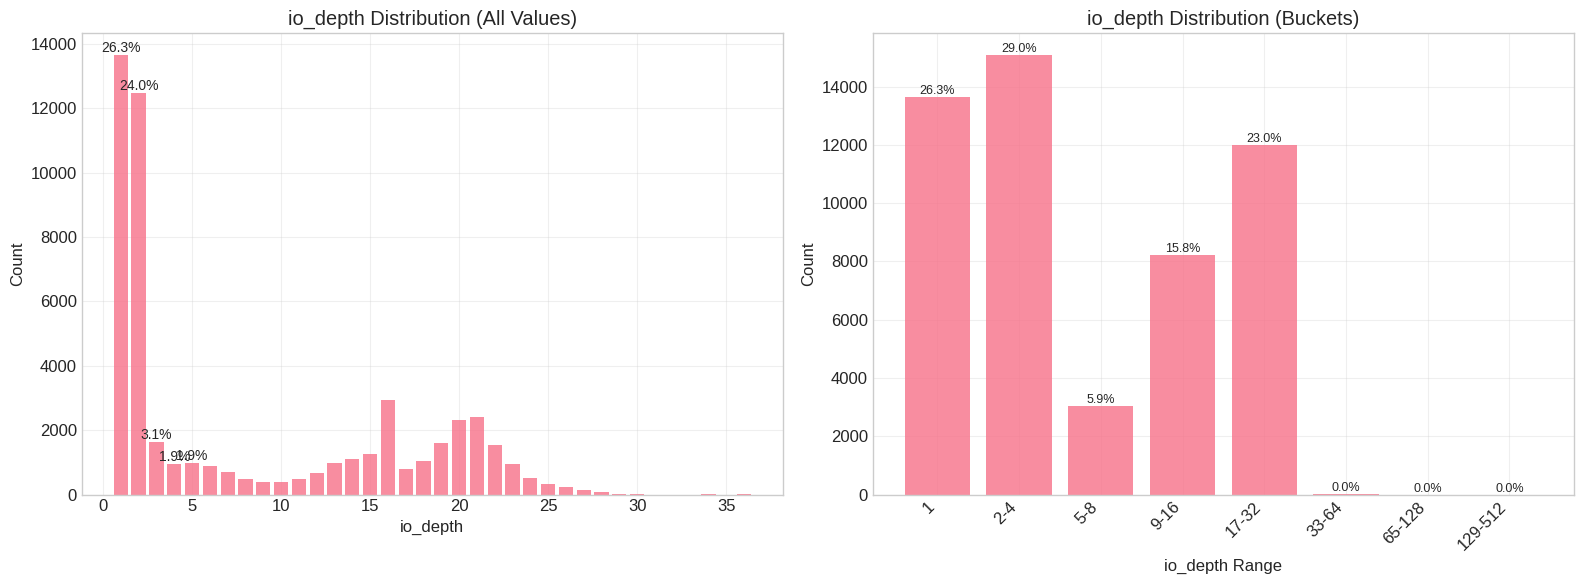

In [5]:
# io_depth distribution
if df_iodepth is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    total = len(df_iodepth)

    # Full distribution
    ax = axes[0]
    depth_counts = df_iodepth['io_depth'].value_counts().sort_index()
    ax.bar(depth_counts.index, depth_counts.values, alpha=0.8)
    ax.set_xlabel('io_depth')
    ax.set_ylabel('Count')
    ax.set_title('io_depth Distribution (All Values)')
    ax.grid(True, alpha=0.3)
    
    # Add percentage labels for top values
    for depth in depth_counts.head(5).index:
        count = depth_counts[depth]
        pct = count / total * 100
        ax.annotate(f'{pct:.1f}%', xy=(depth, count), ha='center', va='bottom', fontsize=10)

    # Bucketed distribution
    ax = axes[1]
    buckets = [(1, 1), (2, 4), (5, 8), (9, 16), (17, 32), (33, 64), (65, 128), (129, 512)]
    bucket_labels = ['1', '2-4', '5-8', '9-16', '17-32', '33-64', '65-128', '129-512']
    bucket_counts = [len(df_iodepth[(df_iodepth['io_depth'] >= lo) & (df_iodepth['io_depth'] <= hi)]) for lo, hi in buckets]

    bars = ax.bar(range(len(bucket_labels)), bucket_counts, alpha=0.8)
    ax.set_xticks(range(len(bucket_labels)))
    ax.set_xticklabels(bucket_labels, rotation=45, ha='right')
    ax.set_xlabel('io_depth Range')
    ax.set_ylabel('Count')
    ax.set_title('io_depth Distribution (Buckets)')
    ax.grid(True, alpha=0.3)

    for i, (bar, count) in enumerate(zip(bars, bucket_counts)):
        pct = count / total * 100
        ax.annotate(f'{pct:.1f}%', xy=(i, count), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'io_depth_distribution.png', dpi=150)
    plt.show()
    
    # Print warning if mostly io_depth=1
    depth_1_pct = len(df_iodepth[df_iodepth['io_depth'] == 1]) / total * 100
    if depth_1_pct > 50:
        print(f"\n*** WARNING: {depth_1_pct:.1f}% of submits have io_depth=1 ***")
        print("io_uring batching is highly inefficient!")

## 1.2 io_depth Over Time

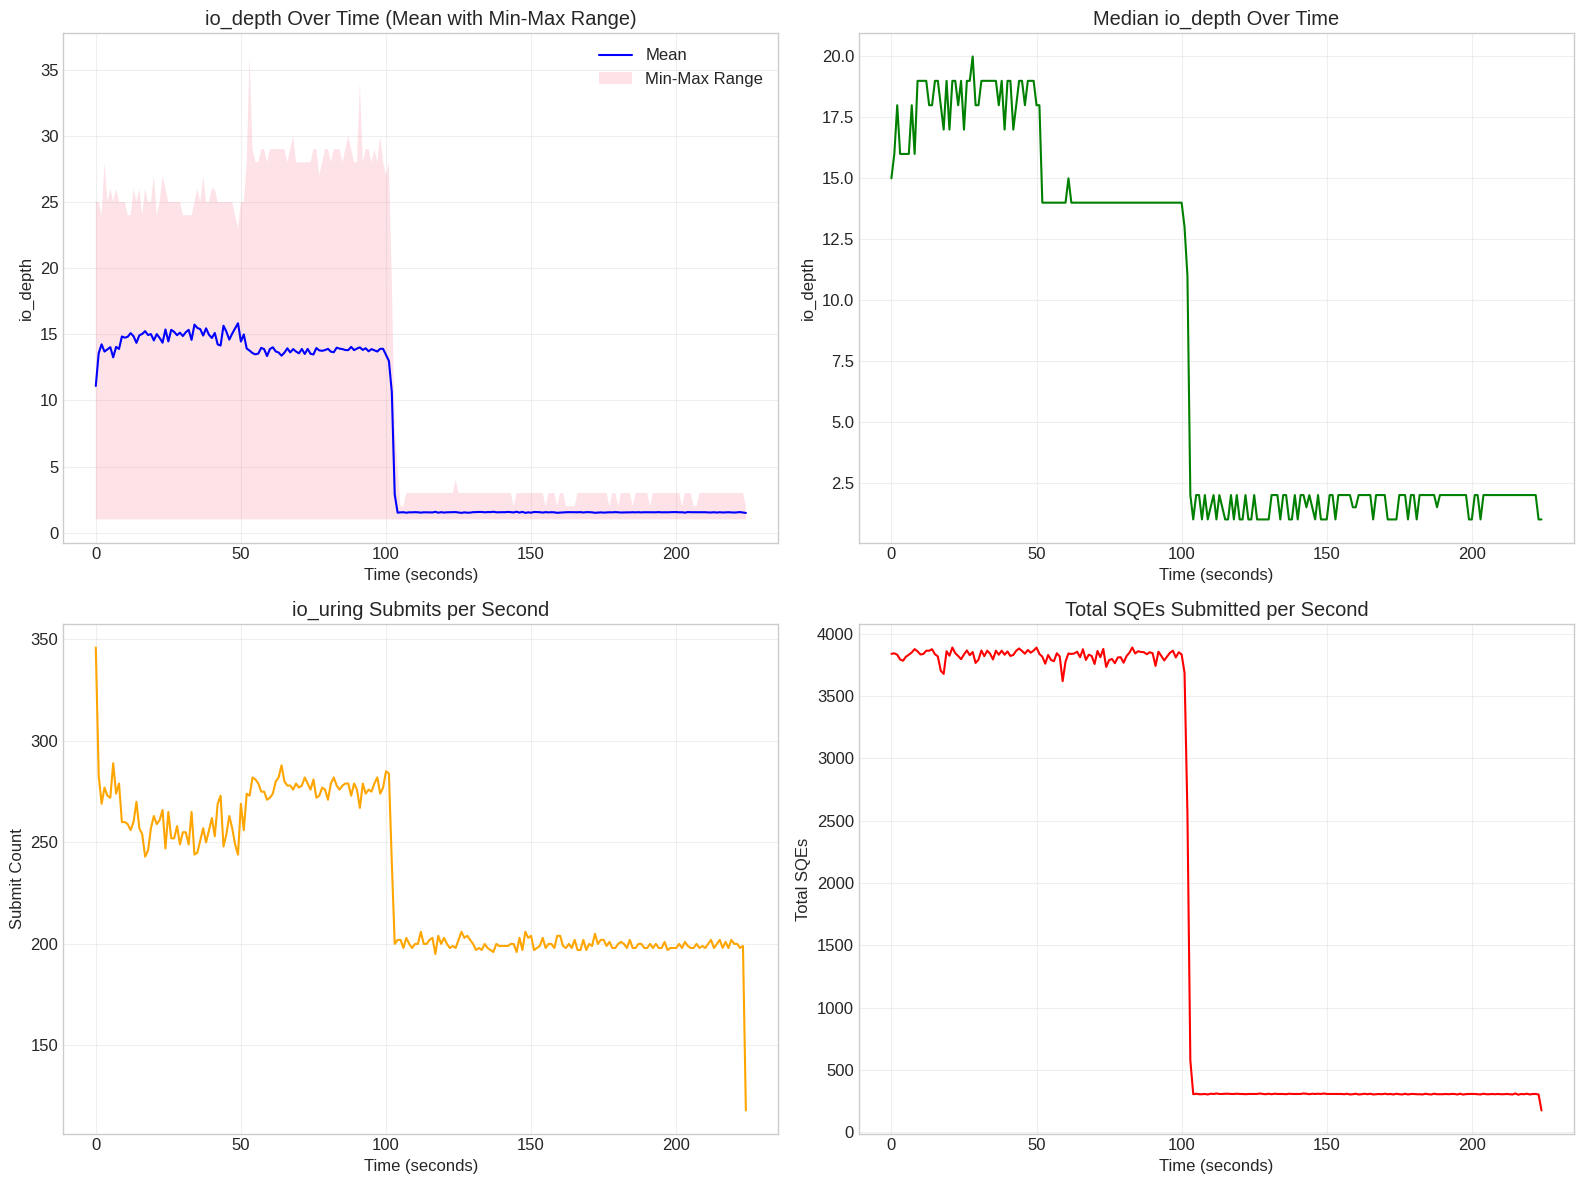

In [6]:
# io_depth over time
if df_iodepth is not None:
    time_stats = df_iodepth.groupby('time_bucket').agg({
        'io_depth': ['mean', 'median', 'min', 'max', 'std', 'count'],
        'sqe_count': 'sum'
    }).reset_index()
    time_stats.columns = ['time', 'mean', 'median', 'min', 'max', 'std', 'submit_count', 'total_sqes']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    ax = axes[0, 0]
    ax.plot(time_stats['time'], time_stats['mean'], linewidth=1.5, label='Mean', color='blue')
    ax.fill_between(time_stats['time'], time_stats['min'], time_stats['max'], alpha=0.2, label='Min-Max Range')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('io_depth')
    ax.set_title('io_depth Over Time (Mean with Min-Max Range)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[0, 1]
    ax.plot(time_stats['time'], time_stats['median'], linewidth=1.5, color='green')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('io_depth')
    ax.set_title('Median io_depth Over Time')
    ax.grid(True, alpha=0.3)

    ax = axes[1, 0]
    ax.plot(time_stats['time'], time_stats['submit_count'], linewidth=1.5, color='orange')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Submit Count')
    ax.set_title('io_uring Submits per Second')
    ax.grid(True, alpha=0.3)

    ax = axes[1, 1]
    ax.plot(time_stats['time'], time_stats['total_sqes'], linewidth=1.5, color='red')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Total SQEs')
    ax.set_title('Total SQEs Submitted per Second')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'io_depth_over_time.png', dpi=150)
    plt.show()

## 1.3 Per-Node io_depth Analysis

Per-Node io_depth Statistics:
    node     mean  median  min  max      std  submit_count  total_sqes
bnode040 8.275579     2.0    1   36 8.244777         51985      430206


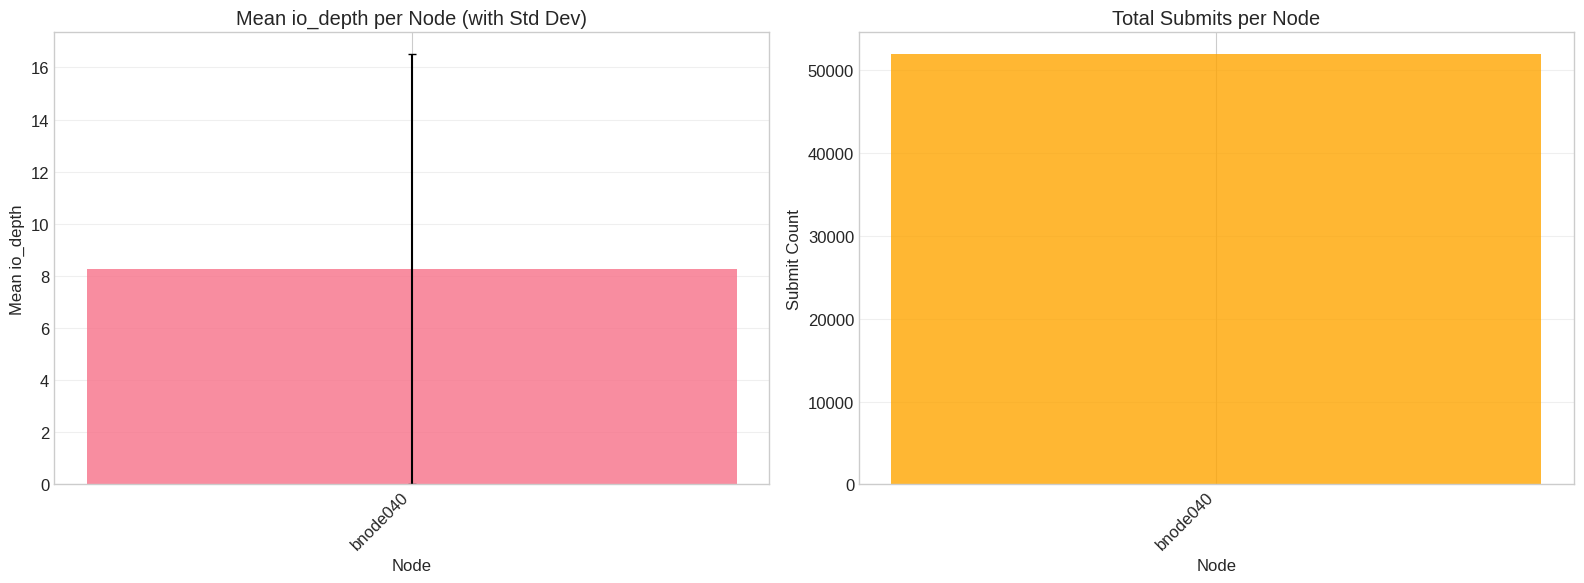

In [7]:
# Per-node io_depth statistics
if df_iodepth is not None:
    node_stats = df_iodepth.groupby('node').agg({
        'io_depth': ['mean', 'median', 'min', 'max', 'std', 'count'],
        'sqe_count': 'sum'
    }).reset_index()
    node_stats.columns = ['node', 'mean', 'median', 'min', 'max', 'std', 'submit_count', 'total_sqes']
    node_stats = node_stats.sort_values('node')

    print("Per-Node io_depth Statistics:")
    print(node_stats.to_string(index=False))

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Mean io_depth per node
    ax = axes[0]
    x = range(len(node_stats))
    ax.bar(x, node_stats['mean'], alpha=0.8)
    ax.errorbar(x, node_stats['mean'], yerr=node_stats['std'], fmt='none', color='black', capsize=3)
    ax.set_xticks(x)
    ax.set_xticklabels(node_stats['node'], rotation=45, ha='right')
    ax.set_xlabel('Node')
    ax.set_ylabel('Mean io_depth')
    ax.set_title('Mean io_depth per Node (with Std Dev)')
    ax.grid(True, alpha=0.3, axis='y')

    # Submit count per node
    ax = axes[1]
    ax.bar(x, node_stats['submit_count'], alpha=0.8, color='orange')
    ax.set_xticks(x)
    ax.set_xticklabels(node_stats['node'], rotation=45, ha='right')
    ax.set_xlabel('Node')
    ax.set_ylabel('Submit Count')
    ax.set_title('Total Submits per Node')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'io_depth_per_node.png', dpi=150)
    plt.show()

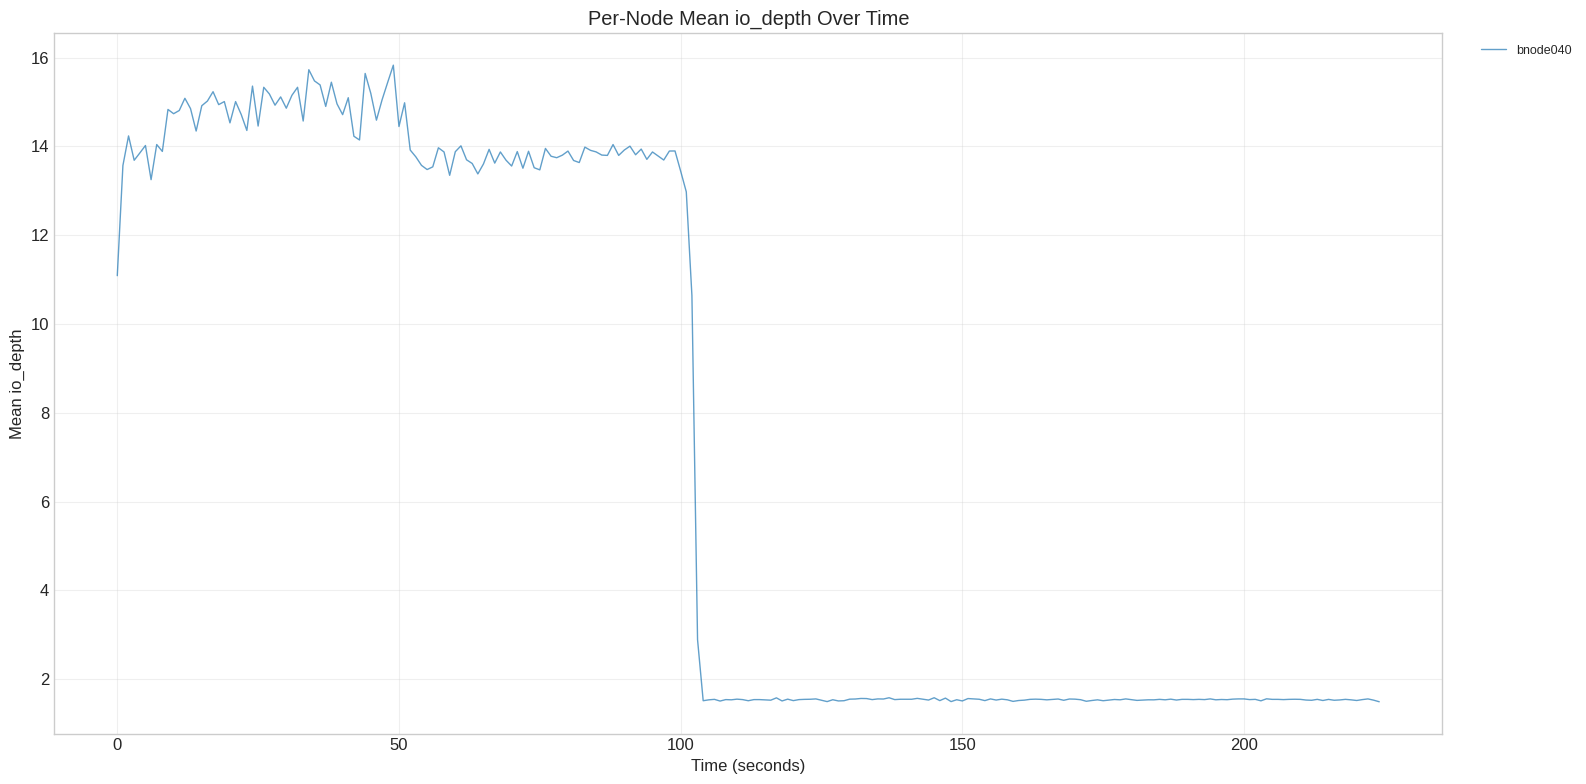

In [8]:
# Per-node io_depth over time
if df_iodepth is not None:
    node_time_stats = df_iodepth.groupby(['time_bucket', 'node']).agg({
        'io_depth': 'mean'
    }).reset_index()
    node_time_pivot = node_time_stats.pivot(index='time_bucket', columns='node', values='io_depth').fillna(0)

    fig, ax = plt.subplots(figsize=(16, 8))

    nodes = sorted(node_time_pivot.columns)
    colors = plt.cm.tab20(np.linspace(0, 1, len(nodes)))

    for i, node in enumerate(nodes):
        if node in node_time_pivot.columns:
            ax.plot(node_time_pivot.index, node_time_pivot[node], 
                    label=node, linewidth=1, alpha=0.7, color=colors[i])

    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Mean io_depth')
    ax.set_title('Per-Node Mean io_depth Over Time')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'io_depth_per_node_over_time.png', dpi=150, bbox_inches='tight')
    plt.show()

## 1.4 io_depth Heatmap

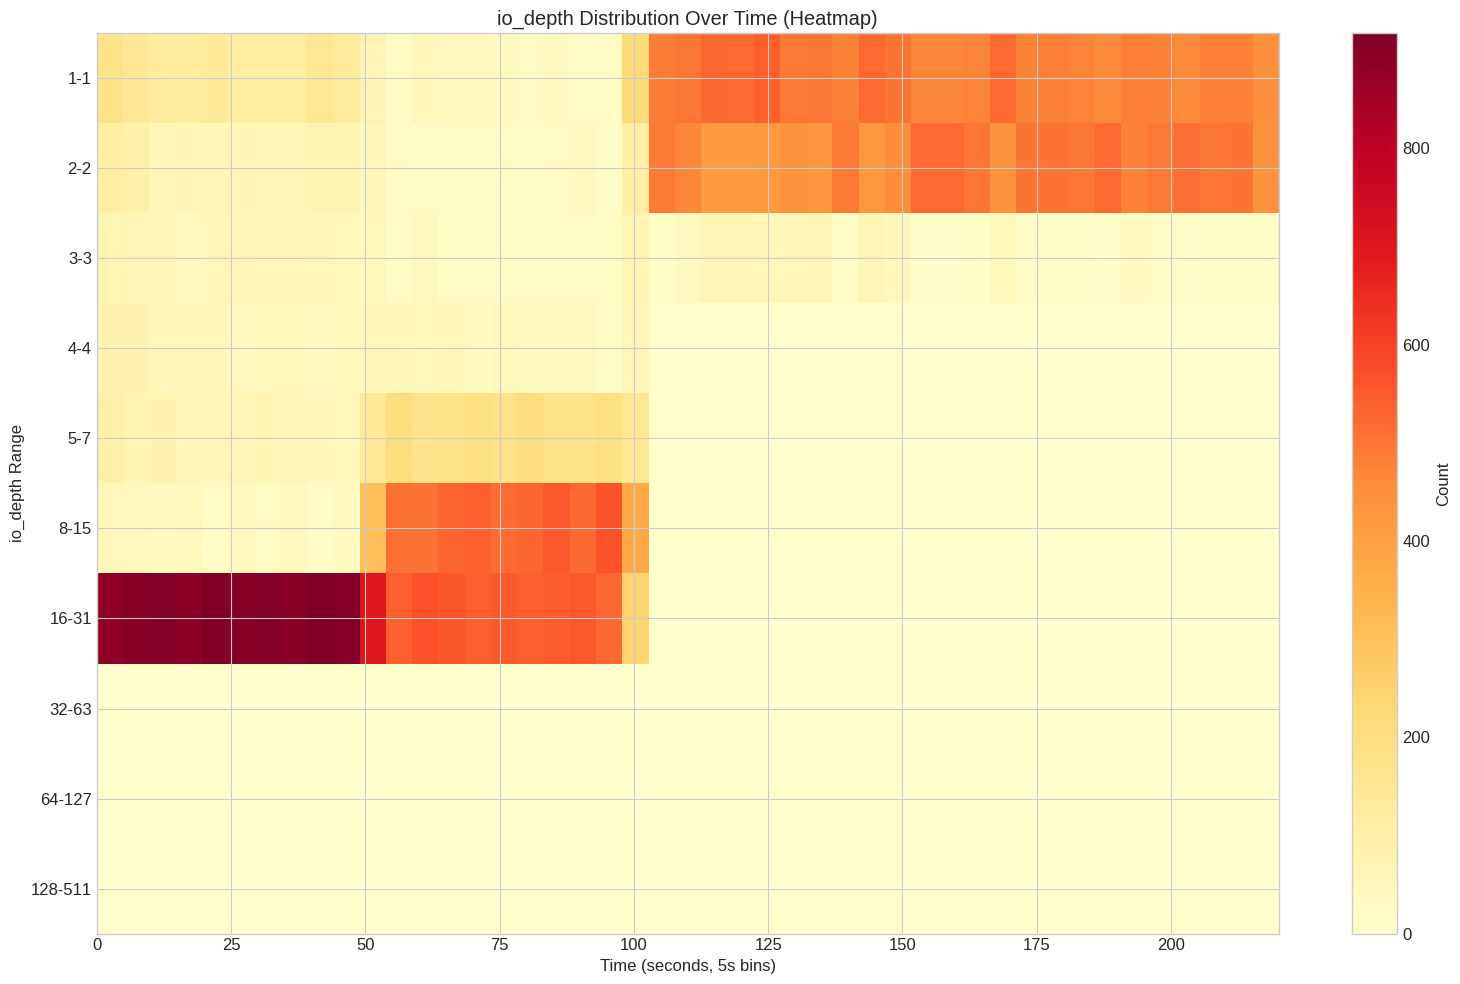

In [9]:
# Heatmap: io_depth distribution over time
if df_iodepth is not None:
    time_bin = 5  # seconds
    df_iodepth['time_bin'] = (df_iodepth['time_relative'] // time_bin).astype(int) * time_bin

    # Create histogram per time bin
    depth_bins = [1, 2, 3, 4, 5, 8, 16, 32, 64, 128, 512]
    heatmap_data = []

    for time_bin_val in sorted(df_iodepth['time_bin'].unique()):
        bin_df = df_iodepth[df_iodepth['time_bin'] == time_bin_val]
        row = {'time': time_bin_val}
        for i in range(len(depth_bins) - 1):
            lo, hi = depth_bins[i], depth_bins[i+1] - 1
            count = len(bin_df[(bin_df['io_depth'] >= lo) & (bin_df['io_depth'] <= hi)])
            row[f'{lo}-{hi}'] = count
        heatmap_data.append(row)

    heatmap_df = pd.DataFrame(heatmap_data).set_index('time')

    fig, ax = plt.subplots(figsize=(16, 10))

    im = ax.imshow(heatmap_df.T, aspect='auto', cmap='YlOrRd',
                   extent=[heatmap_df.index.min(), heatmap_df.index.max(), 
                           len(heatmap_df.columns)-0.5, -0.5])

    ax.set_xlabel(f'Time (seconds, {time_bin}s bins)')
    ax.set_ylabel('io_depth Range')
    ax.set_title('io_depth Distribution Over Time (Heatmap)')
    ax.set_yticks(range(len(heatmap_df.columns)))
    ax.set_yticklabels(heatmap_df.columns)

    cbar = plt.colorbar(im, ax=ax, label='Count')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'io_depth_heatmap.png', dpi=150)
    plt.show()

## 1.5 Batching Efficiency Analysis

In [10]:
# Batching efficiency analysis
if df_iodepth is not None:
    print("=" * 80)
    print("Batching Efficiency Analysis")
    print("=" * 80)

    total_submits = len(df_iodepth)
    total_sqes = df_iodepth['sqe_count'].sum()
    avg_batch_size = df_iodepth['io_depth'].mean()

    print(f"\nOverall Statistics:")
    print(f"  Total io_uring submits: {total_submits:,}")
    print(f"  Total SQEs submitted: {total_sqes:,}")
    print(f"  Average batch size (io_depth): {avg_batch_size:.2f}")

    # Efficiency metrics
    depth_1_count = len(df_iodepth[df_iodepth['io_depth'] == 1])
    depth_1_pct = depth_1_count / total_submits * 100
    depth_le4_count = len(df_iodepth[df_iodepth['io_depth'] <= 4])
    depth_le4_pct = depth_le4_count / total_submits * 100
    depth_gt16_count = len(df_iodepth[df_iodepth['io_depth'] > 16])
    depth_gt16_pct = depth_gt16_count / total_submits * 100

    print(f"\nBatching Efficiency:")
    print(f"  io_depth=1 (unbatched): {depth_1_count:,} ({depth_1_pct:.1f}%)")
    print(f"  io_depth<=4 (low batch): {depth_le4_count:,} ({depth_le4_pct:.1f}%)")
    print(f"  io_depth>16 (good batch): {depth_gt16_count:,} ({depth_gt16_pct:.1f}%)")

    # Theoretical efficiency
    ideal_batch_size = 64
    ideal_submits = total_sqes / ideal_batch_size
    efficiency = ideal_submits / total_submits * 100

    print(f"\nTheoretical Efficiency (assuming ideal batch_size={ideal_batch_size}):")
    print(f"  Actual submits: {total_submits:,}")
    print(f"  Ideal submits: {ideal_submits:,.0f}")
    print(f"  Efficiency: {efficiency:.1f}%")

    # Performance impact
    syscall_overhead_us = 0.5
    wasted_time_ms = (total_submits - ideal_submits) * syscall_overhead_us / 1000

    print(f"\nEstimated Performance Impact:")
    print(f"  Extra syscalls: {total_submits - ideal_submits:,.0f}")
    print(f"  Wasted time (at {syscall_overhead_us}us/syscall): {wasted_time_ms:.1f} ms")

    if depth_1_pct > 50:
        print("\n" + "*" * 80)
        print("*** CRITICAL: Batching is highly inefficient! ***")
        print("*** Most operations are submitted individually (io_depth=1) ***")
        print("*** This is likely caused by synchronous operations blocking io_uring ***")
        print("*" * 80)

Batching Efficiency Analysis

Overall Statistics:
  Total io_uring submits: 51,985
  Total SQEs submitted: 430,206
  Average batch size (io_depth): 8.28

Batching Efficiency:
  io_depth=1 (unbatched): 13,651 (26.3%)
  io_depth<=4 (low batch): 28,725 (55.3%)
  io_depth>16 (good batch): 11,981 (23.0%)

Theoretical Efficiency (assuming ideal batch_size=64):
  Actual submits: 51,985
  Ideal submits: 6,722
  Efficiency: 12.9%

Estimated Performance Impact:
  Extra syscalls: 45,263
  Wasted time (at 0.5us/syscall): 22.6 ms


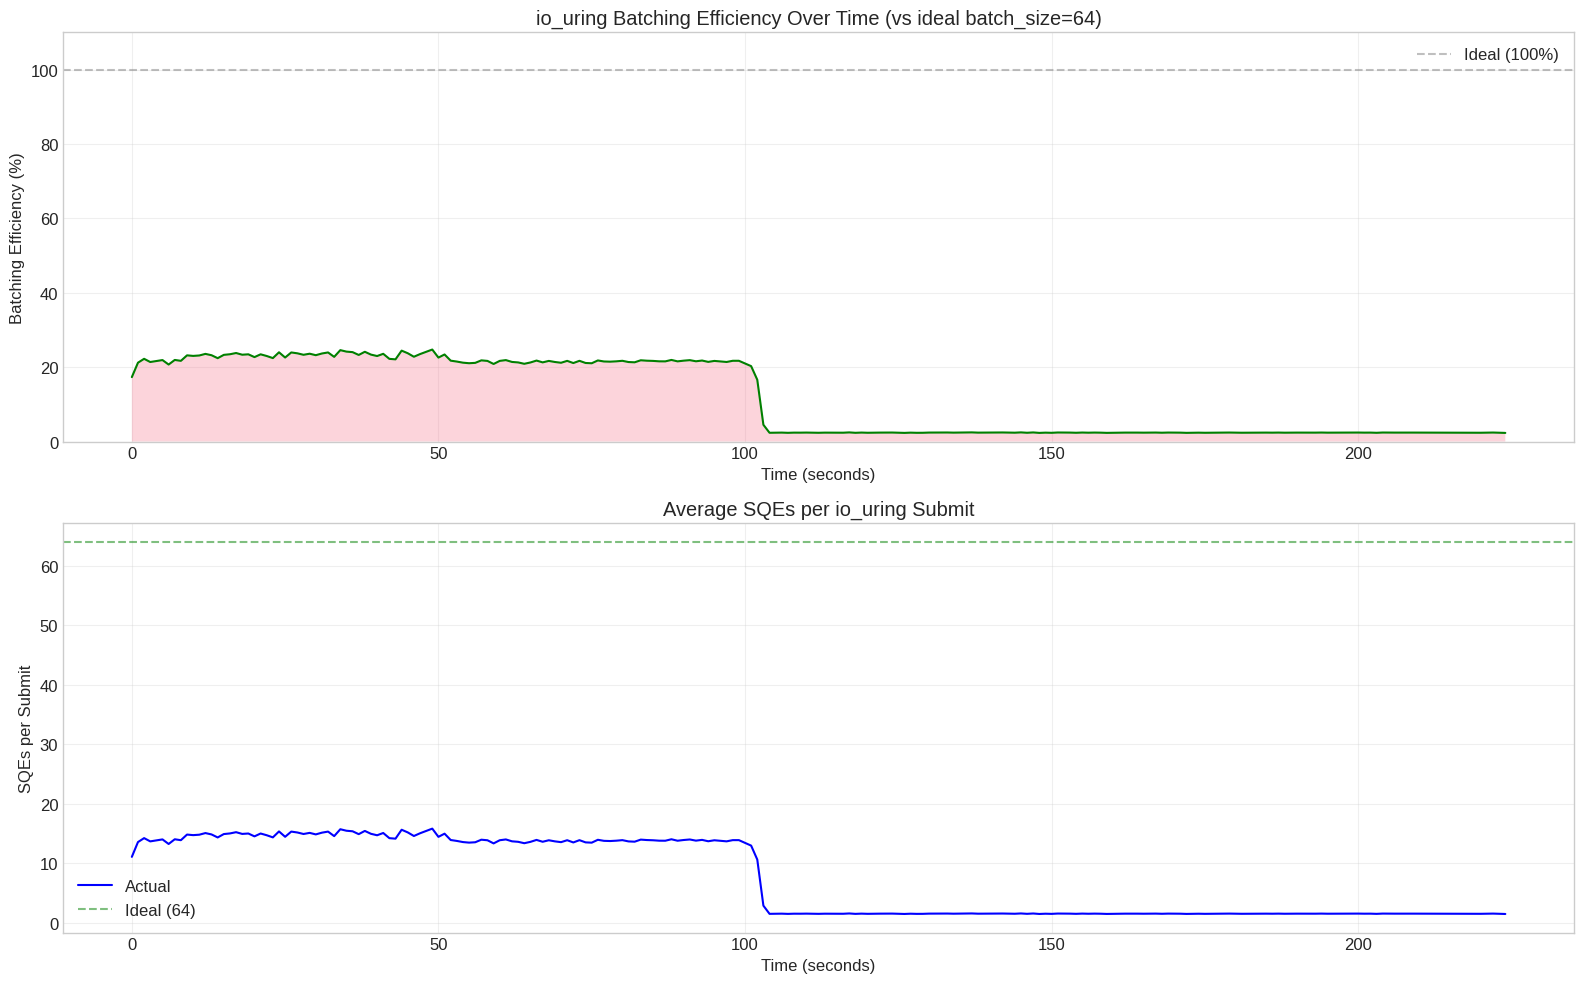

In [11]:
# Efficiency over time
if df_iodepth is not None:
    time_efficiency = df_iodepth.groupby('time_bucket').agg({
        'io_depth': 'mean',
        'sqe_count': ['sum', 'count']
    }).reset_index()
    time_efficiency.columns = ['time', 'mean_depth', 'total_sqes', 'submit_count']
    time_efficiency['efficiency'] = time_efficiency['mean_depth'] / 64 * 100
    time_efficiency['efficiency'] = time_efficiency['efficiency'].clip(upper=100)

    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    # Efficiency over time
    ax = axes[0]
    ax.plot(time_efficiency['time'], time_efficiency['efficiency'], linewidth=1.5, color='green')
    ax.axhline(y=100, color='gray', linestyle='--', alpha=0.5, label='Ideal (100%)')
    ax.fill_between(time_efficiency['time'], 0, time_efficiency['efficiency'], alpha=0.3)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Batching Efficiency (%)')
    ax.set_title('io_uring Batching Efficiency Over Time (vs ideal batch_size=64)')
    ax.set_ylim(0, 110)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # SQEs per submit
    ax = axes[1]
    ax.plot(time_efficiency['time'], time_efficiency['total_sqes'] / time_efficiency['submit_count'], 
            linewidth=1.5, color='blue', label='Actual')
    ax.axhline(y=64, color='green', linestyle='--', alpha=0.5, label='Ideal (64)')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('SQEs per Submit')
    ax.set_title('Average SQEs per io_uring Submit')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'io_depth_efficiency.png', dpi=150)
    plt.show()

## 1.6 io_depth Summary

In [12]:
# Final summary
if df_iodepth is not None:
    print("=" * 80)
    print("io_depth Analysis Summary")
    print("=" * 80)

    print(f"\nSource: {RESULTS_DIR}")
    print(f"Total submit events: {len(df_iodepth):,}")
    print(f"Total SQEs: {df_iodepth['sqe_count'].sum():,}")
    print(f"Duration: {df_iodepth['time_relative'].max():.1f} seconds")

    print(f"\nio_depth Statistics:")
    print(f"  Mean: {df_iodepth['io_depth'].mean():.2f}")
    print(f"  Median: {df_iodepth['io_depth'].median():.2f}")
    print(f"  Min: {df_iodepth['io_depth'].min()}")
    print(f"  Max: {df_iodepth['io_depth'].max()}")
    print(f"  Std: {df_iodepth['io_depth'].std():.2f}")

    print(f"\nPercentiles:")
    for p in [25, 50, 75, 90, 95, 99]:
        val = df_iodepth['io_depth'].quantile(p/100)
        print(f"  P{p}: {val:.1f}")

    print(f"\nBatching Breakdown:")
    for label, (lo, hi) in [('unbatched (=1)', (1, 1)), 
                             ('low (2-4)', (2, 4)), 
                             ('medium (5-16)', (5, 16)),
                             ('good (17-64)', (17, 64)),
                             ('excellent (>64)', (65, 9999))]:
        count = len(df_iodepth[(df_iodepth['io_depth'] >= lo) & (df_iodepth['io_depth'] <= hi)])
        pct = count / len(df_iodepth) * 100
        print(f"  {label}: {count:,} ({pct:.1f}%)")

    print(f"\n" + "=" * 80)
    if df_iodepth['io_depth'].mean() < 4:
        print("DIAGNOSIS: io_uring batching is severely inefficient.")
        print("CAUSE: Likely synchronous operations (file open, fsync) blocking the reactor.")
        print("SOLUTION: Ensure all file operations use async io_uring operations.")
    elif df_iodepth['io_depth'].mean() < 16:
        print("DIAGNOSIS: io_uring batching is suboptimal.")
        print("Consider tuning submit_depth threshold or wait_submit_timeout.")
    else:
        print("DIAGNOSIS: io_uring batching appears efficient.")
    print("=" * 80)

io_depth Analysis Summary

Source: /work/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2026.02.26-07.48.19-debug_large/2026.02.26-07.49.16-572120.nqsv-2
Total submit events: 51,985
Total SQEs: 430,206
Duration: 224.6 seconds

io_depth Statistics:
  Mean: 8.28
  Median: 2.00
  Min: 1
  Max: 36
  Std: 8.24

Percentiles:
  P25: 1.0
  P50: 2.0
  P75: 16.0
  P90: 21.0
  P95: 22.0
  P99: 25.0

Batching Breakdown:
  unbatched (=1): 13,651 (26.3%)
  low (2-4): 15,074 (29.0%)
  medium (5-16): 11,279 (21.7%)
  good (17-64): 11,981 (23.0%)
  excellent (>64): 0 (0.0%)

DIAGNOSIS: io_uring batching is suboptimal.
Consider tuning submit_depth threshold or wait_submit_timeout.


---
# Part 2: I/O Timing Analysis

Analyzes actual disk I/O latency and bandwidth (read_fixed_direct / write_fixed_direct).

## Key Metrics
- **elapsed_us**: Actual disk I/O latency in microseconds
- **bandwidth_mib_s**: Per-operation bandwidth in MiB/s
- **op**: Operation type (READ or WRITE)

In [13]:
# Load I/O timing data
df_timing = load_csv_if_exists(RESULTS_DIR / 'io_timing_raw.csv', 'io_timing_raw.csv')

if df_timing is not None:
    df_timing['datetime'] = df_timing['timestamp'].apply(parse_timestamp)
    df_timing = df_timing.dropna(subset=['datetime'])
    
    start_time = df_timing['datetime'].min()
    df_timing['time_relative'] = (df_timing['datetime'] - start_time).dt.total_seconds()
    df_timing['elapsed_ms'] = df_timing['elapsed_us'] / 1000
    
    # Clean node names and filter to valid format (system-dependent)
    df_timing['node'] = df_timing['node'].apply(clean_node_name)
    original_count = len(df_timing)
    df_timing = df_timing.dropna(subset=['node'])
    filtered_count = original_count - len(df_timing)
    if filtered_count > 0:
        print(f"Filtered out {filtered_count:,} records with invalid node names")
    
    df_timing['time_bucket'] = (df_timing['time_relative'] // 1).astype(int)
    
    print(f"\nTime range: {df_timing['datetime'].min()} - {df_timing['datetime'].max()}")
    print(f"Duration: {df_timing['time_relative'].max():.1f} seconds")
    print(f"Operations: {df_timing['op'].unique()}")
    print(f"Nodes: {sorted(df_timing['node'].unique())}")
    print(f"\nCounts by operation:")
    print(df_timing['op'].value_counts())

Loaded io_timing_raw.csv: 215,103 records

Time range: 2026-02-25 22:51:54.015279+00:00 - 2026-02-25 22:55:38.853241+00:00
Duration: 224.8 seconds
Operations: ['WRITE' 'READ']
Nodes: ['bnode040']

Counts by operation:
op
WRITE    196608
READ      18495
Name: count, dtype: int64


## 2.1 Overall Bandwidth Distribution

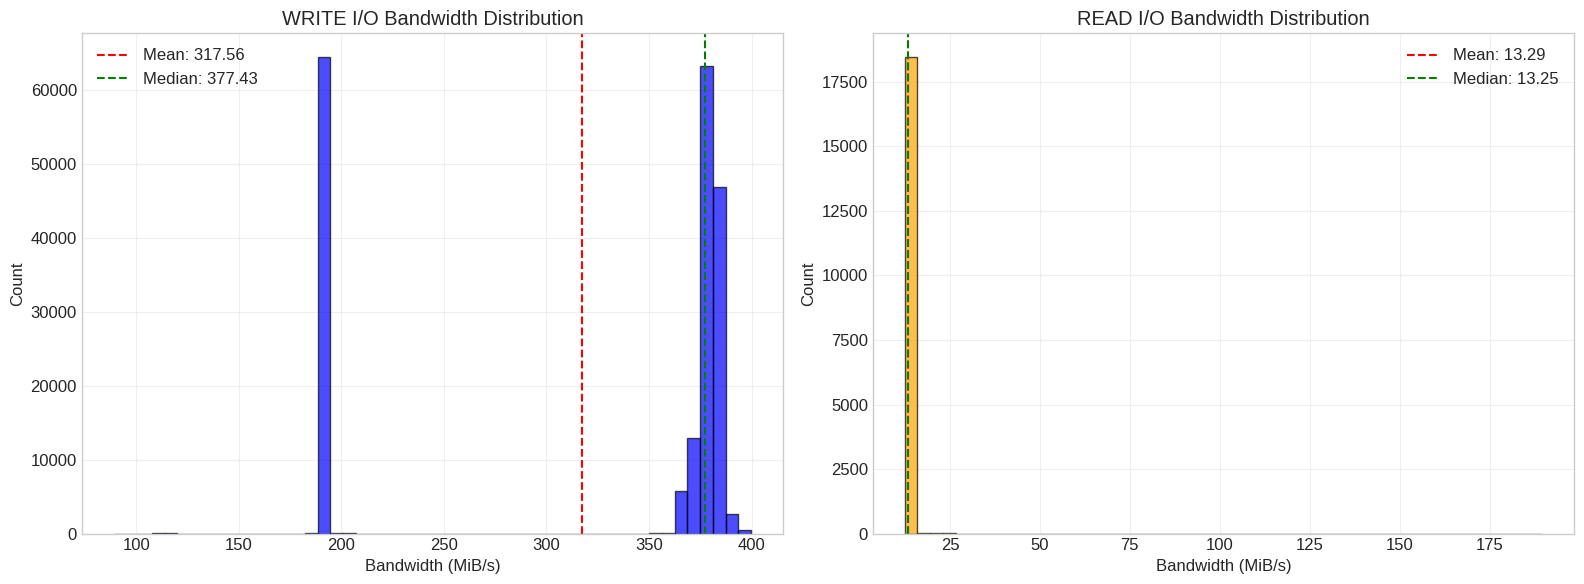


WRITE: count=196,608, mean_bw=317.56 MiB/s
READ:  count=18,495, mean_bw=13.29 MiB/s


In [14]:
# Bandwidth distribution
if df_timing is not None:
    df_timing_write = df_timing[df_timing['op'] == 'WRITE']
    df_timing_read = df_timing[df_timing['op'] == 'READ']

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    ax = axes[0]
    if len(df_timing_write) > 0:
        ax.hist(df_timing_write['bandwidth_mib_s'], bins=50, alpha=0.7, color='blue', edgecolor='black')
        ax.axvline(df_timing_write['bandwidth_mib_s'].mean(), color='red', linestyle='--', label=f"Mean: {df_timing_write['bandwidth_mib_s'].mean():.2f}")
        ax.axvline(df_timing_write['bandwidth_mib_s'].median(), color='green', linestyle='--', label=f"Median: {df_timing_write['bandwidth_mib_s'].median():.2f}")
    ax.set_xlabel('Bandwidth (MiB/s)')
    ax.set_ylabel('Count')
    ax.set_title('WRITE I/O Bandwidth Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    if len(df_timing_read) > 0:
        ax.hist(df_timing_read['bandwidth_mib_s'], bins=50, alpha=0.7, color='orange', edgecolor='black')
        ax.axvline(df_timing_read['bandwidth_mib_s'].mean(), color='red', linestyle='--', label=f"Mean: {df_timing_read['bandwidth_mib_s'].mean():.2f}")
        ax.axvline(df_timing_read['bandwidth_mib_s'].median(), color='green', linestyle='--', label=f"Median: {df_timing_read['bandwidth_mib_s'].median():.2f}")
    ax.set_xlabel('Bandwidth (MiB/s)')
    ax.set_ylabel('Count')
    ax.set_title('READ I/O Bandwidth Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'io_timing_bandwidth_distribution.png', dpi=150)
    plt.show()

    print(f"\nWRITE: count={len(df_timing_write):,}, mean_bw={df_timing_write['bandwidth_mib_s'].mean():.2f} MiB/s")
    print(f"READ:  count={len(df_timing_read):,}, mean_bw={df_timing_read['bandwidth_mib_s'].mean():.2f} MiB/s")

## 2.2 Bandwidth Over Time (All Nodes Combined)

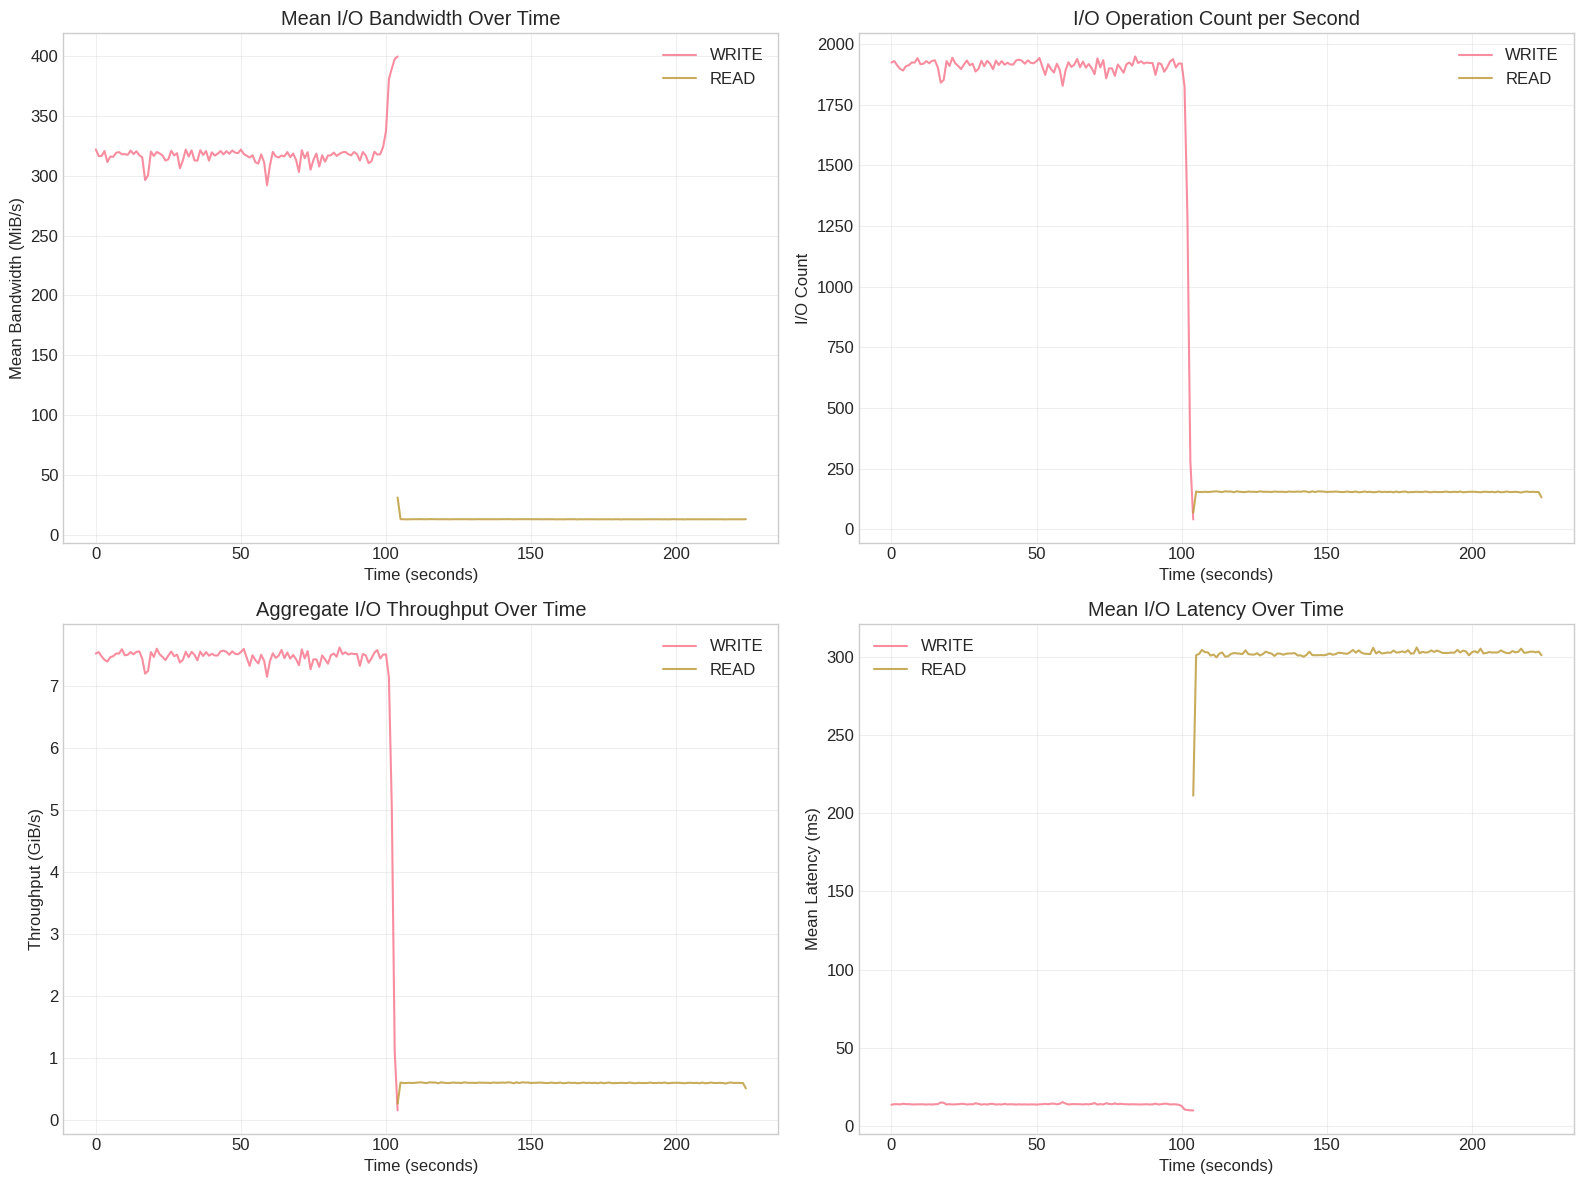

In [15]:
# Bandwidth and latency over time
if df_timing is not None:
    time_stats = df_timing.groupby(['time_bucket', 'op']).agg({
        'bandwidth_mib_s': ['mean', 'median', 'min', 'max', 'count'],
        'elapsed_ms': ['mean', 'median'],
        'bytes': 'sum'
    }).reset_index()
    time_stats.columns = ['time', 'op', 'bw_mean', 'bw_median', 'bw_min', 'bw_max', 'io_count', 'latency_mean', 'latency_median', 'total_bytes']
    time_stats['throughput_gib_s'] = time_stats['total_bytes'] / (1024**3)

    write_stats = time_stats[time_stats['op'] == 'WRITE']
    read_stats = time_stats[time_stats['op'] == 'READ']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    ax = axes[0, 0]
    if len(write_stats) > 0:
        ax.plot(write_stats['time'], write_stats['bw_mean'], label='WRITE', linewidth=1.5, alpha=0.8)
    if len(read_stats) > 0:
        ax.plot(read_stats['time'], read_stats['bw_mean'], label='READ', linewidth=1.5, alpha=0.8)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Mean Bandwidth (MiB/s)')
    ax.set_title('Mean I/O Bandwidth Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[0, 1]
    if len(write_stats) > 0:
        ax.plot(write_stats['time'], write_stats['io_count'], label='WRITE', linewidth=1.5, alpha=0.8)
    if len(read_stats) > 0:
        ax.plot(read_stats['time'], read_stats['io_count'], label='READ', linewidth=1.5, alpha=0.8)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('I/O Count')
    ax.set_title('I/O Operation Count per Second')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1, 0]
    if len(write_stats) > 0:
        ax.plot(write_stats['time'], write_stats['throughput_gib_s'], label='WRITE', linewidth=1.5, alpha=0.8)
    if len(read_stats) > 0:
        ax.plot(read_stats['time'], read_stats['throughput_gib_s'], label='READ', linewidth=1.5, alpha=0.8)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Throughput (GiB/s)')
    ax.set_title('Aggregate I/O Throughput Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1, 1]
    if len(write_stats) > 0:
        ax.plot(write_stats['time'], write_stats['latency_mean'], label='WRITE', linewidth=1.5, alpha=0.8)
    if len(read_stats) > 0:
        ax.plot(read_stats['time'], read_stats['latency_mean'], label='READ', linewidth=1.5, alpha=0.8)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Mean Latency (ms)')
    ax.set_title('Mean I/O Latency Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'io_timing_over_time.png', dpi=150)
    plt.show()

## 2.3 Per-Node Bandwidth Over Time

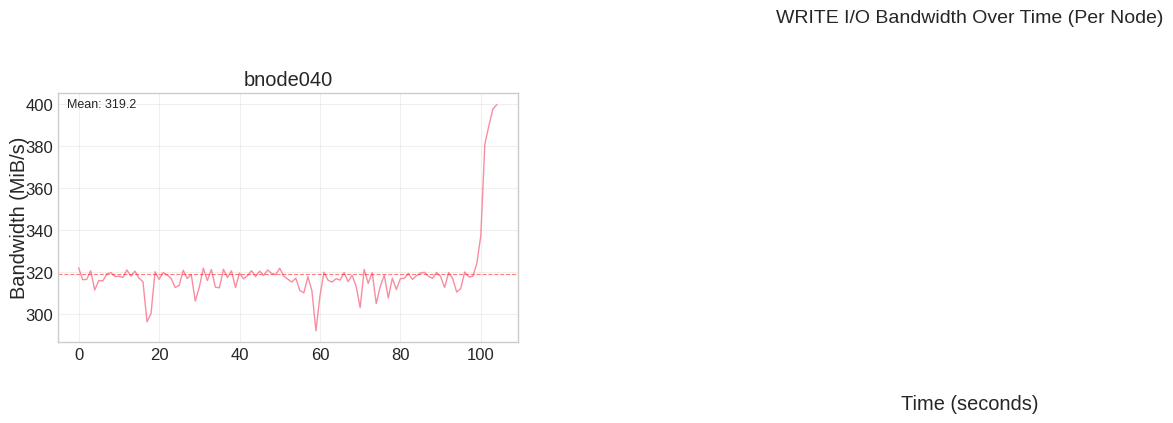

In [16]:
# Per-node bandwidth over time helper function
def plot_per_node_bandwidth(data, op_name, filename):
    if len(data) == 0:
        print(f"No {op_name} data")
        return
    
    # Aggregate by time bucket and node
    node_time_stats = data.groupby(['time_bucket', 'node']).agg({
        'bandwidth_mib_s': 'mean',
        'bytes': 'sum'
    }).reset_index()
    node_time_stats['throughput_gib_s'] = node_time_stats['bytes'] / (1024**3)
    
    nodes = sorted(data['node'].unique())
    n_nodes = len(nodes)
    
    # Calculate grid size
    n_cols = 4
    n_rows = (n_nodes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, node in enumerate(nodes):
        ax = axes[i]
        node_data = node_time_stats[node_time_stats['node'] == node]
        
        ax.plot(node_data['time_bucket'], node_data['bandwidth_mib_s'], linewidth=1, alpha=0.8)
        ax.set_title(f'{node}')
        ax.grid(True, alpha=0.3)
        
        # Add mean line
        mean_bw = node_data['bandwidth_mib_s'].mean()
        ax.axhline(y=mean_bw, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
        ax.text(0.02, 0.98, f'Mean: {mean_bw:.1f}', transform=ax.transAxes, fontsize=9, va='top')
    
    # Hide unused subplots
    for i in range(n_nodes, len(axes)):
        axes[i].set_visible(False)
    
    fig.suptitle(f'{op_name} I/O Bandwidth Over Time (Per Node)', fontsize=14, y=1.02)
    fig.supxlabel('Time (seconds)')
    fig.supylabel('Bandwidth (MiB/s)')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

if df_timing is not None:
    df_timing_write = df_timing[df_timing['op'] == 'WRITE']
    df_timing_read = df_timing[df_timing['op'] == 'READ']
    plot_per_node_bandwidth(df_timing_write, 'WRITE', 'io_timing_write_per_node.png')

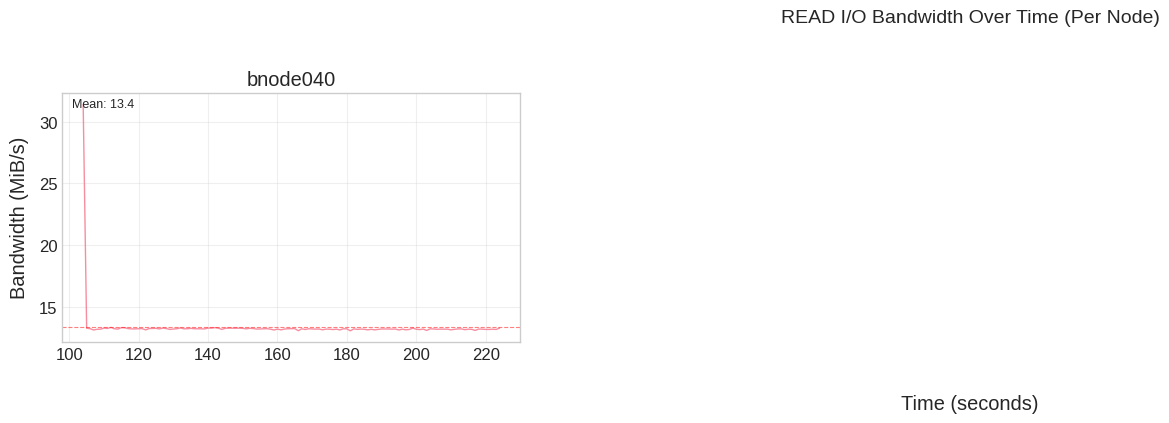

In [17]:
# READ per-node bandwidth
if df_timing is not None:
    df_timing_read = df_timing[df_timing['op'] == 'READ']
    plot_per_node_bandwidth(df_timing_read, 'READ', 'io_timing_read_per_node.png')

## 2.4 Per-Node Throughput Over Time

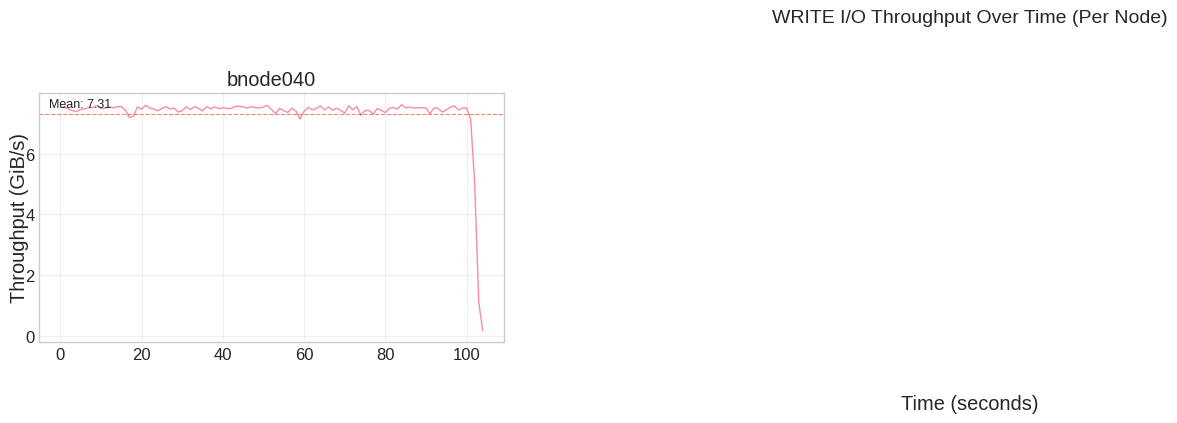

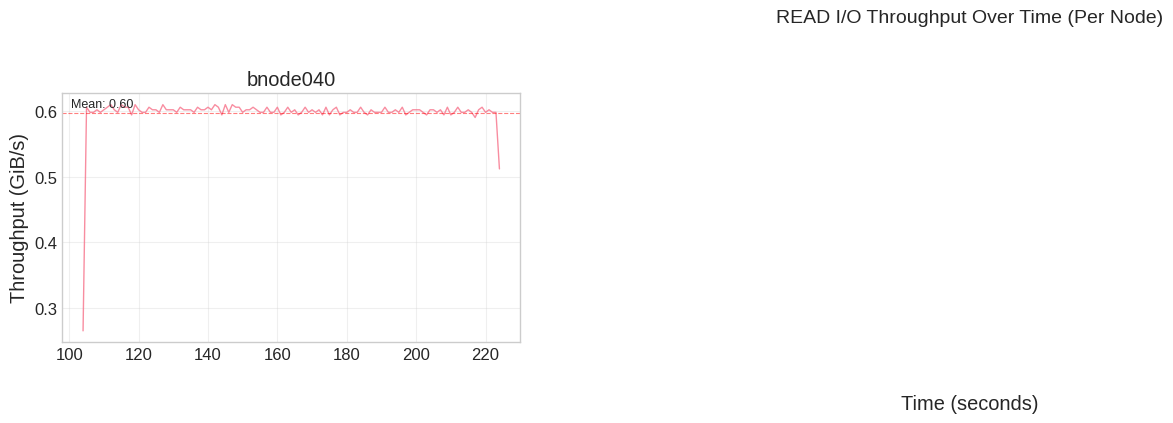

In [18]:
def plot_per_node_throughput(data, op_name, filename):
    if len(data) == 0:
        print(f"No {op_name} data")
        return
    
    # Aggregate by time bucket and node
    node_time_stats = data.groupby(['time_bucket', 'node']).agg({
        'bytes': 'sum',
        'bandwidth_mib_s': 'count'
    }).reset_index()
    node_time_stats.columns = ['time_bucket', 'node', 'total_bytes', 'io_count']
    node_time_stats['throughput_gib_s'] = node_time_stats['total_bytes'] / (1024**3)
    
    nodes = sorted(data['node'].unique())
    n_nodes = len(nodes)
    
    n_cols = 4
    n_rows = (n_nodes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, node in enumerate(nodes):
        ax = axes[i]
        node_data = node_time_stats[node_time_stats['node'] == node]
        
        ax.plot(node_data['time_bucket'], node_data['throughput_gib_s'], linewidth=1, alpha=0.8)
        ax.set_title(f'{node}')
        ax.grid(True, alpha=0.3)
        
        mean_tp = node_data['throughput_gib_s'].mean()
        ax.axhline(y=mean_tp, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
        ax.text(0.02, 0.98, f'Mean: {mean_tp:.2f}', transform=ax.transAxes, fontsize=9, va='top')
    
    for i in range(n_nodes, len(axes)):
        axes[i].set_visible(False)
    
    fig.suptitle(f'{op_name} I/O Throughput Over Time (Per Node)', fontsize=14, y=1.02)
    fig.supxlabel('Time (seconds)')
    fig.supylabel('Throughput (GiB/s)')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

if df_timing is not None:
    df_timing_write = df_timing[df_timing['op'] == 'WRITE']
    df_timing_read = df_timing[df_timing['op'] == 'READ']
    plot_per_node_throughput(df_timing_write, 'WRITE', 'io_timing_write_throughput_per_node.png')
    plot_per_node_throughput(df_timing_read, 'READ', 'io_timing_read_throughput_per_node.png')

## 2.5 Per-Node I/O Count Over Time

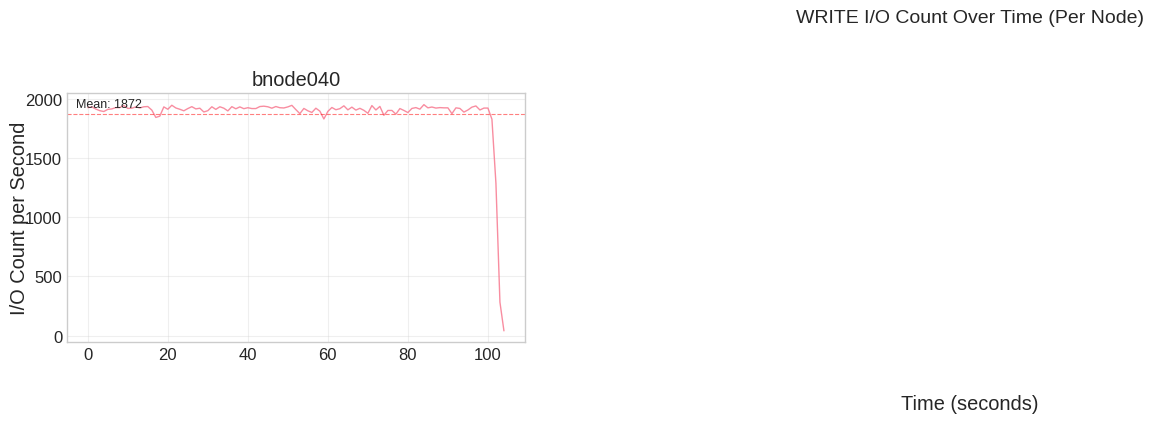

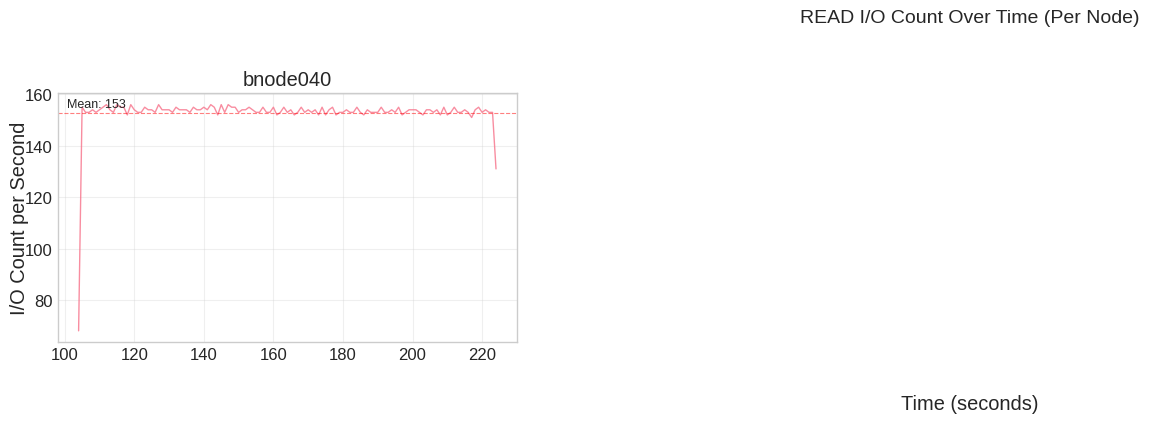

In [19]:
def plot_per_node_io_count(data, op_name, filename):
    if len(data) == 0:
        print(f"No {op_name} data")
        return
    
    # Aggregate by time bucket and node
    node_time_stats = data.groupby(['time_bucket', 'node']).size().reset_index(name='io_count')
    
    nodes = sorted(data['node'].unique())
    n_nodes = len(nodes)
    
    n_cols = 4
    n_rows = (n_nodes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, node in enumerate(nodes):
        ax = axes[i]
        node_data = node_time_stats[node_time_stats['node'] == node]
        
        ax.plot(node_data['time_bucket'], node_data['io_count'], linewidth=1, alpha=0.8)
        ax.set_title(f'{node}')
        ax.grid(True, alpha=0.3)
        
        mean_cnt = node_data['io_count'].mean()
        ax.axhline(y=mean_cnt, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
        ax.text(0.02, 0.98, f'Mean: {mean_cnt:.0f}', transform=ax.transAxes, fontsize=9, va='top')
    
    for i in range(n_nodes, len(axes)):
        axes[i].set_visible(False)
    
    fig.suptitle(f'{op_name} I/O Count Over Time (Per Node)', fontsize=14, y=1.02)
    fig.supxlabel('Time (seconds)')
    fig.supylabel('I/O Count per Second')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

if df_timing is not None:
    df_timing_write = df_timing[df_timing['op'] == 'WRITE']
    df_timing_read = df_timing[df_timing['op'] == 'READ']
    plot_per_node_io_count(df_timing_write, 'WRITE', 'io_timing_write_count_per_node.png')
    plot_per_node_io_count(df_timing_read, 'READ', 'io_timing_read_count_per_node.png')

## 2.6 Per-Node Statistics Summary

In [20]:
# Per-node summary statistics
if df_timing is not None:
    node_stats = df_timing.groupby(['node', 'op']).agg({
        'bandwidth_mib_s': ['mean', 'median', 'std', 'min', 'max', 'count'],
        'elapsed_ms': ['mean', 'median'],
        'bytes': 'sum'
    }).reset_index()
    node_stats.columns = ['node', 'op', 'bw_mean', 'bw_median', 'bw_std', 'bw_min', 'bw_max', 'count', 'latency_mean', 'latency_median', 'total_bytes']
    node_stats['total_gib'] = node_stats['total_bytes'] / (1024**3)

    print("=== WRITE per Node ===")
    write_node_stats = node_stats[node_stats['op'] == 'WRITE'].sort_values('node')
    print(write_node_stats[['node', 'count', 'total_gib', 'bw_mean', 'bw_median', 'latency_mean']].to_string(index=False))

    print("\n=== READ per Node ===")
    read_node_stats = node_stats[node_stats['op'] == 'READ'].sort_values('node')
    print(read_node_stats[['node', 'count', 'total_gib', 'bw_mean', 'bw_median', 'latency_mean']].to_string(index=False))

=== WRITE per Node ===
    node  count  total_gib    bw_mean  bw_median  latency_mean
bnode040 196608      768.0 317.563109     377.43     13.956932

=== READ per Node ===
    node  count  total_gib   bw_mean  bw_median  latency_mean
bnode040  18495  72.246094 13.291095      13.25     302.19101


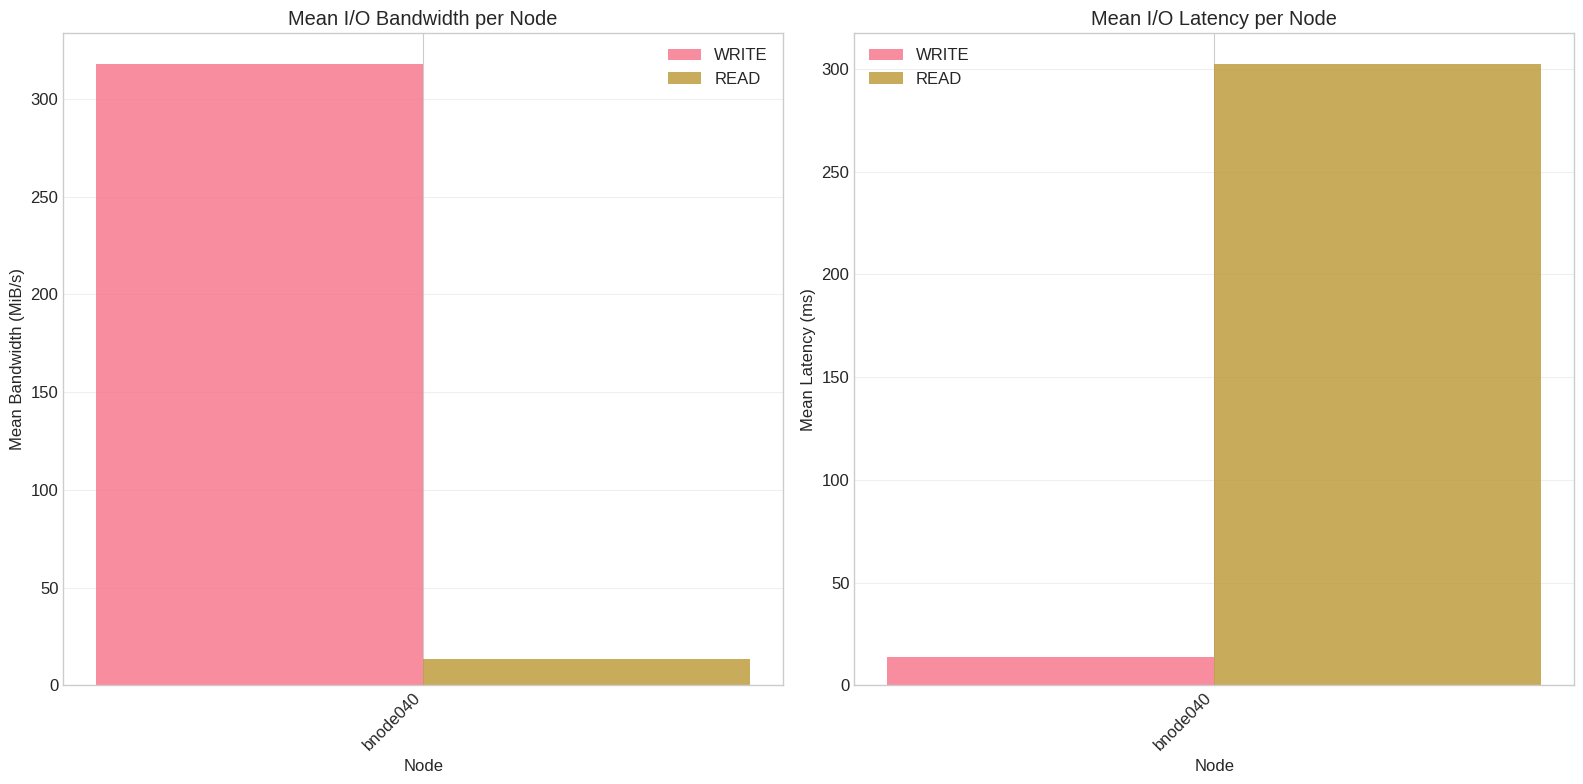

In [21]:
# Bar chart comparison
if df_timing is not None:
    node_stats = df_timing.groupby(['node', 'op']).agg({
        'bandwidth_mib_s': 'mean',
        'elapsed_ms': 'mean'
    }).reset_index()
    node_stats.columns = ['node', 'op', 'bw_mean', 'latency_mean']
    
    write_node_stats = node_stats[node_stats['op'] == 'WRITE'].sort_values('node')
    read_node_stats = node_stats[node_stats['op'] == 'READ'].sort_values('node')
    
    # Get all unique nodes and sort them
    all_nodes = sorted(set(write_node_stats['node'].tolist() + read_node_stats['node'].tolist()))
    
    # Create aligned data with NaN for missing values
    write_bw = []
    write_latency = []
    read_bw = []
    read_latency = []
    
    for node in all_nodes:
        w_row = write_node_stats[write_node_stats['node'] == node]
        r_row = read_node_stats[read_node_stats['node'] == node]
        
        write_bw.append(w_row['bw_mean'].values[0] if len(w_row) > 0 else np.nan)
        write_latency.append(w_row['latency_mean'].values[0] if len(w_row) > 0 else np.nan)
        read_bw.append(r_row['bw_mean'].values[0] if len(r_row) > 0 else np.nan)
        read_latency.append(r_row['latency_mean'].values[0] if len(r_row) > 0 else np.nan)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Mean bandwidth per node
    ax = axes[0]
    x = np.arange(len(all_nodes))
    width = 0.35

    ax.bar(x - width/2, write_bw, width, label='WRITE', alpha=0.8)
    ax.bar(x + width/2, read_bw, width, label='READ', alpha=0.8)

    ax.set_xticks(x)
    ax.set_xticklabels(all_nodes, rotation=45, ha='right')
    ax.set_xlabel('Node')
    ax.set_ylabel('Mean Bandwidth (MiB/s)')
    ax.set_title('Mean I/O Bandwidth per Node')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Mean latency per node
    ax = axes[1]
    ax.bar(x - width/2, write_latency, width, label='WRITE', alpha=0.8)
    ax.bar(x + width/2, read_latency, width, label='READ', alpha=0.8)

    ax.set_xticks(x)
    ax.set_xticklabels(all_nodes, rotation=45, ha='right')
    ax.set_xlabel('Node')
    ax.set_ylabel('Mean Latency (ms)')
    ax.set_title('Mean I/O Latency per Node')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'io_timing_per_node_summary.png', dpi=150)
    plt.show()

## 2.7 Comparison: WRITE vs READ

In [22]:
# I/O timing comparison
if df_timing is not None:
    print("=" * 80)
    print("I/O Timing Comparison: WRITE vs READ")
    print("=" * 80)

    df_timing_write = df_timing[df_timing['op'] == 'WRITE']
    df_timing_read = df_timing[df_timing['op'] == 'READ']

    if len(df_timing_write) > 0:
        print(f"\nWRITE:")
        print(f"  Total I/O count: {len(df_timing_write):,}")
        print(f"  Total bytes: {df_timing_write['bytes'].sum() / (1024**3):.2f} GiB")
        print(f"  Mean bandwidth: {df_timing_write['bandwidth_mib_s'].mean():.2f} MiB/s")
        print(f"  Mean latency: {df_timing_write['elapsed_ms'].mean():.2f} ms")
        print(f"  P50 latency: {df_timing_write['elapsed_ms'].quantile(0.50):.2f} ms")
        print(f"  P99 latency: {df_timing_write['elapsed_ms'].quantile(0.99):.2f} ms")

    if len(df_timing_read) > 0:
        print(f"\nREAD:")
        print(f"  Total I/O count: {len(df_timing_read):,}")
        print(f"  Total bytes: {df_timing_read['bytes'].sum() / (1024**3):.2f} GiB")
        print(f"  Mean bandwidth: {df_timing_read['bandwidth_mib_s'].mean():.2f} MiB/s")
        print(f"  Mean latency: {df_timing_read['elapsed_ms'].mean():.2f} ms")
        print(f"  P50 latency: {df_timing_read['elapsed_ms'].quantile(0.50):.2f} ms")
        print(f"  P99 latency: {df_timing_read['elapsed_ms'].quantile(0.99):.2f} ms")

    if len(df_timing_write) > 0 and len(df_timing_read) > 0:
        print(f"\nComparison:")
        print(f"  I/O count ratio (WRITE/READ): {len(df_timing_write)/len(df_timing_read):.2f}x")
        print(f"  Bandwidth ratio (WRITE/READ): {df_timing_write['bandwidth_mib_s'].mean()/df_timing_read['bandwidth_mib_s'].mean():.2f}x")
        print(f"  Latency ratio (READ/WRITE): {df_timing_read['elapsed_ms'].mean()/df_timing_write['elapsed_ms'].mean():.2f}x")
        
        if df_timing_read['bandwidth_mib_s'].mean() < df_timing_write['bandwidth_mib_s'].mean() * 0.5:
            print("\n*** WARNING: READ bandwidth is significantly lower than WRITE ***")
            print("This suggests disk I/O is a bottleneck for READ operations.")

I/O Timing Comparison: WRITE vs READ

WRITE:
  Total I/O count: 196,608
  Total bytes: 768.00 GiB
  Mean bandwidth: 317.56 MiB/s
  Mean latency: 13.96 ms
  P50 latency: 10.60 ms
  P99 latency: 21.05 ms

READ:
  Total I/O count: 18,495
  Total bytes: 72.25 GiB
  Mean bandwidth: 13.29 MiB/s
  Mean latency: 302.19 ms
  P50 latency: 301.99 ms
  P99 latency: 313.08 ms

Comparison:
  I/O count ratio (WRITE/READ): 10.63x
  Bandwidth ratio (WRITE/READ): 23.89x
  Latency ratio (READ/WRITE): 21.65x

*** WARNING: READ bandwidth is significantly lower than WRITE ***
This suggests disk I/O is a bottleneck for READ operations.


---
# Part 3: Node Transfer Analysis

Analyzes load distribution across nodes over time.

## Data Source
- `node_transfer_aggregated.csv`: Aggregated transfer data per second, per client, per target node

In [23]:
# Load node transfer data
df_transfer = load_csv_if_exists(RESULTS_DIR / 'node_transfer_aggregated.csv', 'node_transfer_aggregated.csv')

if df_transfer is not None:
    df_transfer['time_relative'] = df_transfer['time_bucket'] - df_transfer['time_bucket'].min()
    df_transfer['total_gib'] = df_transfer['total_bytes'] / (1024**3)
    
    print(f"\nTime range: {df_transfer['time_bucket'].min()} - {df_transfer['time_bucket'].max()} (duration: {df_transfer['time_relative'].max()}s)")
    print(f"Operations: {df_transfer['op'].unique()}")
    print(f"Target nodes: {sorted(df_transfer['target_node'].unique())}")
    print(f"Client nodes: {sorted(df_transfer['client_node'].unique())}")

Loaded node_transfer_aggregated.csv: 226 records

Time range: 82314 - 82538 (duration: 224s)
Operations: ['WRITE' 'READ']
Target nodes: ['node_0']
Client nodes: ['bnode041']


## 3.1 Overall Throughput Over Time

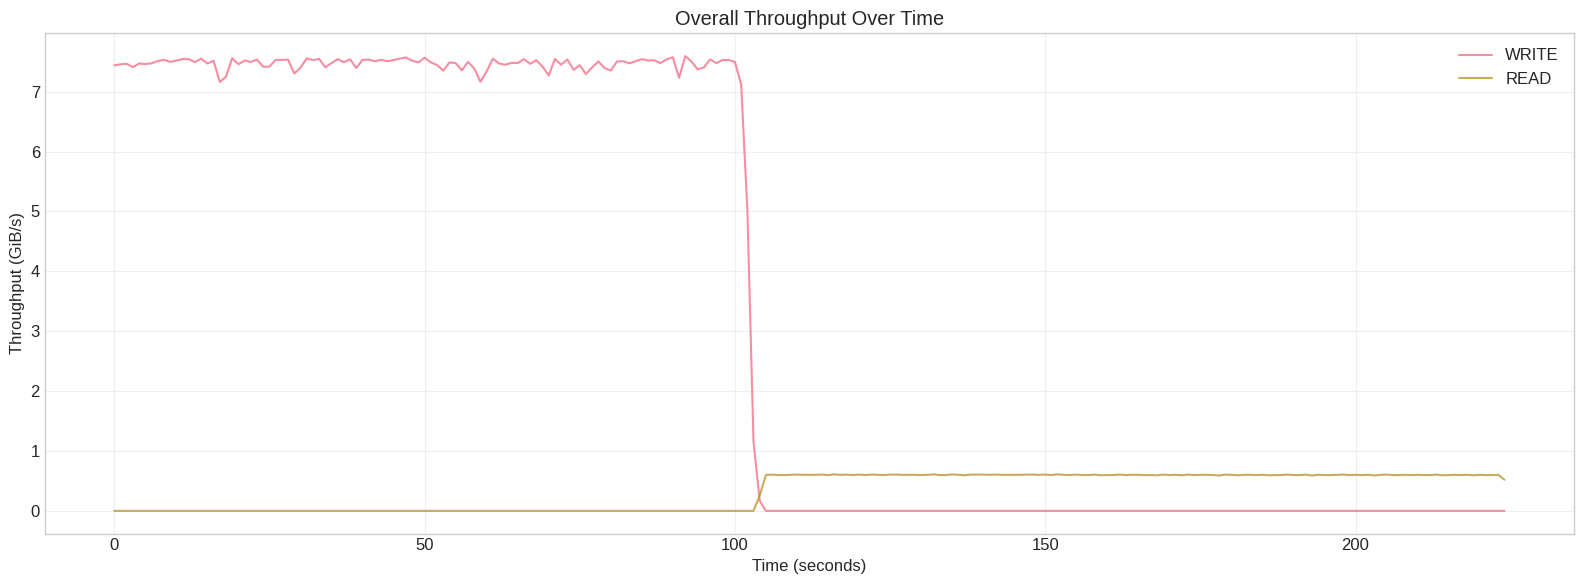

In [24]:
# Overall throughput over time
if df_transfer is not None:
    throughput_by_time = df_transfer.groupby(['time_relative', 'op'])['total_gib'].sum().unstack(fill_value=0)

    fig, ax = plt.subplots(figsize=(16, 6))

    if 'WRITE' in throughput_by_time.columns:
        ax.plot(throughput_by_time.index, throughput_by_time['WRITE'], label='WRITE', linewidth=1.5, alpha=0.8)
    if 'READ' in throughput_by_time.columns:
        ax.plot(throughput_by_time.index, throughput_by_time['READ'], label='READ', linewidth=1.5, alpha=0.8)

    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Throughput (GiB/s)')
    ax.set_title('Overall Throughput Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'throughput_over_time.png', dpi=150)
    plt.show()

## 3.2 Per-Target-Node Throughput Over Time

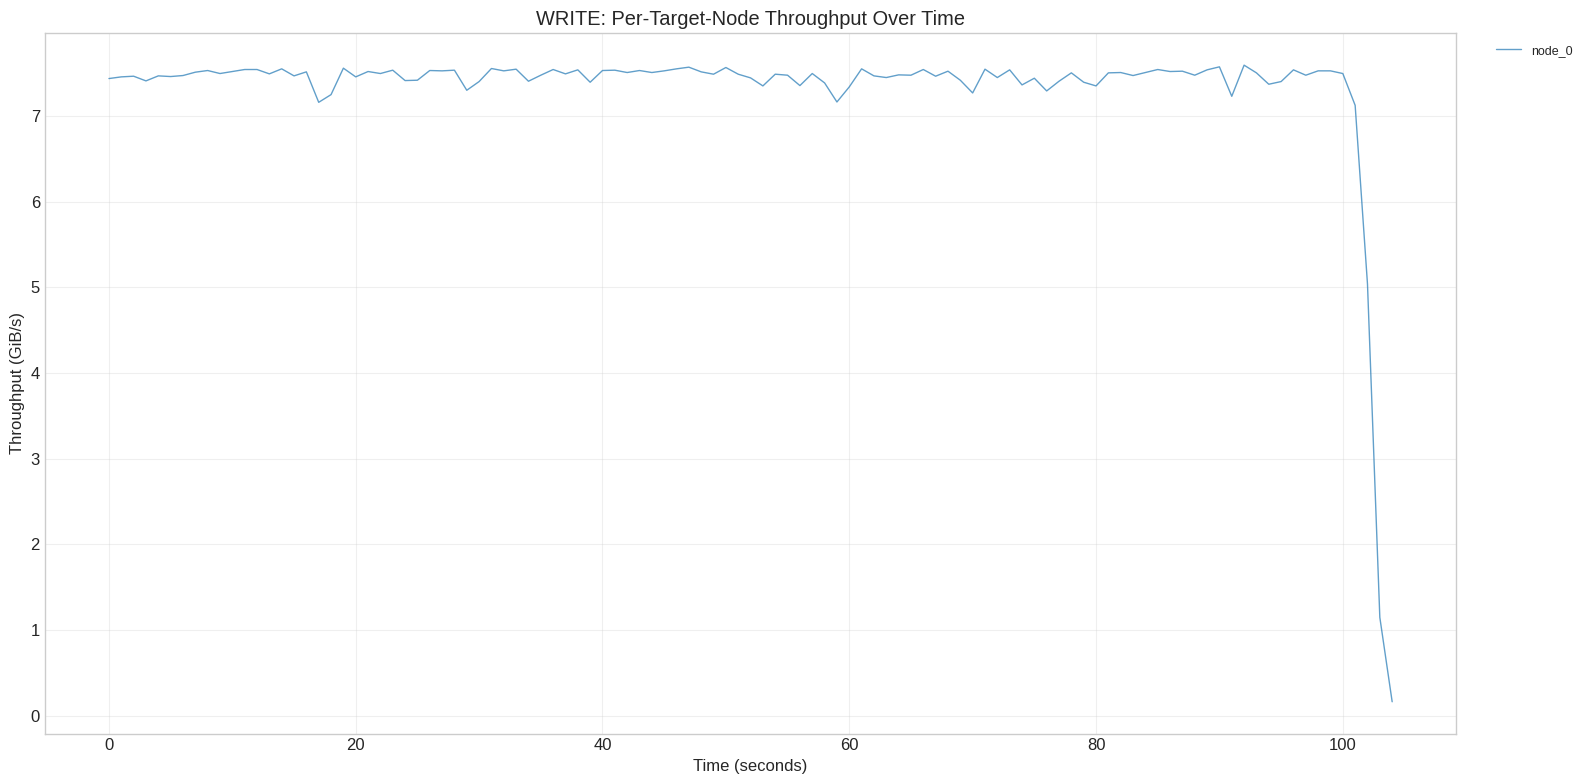

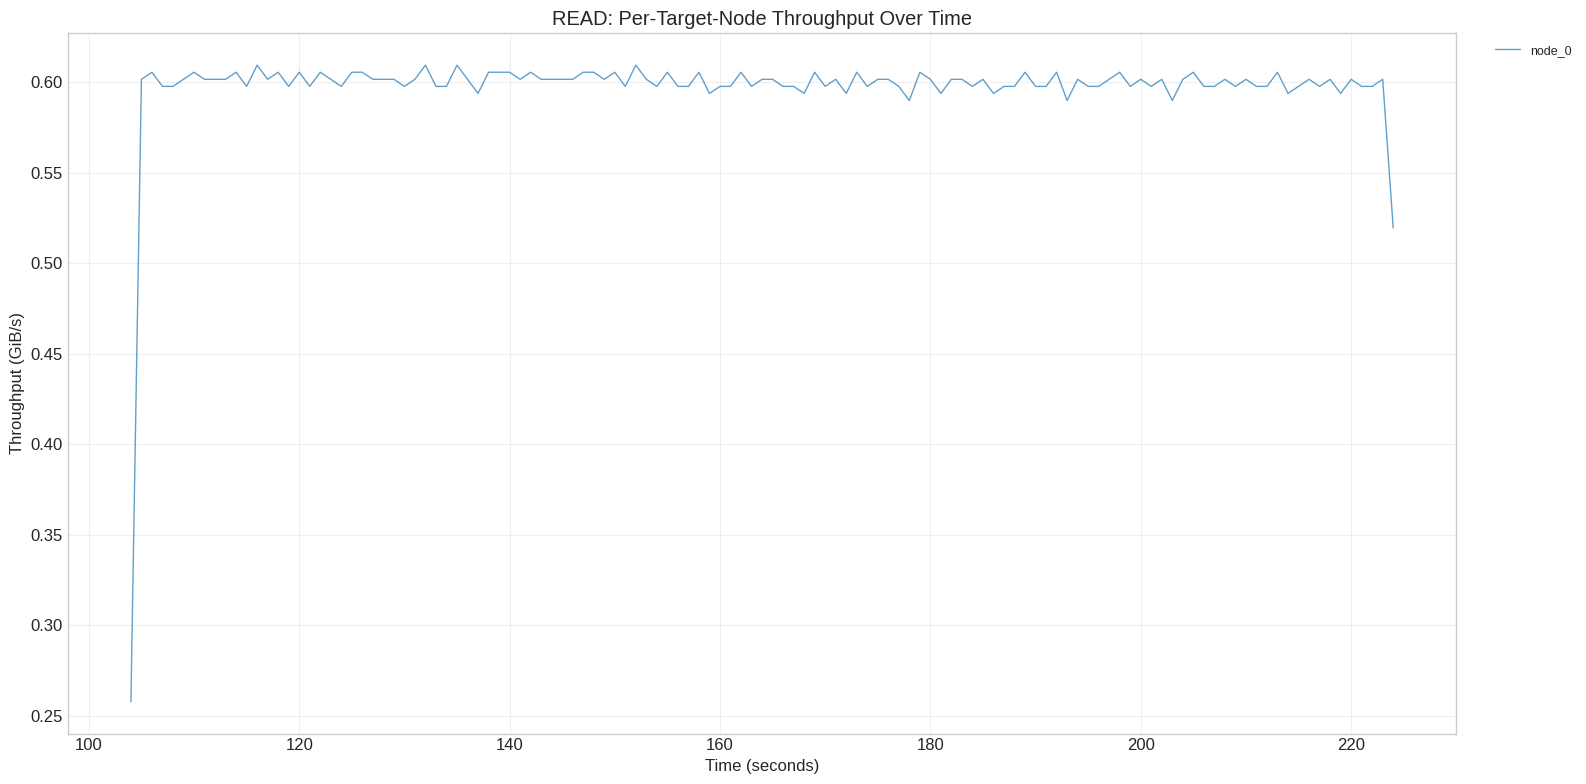

In [25]:
def plot_per_target_node_throughput(data, title, filename):
    """Plot throughput per target node over time"""
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    # Aggregate by time and target node
    node_throughput = data.groupby(['time_relative', 'target_node'])['total_gib'].sum().unstack(fill_value=0)
    
    # Sort columns naturally (node_0, node_1, ..., node_15)
    sorted_cols = sorted(node_throughput.columns, key=lambda x: int(x.split('_')[1]) if '_' in x else x)
    node_throughput = node_throughput[sorted_cols]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(node_throughput.columns)))
    
    for i, col in enumerate(node_throughput.columns):
        ax.plot(node_throughput.index, node_throughput[col], 
                label=col, linewidth=1, alpha=0.7, color=colors[i])
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Throughput (GiB/s)')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

if df_transfer is not None:
    df_transfer_write = df_transfer[df_transfer['op'] == 'WRITE']
    df_transfer_read = df_transfer[df_transfer['op'] == 'READ']
    
    plot_per_target_node_throughput(df_transfer_write, 'WRITE: Per-Target-Node Throughput Over Time', 'write_per_node_throughput.png')
    plot_per_target_node_throughput(df_transfer_read, 'READ: Per-Target-Node Throughput Over Time', 'read_per_node_throughput.png')

## 3.3 Stacked Area Chart - Load Distribution

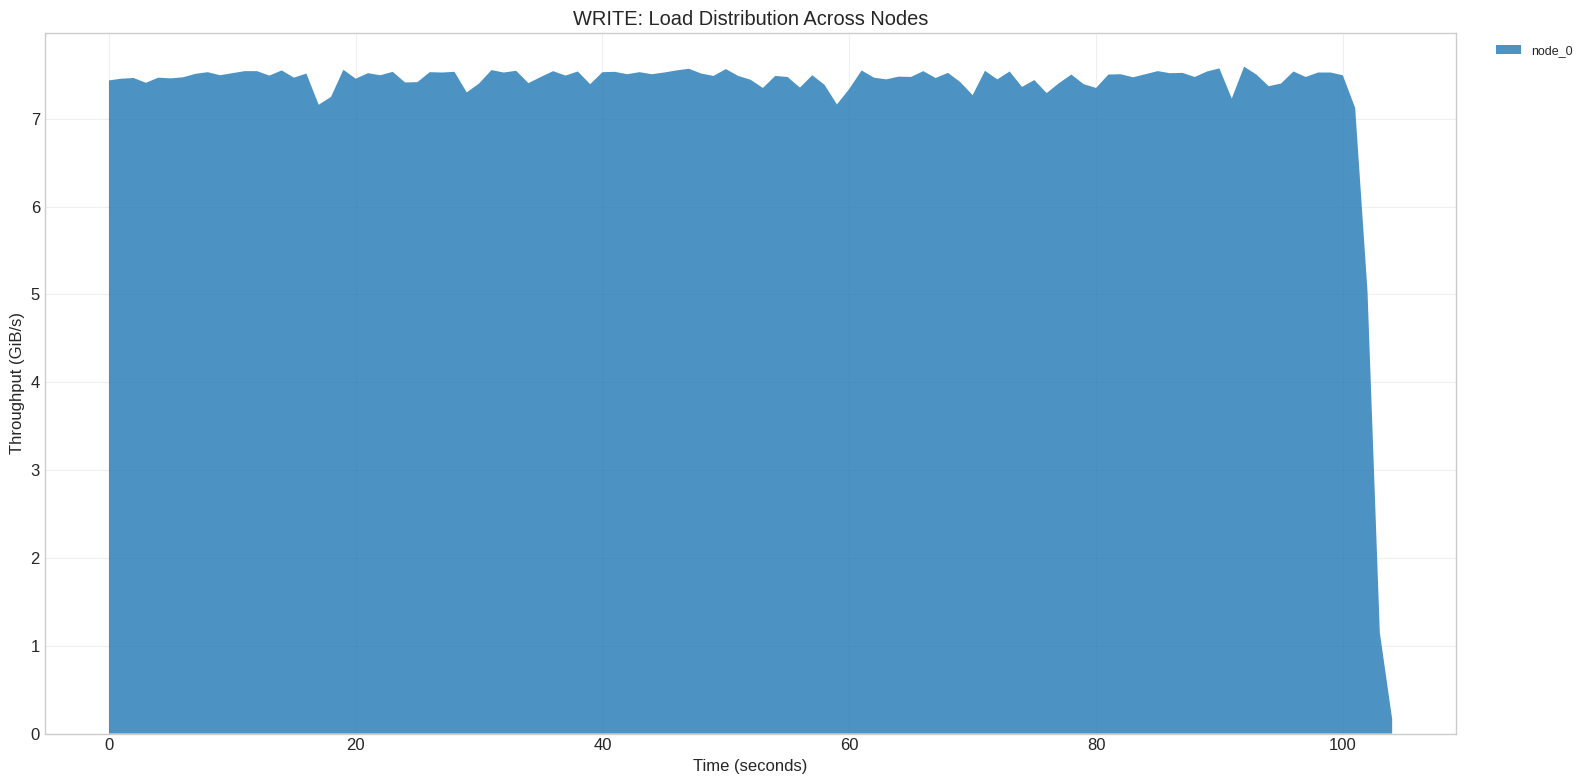

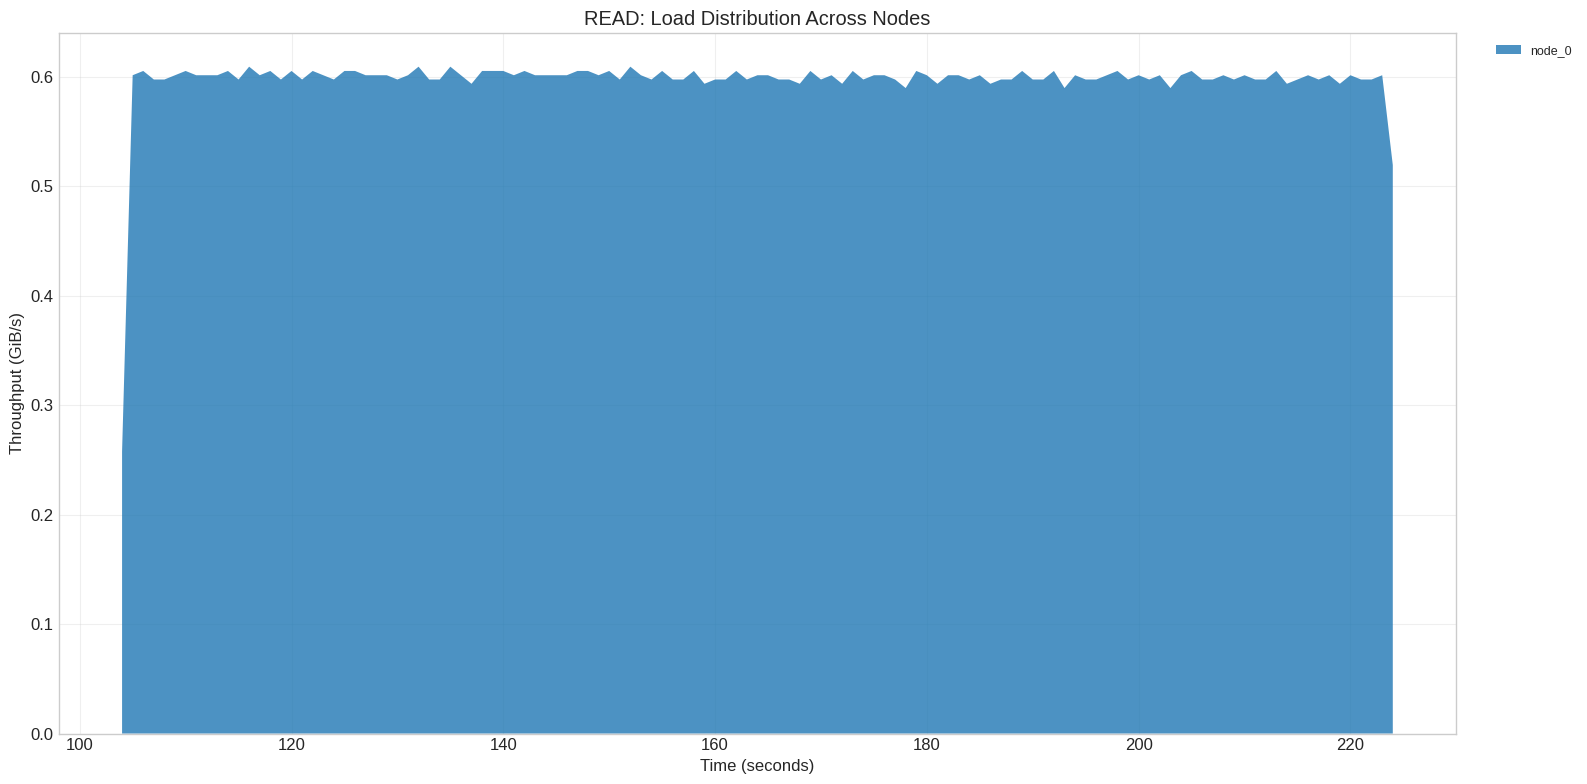

In [26]:
def plot_stacked_area(data, title, filename):
    """Plot stacked area chart showing load distribution"""
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    # Aggregate by time and target node
    node_throughput = data.groupby(['time_relative', 'target_node'])['total_gib'].sum().unstack(fill_value=0)
    
    # Sort columns naturally
    sorted_cols = sorted(node_throughput.columns, key=lambda x: int(x.split('_')[1]) if '_' in x else x)
    node_throughput = node_throughput[sorted_cols]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(node_throughput.columns)))
    
    ax.stackplot(node_throughput.index, 
                 [node_throughput[col] for col in node_throughput.columns],
                 labels=node_throughput.columns,
                 colors=colors,
                 alpha=0.8)
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Throughput (GiB/s)')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

if df_transfer is not None:
    df_transfer_write = df_transfer[df_transfer['op'] == 'WRITE']
    df_transfer_read = df_transfer[df_transfer['op'] == 'READ']
    
    plot_stacked_area(df_transfer_write, 'WRITE: Load Distribution Across Nodes', 'write_load_distribution.png')
    plot_stacked_area(df_transfer_read, 'READ: Load Distribution Across Nodes', 'read_load_distribution.png')

## 3.4 Per-Client-Node Throughput

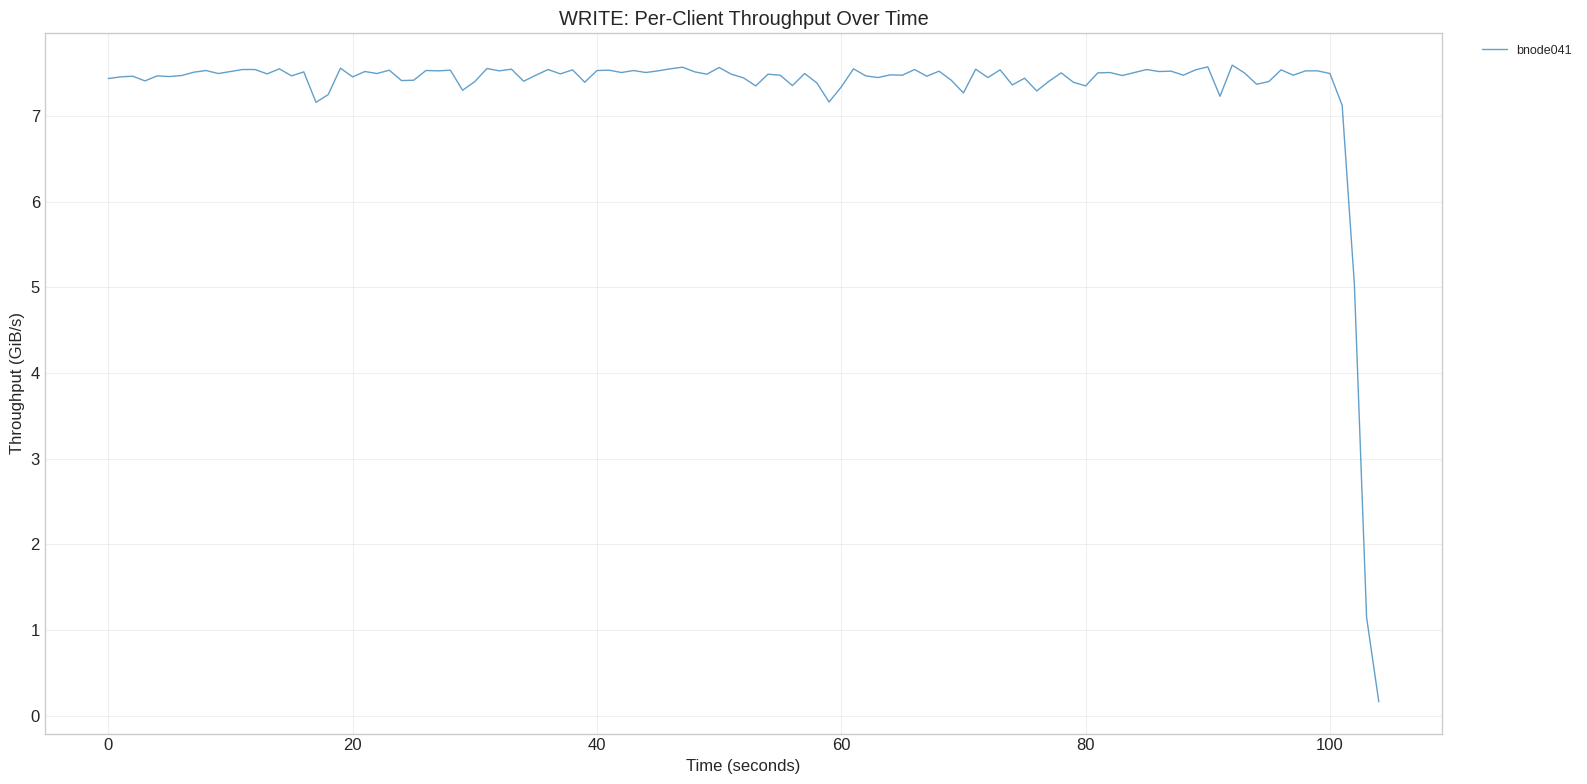

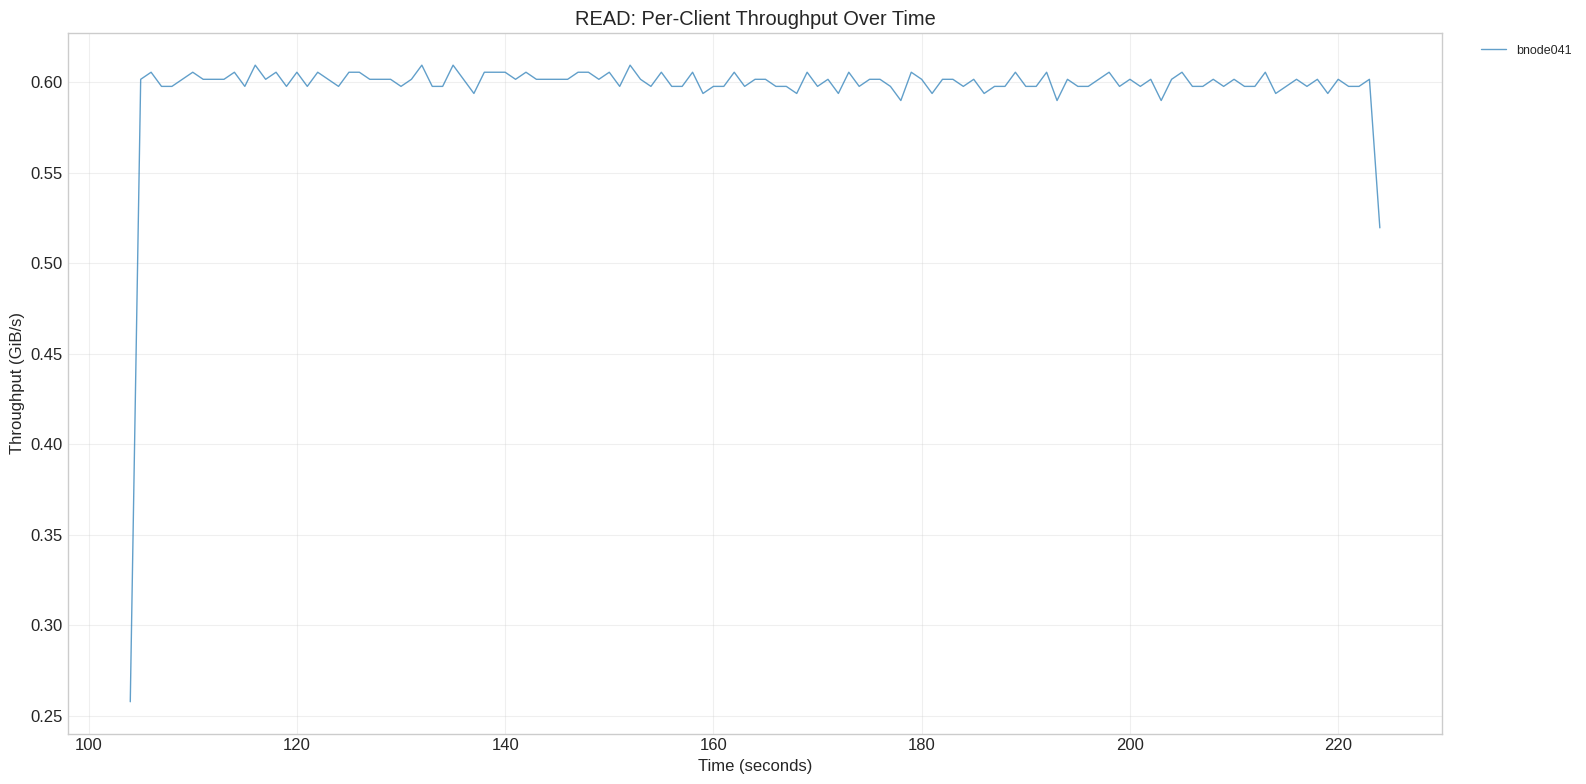

In [27]:
def plot_per_client_throughput(data, title, filename):
    """Plot throughput per client node over time"""
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    # Aggregate by time and client node
    client_throughput = data.groupby(['time_relative', 'client_node'])['total_gib'].sum().unstack(fill_value=0)
    
    # Sort columns
    sorted_cols = sorted(client_throughput.columns)
    client_throughput = client_throughput[sorted_cols]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(client_throughput.columns)))
    
    for i, col in enumerate(client_throughput.columns):
        ax.plot(client_throughput.index, client_throughput[col], 
                label=col, linewidth=1, alpha=0.7, color=colors[i])
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Throughput (GiB/s)')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

if df_transfer is not None:
    df_transfer_write = df_transfer[df_transfer['op'] == 'WRITE']
    df_transfer_read = df_transfer[df_transfer['op'] == 'READ']
    
    plot_per_client_throughput(df_transfer_write, 'WRITE: Per-Client Throughput Over Time', 'write_per_client_throughput.png')
    plot_per_client_throughput(df_transfer_read, 'READ: Per-Client Throughput Over Time', 'read_per_client_throughput.png')

## 3.5 Heatmap - Node Load Over Time

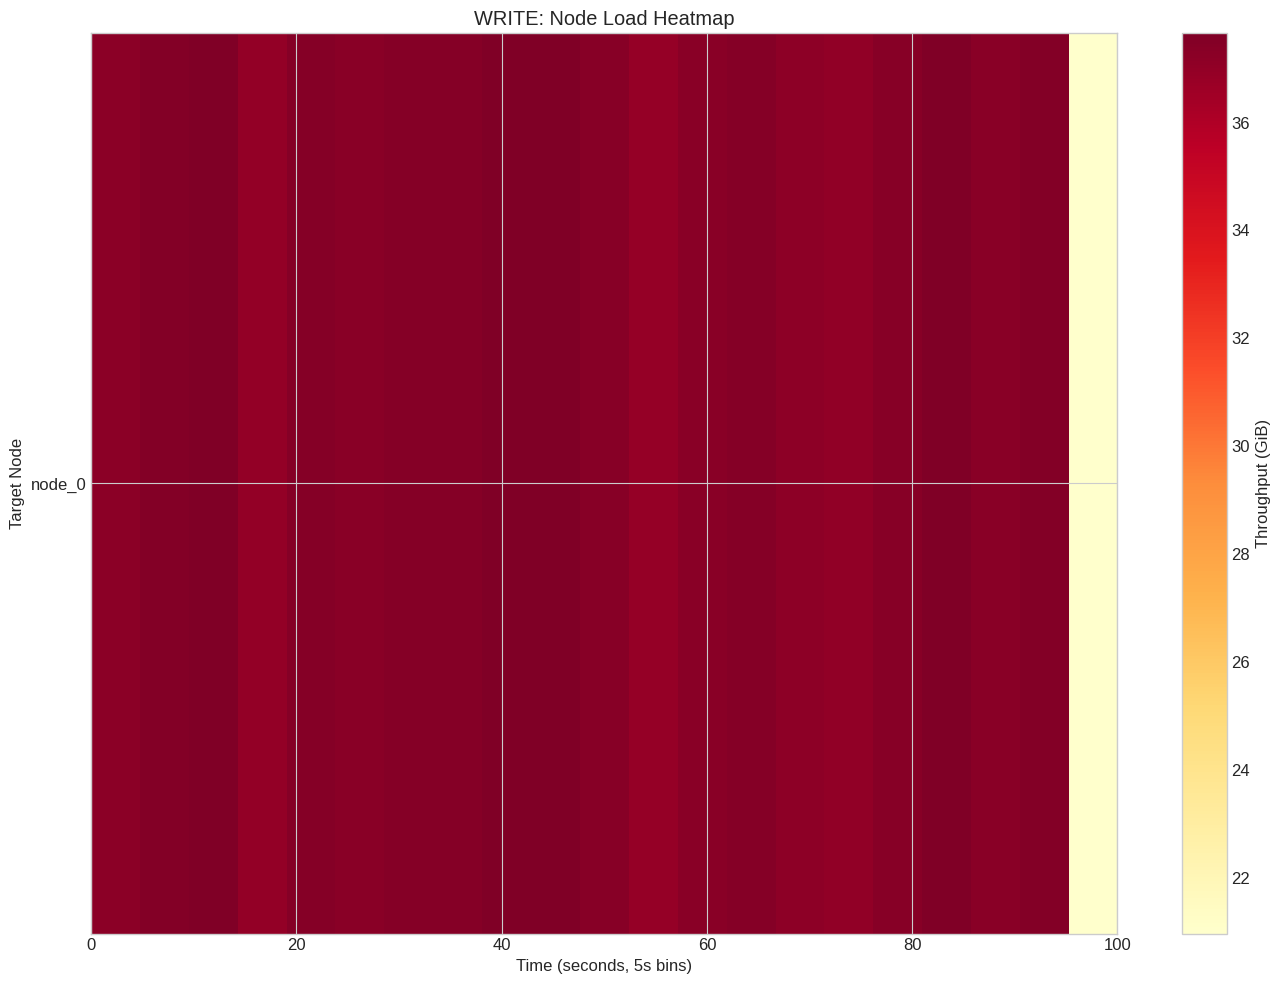

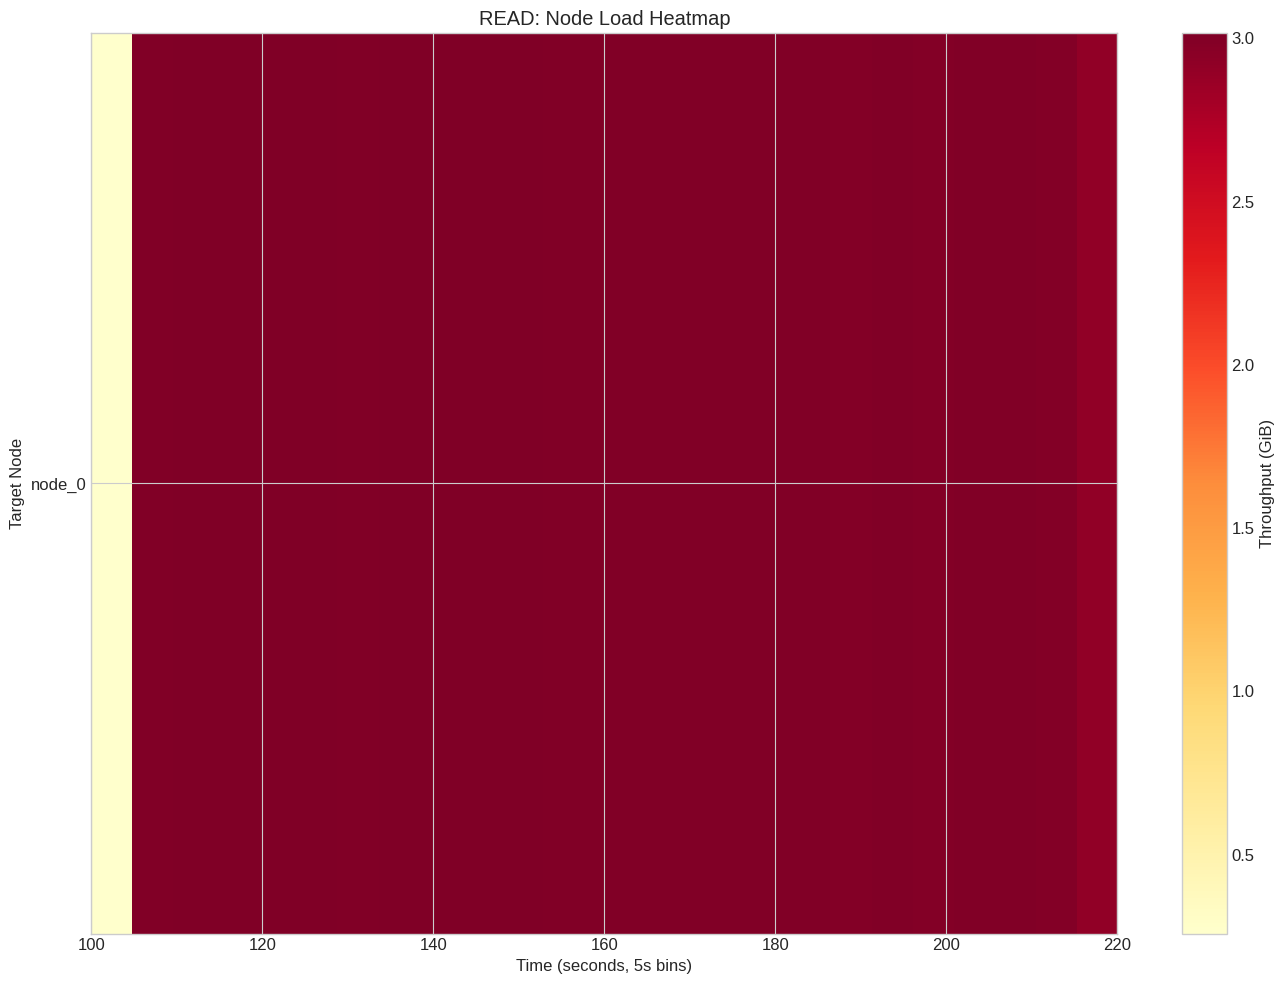

In [28]:
def plot_heatmap(data, title, filename, time_bin=5):
    """Plot heatmap of node load over time (binned)"""
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    # Bin time into larger intervals for clearer heatmap
    data = data.copy()
    data['time_bin'] = (data['time_relative'] // time_bin) * time_bin
    
    # Aggregate by time bin and target node
    heatmap_data = data.groupby(['time_bin', 'target_node'])['total_gib'].sum().unstack(fill_value=0)
    
    # Sort columns naturally
    sorted_cols = sorted(heatmap_data.columns, key=lambda x: int(x.split('_')[1]) if '_' in x else x)
    heatmap_data = heatmap_data[sorted_cols]
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    im = ax.imshow(heatmap_data.T, aspect='auto', cmap='YlOrRd',
                   extent=[heatmap_data.index.min(), heatmap_data.index.max(), 
                           len(heatmap_data.columns)-0.5, -0.5])
    
    ax.set_xlabel(f'Time (seconds, {time_bin}s bins)')
    ax.set_ylabel('Target Node')
    ax.set_title(title)
    ax.set_yticks(range(len(heatmap_data.columns)))
    ax.set_yticklabels(heatmap_data.columns)
    
    cbar = plt.colorbar(im, ax=ax, label='Throughput (GiB)')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150)
    plt.show()

if df_transfer is not None:
    df_transfer_write = df_transfer[df_transfer['op'] == 'WRITE']
    df_transfer_read = df_transfer[df_transfer['op'] == 'READ']
    
    plot_heatmap(df_transfer_write, 'WRITE: Node Load Heatmap', 'write_heatmap.png', time_bin=5)
    plot_heatmap(df_transfer_read, 'READ: Node Load Heatmap', 'read_heatmap.png', time_bin=5)

## 3.6 Load Imbalance Analysis

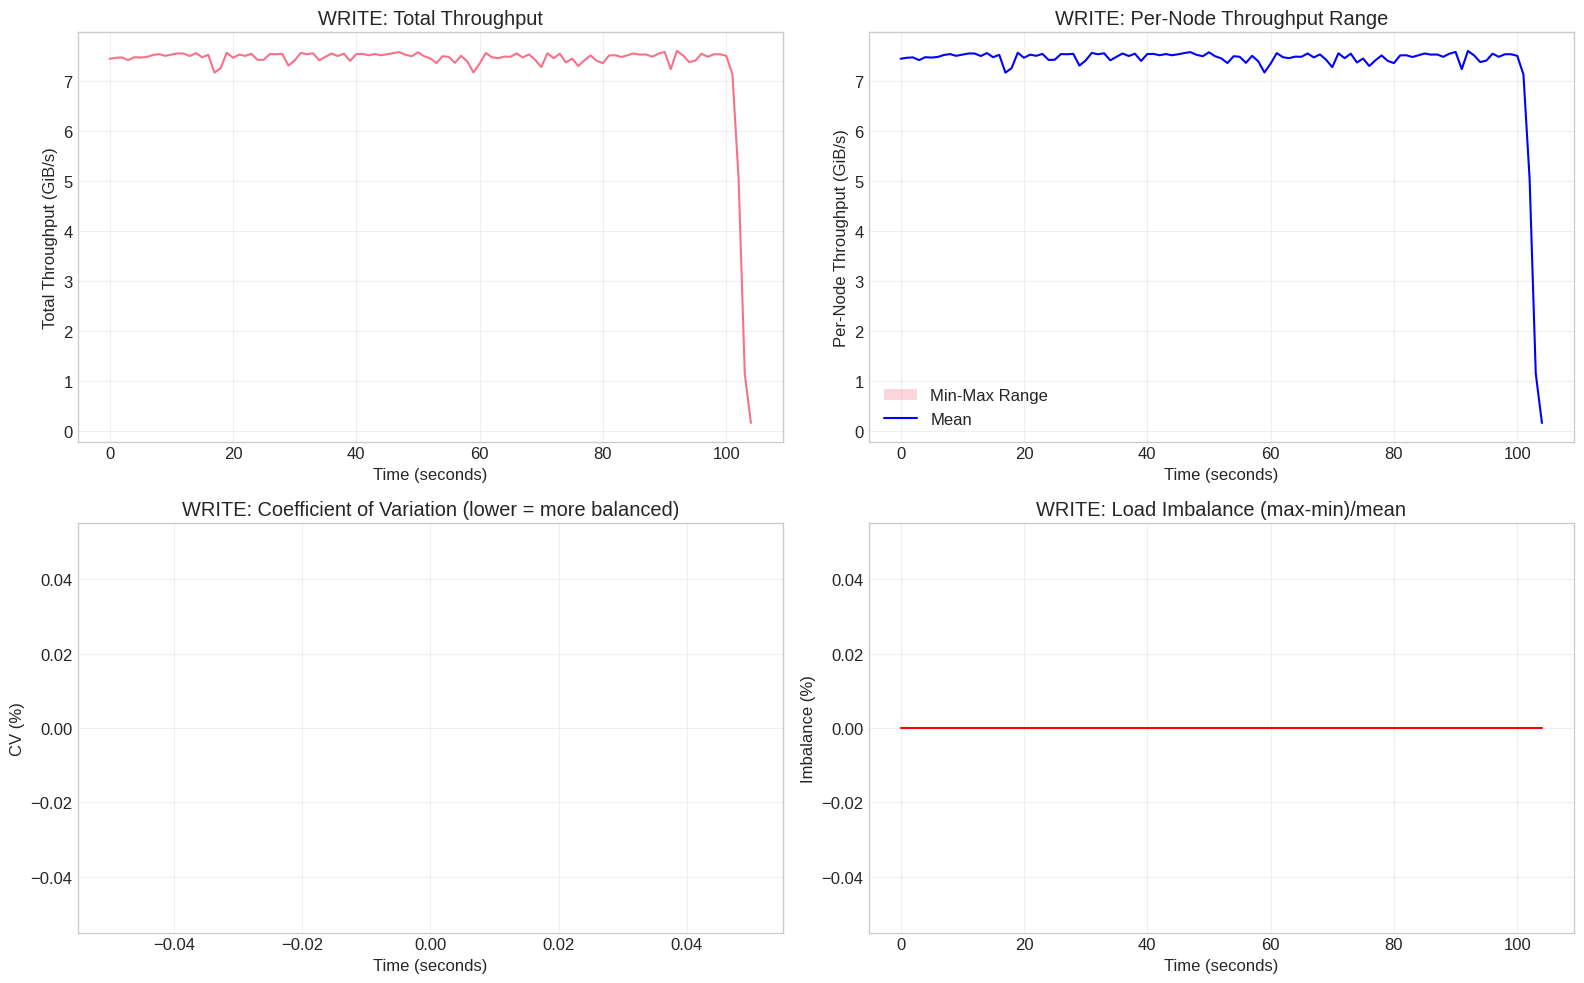


WRITE - Summary Statistics:
  Average total throughput: 7.31 GiB/s
  Average per-node throughput: 7.31 GiB/s
  Average CV: nan%
  Average imbalance: 0.00%
  Max imbalance: 0.00%


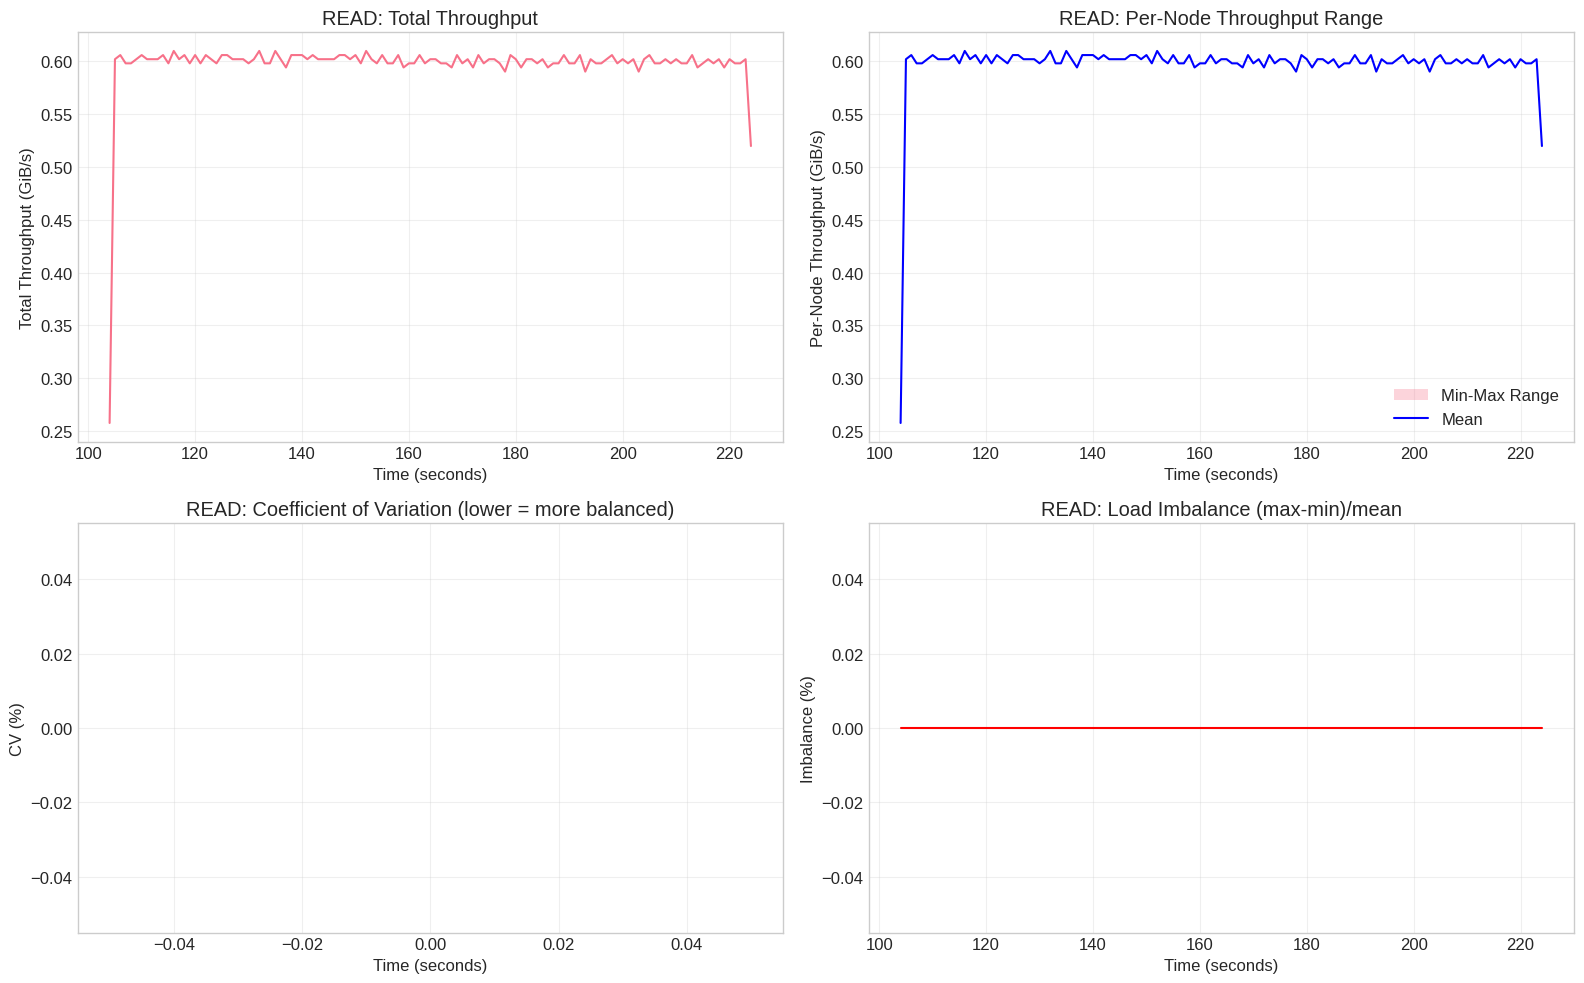


READ - Summary Statistics:
  Average total throughput: 0.60 GiB/s
  Average per-node throughput: 0.60 GiB/s
  Average CV: nan%
  Average imbalance: 0.00%
  Max imbalance: 0.00%


In [29]:
def analyze_load_imbalance(data, title):
    """Analyze load imbalance across nodes over time"""
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    # Aggregate by time and target node
    node_throughput = data.groupby(['time_relative', 'target_node'])['total_gib'].sum().unstack(fill_value=0)
    
    # Calculate per-second statistics
    stats = pd.DataFrame({
        'mean': node_throughput.mean(axis=1),
        'std': node_throughput.std(axis=1),
        'min': node_throughput.min(axis=1),
        'max': node_throughput.max(axis=1),
        'total': node_throughput.sum(axis=1)
    })
    stats['cv'] = stats['std'] / stats['mean'] * 100  # Coefficient of variation (%)
    stats['imbalance'] = (stats['max'] - stats['min']) / stats['mean'] * 100
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Total throughput
    ax = axes[0, 0]
    ax.plot(stats.index, stats['total'], linewidth=1.5)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Total Throughput (GiB/s)')
    ax.set_title(f'{title}: Total Throughput')
    ax.grid(True, alpha=0.3)
    
    # Min/Max/Mean per node
    ax = axes[0, 1]
    ax.fill_between(stats.index, stats['min'], stats['max'], alpha=0.3, label='Min-Max Range')
    ax.plot(stats.index, stats['mean'], linewidth=1.5, label='Mean', color='blue')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Per-Node Throughput (GiB/s)')
    ax.set_title(f'{title}: Per-Node Throughput Range')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Coefficient of Variation
    ax = axes[1, 0]
    ax.plot(stats.index, stats['cv'], linewidth=1.5, color='orange')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('CV (%)')
    ax.set_title(f'{title}: Coefficient of Variation (lower = more balanced)')
    ax.grid(True, alpha=0.3)
    
    # Imbalance percentage
    ax = axes[1, 1]
    ax.plot(stats.index, stats['imbalance'], linewidth=1.5, color='red')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Imbalance (%)')
    ax.set_title(f'{title}: Load Imbalance (max-min)/mean')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f'{title.lower().replace(":", "").replace(" ", "_")}_imbalance.png', dpi=150)
    plt.show()
    
    # Print summary statistics
    print(f"\n{title} - Summary Statistics:")
    print(f"  Average total throughput: {stats['total'].mean():.2f} GiB/s")
    print(f"  Average per-node throughput: {stats['mean'].mean():.2f} GiB/s")
    print(f"  Average CV: {stats['cv'].mean():.2f}%")
    print(f"  Average imbalance: {stats['imbalance'].mean():.2f}%")
    print(f"  Max imbalance: {stats['imbalance'].max():.2f}%")

if df_transfer is not None:
    df_transfer_write = df_transfer[df_transfer['op'] == 'WRITE']
    df_transfer_read = df_transfer[df_transfer['op'] == 'READ']
    
    analyze_load_imbalance(df_transfer_write, 'WRITE')
    analyze_load_imbalance(df_transfer_read, 'READ')

## 3.7 Transfer Count Analysis

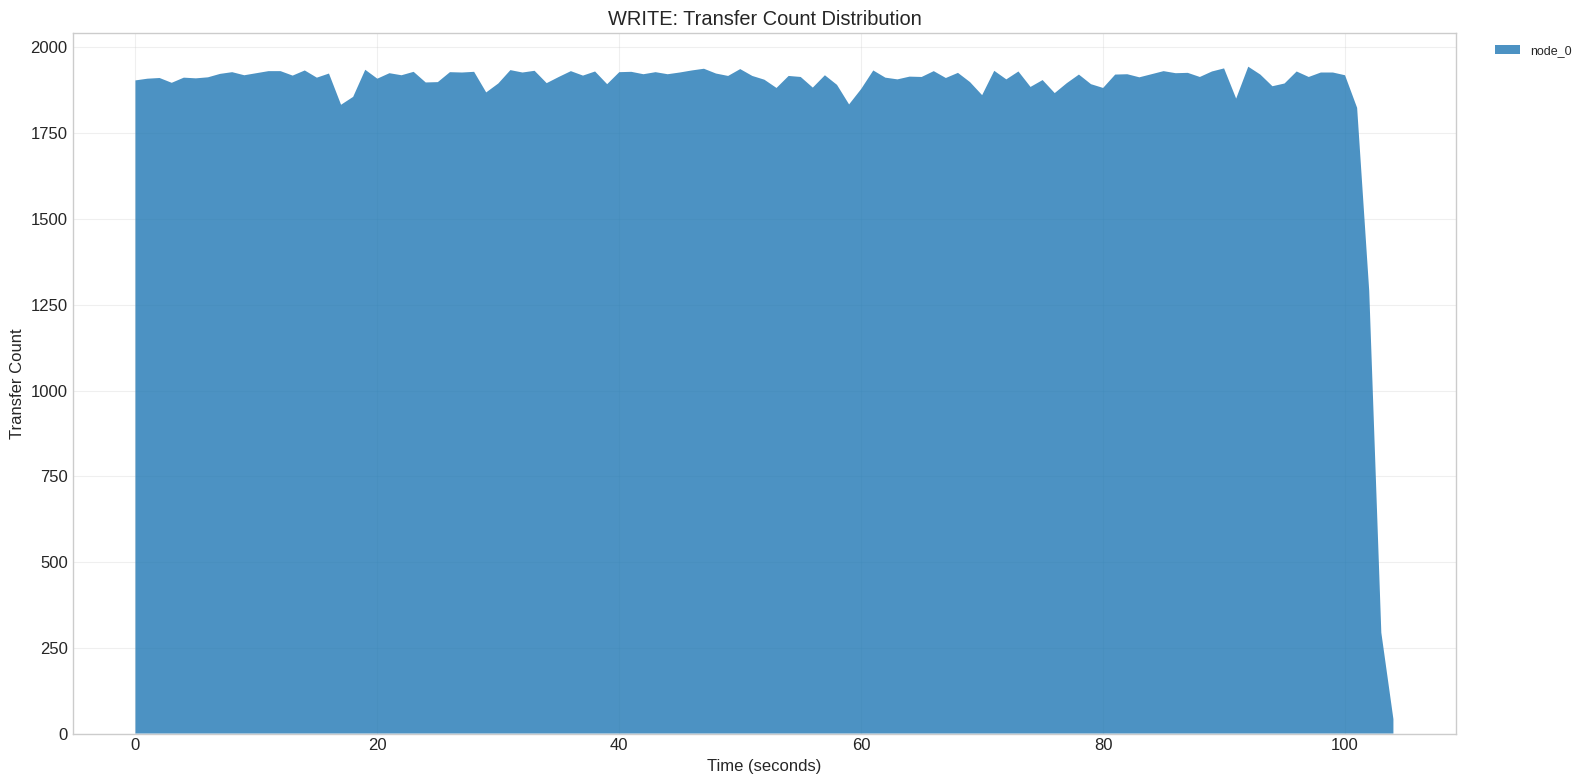

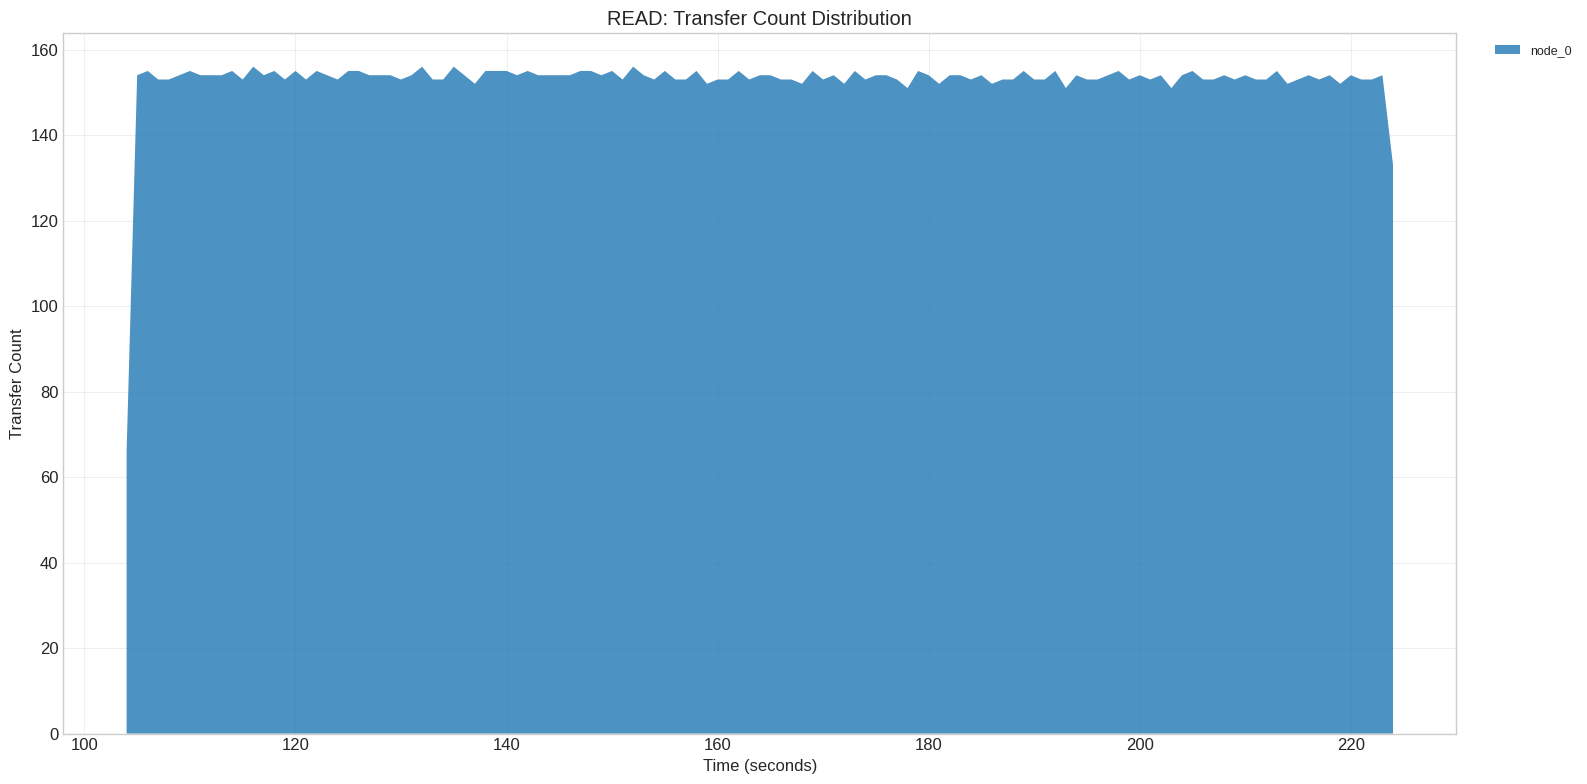

In [30]:
def plot_transfer_counts(data, title, filename):
    """Plot transfer counts per node over time"""
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    # Aggregate transfer counts by time and target node
    count_data = data.groupby(['time_relative', 'target_node'])['transfer_count'].sum().unstack(fill_value=0)
    
    # Sort columns naturally
    sorted_cols = sorted(count_data.columns, key=lambda x: int(x.split('_')[1]) if '_' in x else x)
    count_data = count_data[sorted_cols]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(count_data.columns)))
    
    ax.stackplot(count_data.index, 
                 [count_data[col] for col in count_data.columns],
                 labels=count_data.columns,
                 colors=colors,
                 alpha=0.8)
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Transfer Count')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

if df_transfer is not None:
    df_transfer_write = df_transfer[df_transfer['op'] == 'WRITE']
    df_transfer_read = df_transfer[df_transfer['op'] == 'READ']
    
    plot_transfer_counts(df_transfer_write, 'WRITE: Transfer Count Distribution', 'write_transfer_counts.png')
    plot_transfer_counts(df_transfer_read, 'READ: Transfer Count Distribution', 'read_transfer_counts.png')

## 3.8 Summary Table

In [31]:
# Total bytes per target node
if df_transfer is not None:
    summary = df_transfer.groupby(['op', 'target_node']).agg({
        'total_bytes': 'sum',
        'transfer_count': 'sum'
    }).reset_index()

    summary['total_gib'] = summary['total_bytes'] / (1024**3)
    summary['avg_transfer_size_mb'] = summary['total_bytes'] / summary['transfer_count'] / (1024**2)

    print("=== Per-Node Summary ===")
    for op in ['WRITE', 'READ']:
        print(f"\n{op}:")
        op_data = summary[summary['op'] == op].sort_values('target_node')
        print(op_data[['target_node', 'total_gib', 'transfer_count', 'avg_transfer_size_mb']].to_string(index=False))

=== Per-Node Summary ===

WRITE:
target_node  total_gib  transfer_count  avg_transfer_size_mb
     node_0      768.0          196608                   4.0

READ:
target_node  total_gib  transfer_count  avg_transfer_size_mb
     node_0  72.246094           18495                   4.0


---
# Section 4: iostat Time-Series Analysis

This section analyzes disk I/O statistics collected via iostat during benchmark execution.

Key metrics:
- **r_await / w_await**: Average time (ms) for read/write requests to be served
- **aqu-sz**: Average queue length of requests submitted to the device
- **r/s, w/s**: Read/write operations per second
- **rkB/s, wkB/s**: Read/write throughput in KB/s
- **util**: Device utilization percentage

In [32]:
# Load iostat data
iostat_csv = RESULTS_DIR / 'iostat_raw.csv'
iostat_df = load_csv_if_exists(iostat_csv, 'iostat')

if iostat_df is not None:
    # Parse timestamp
    iostat_df['timestamp'] = pd.to_datetime(iostat_df['timestamp'])
    iostat_df['relative_time'] = (iostat_df['timestamp'] - iostat_df['timestamp'].min()).dt.total_seconds()
    
    print(f"Loaded {len(iostat_df)} iostat entries")
    print(f"Nodes: {iostat_df['node'].nunique()}")
    print(f"Devices: {iostat_df['device'].unique().tolist()}")
    print(f"Time range: {iostat_df['relative_time'].min():.0f}s - {iostat_df['relative_time'].max():.0f}s")

Loaded iostat: 282 records
Loaded 282 iostat entries
Nodes: 2
Devices: ['md0', 'nvme0n1', 'nvme1n1']
Time range: 0s - 230s


## 4.1 Read Latency (r_await) Over Time

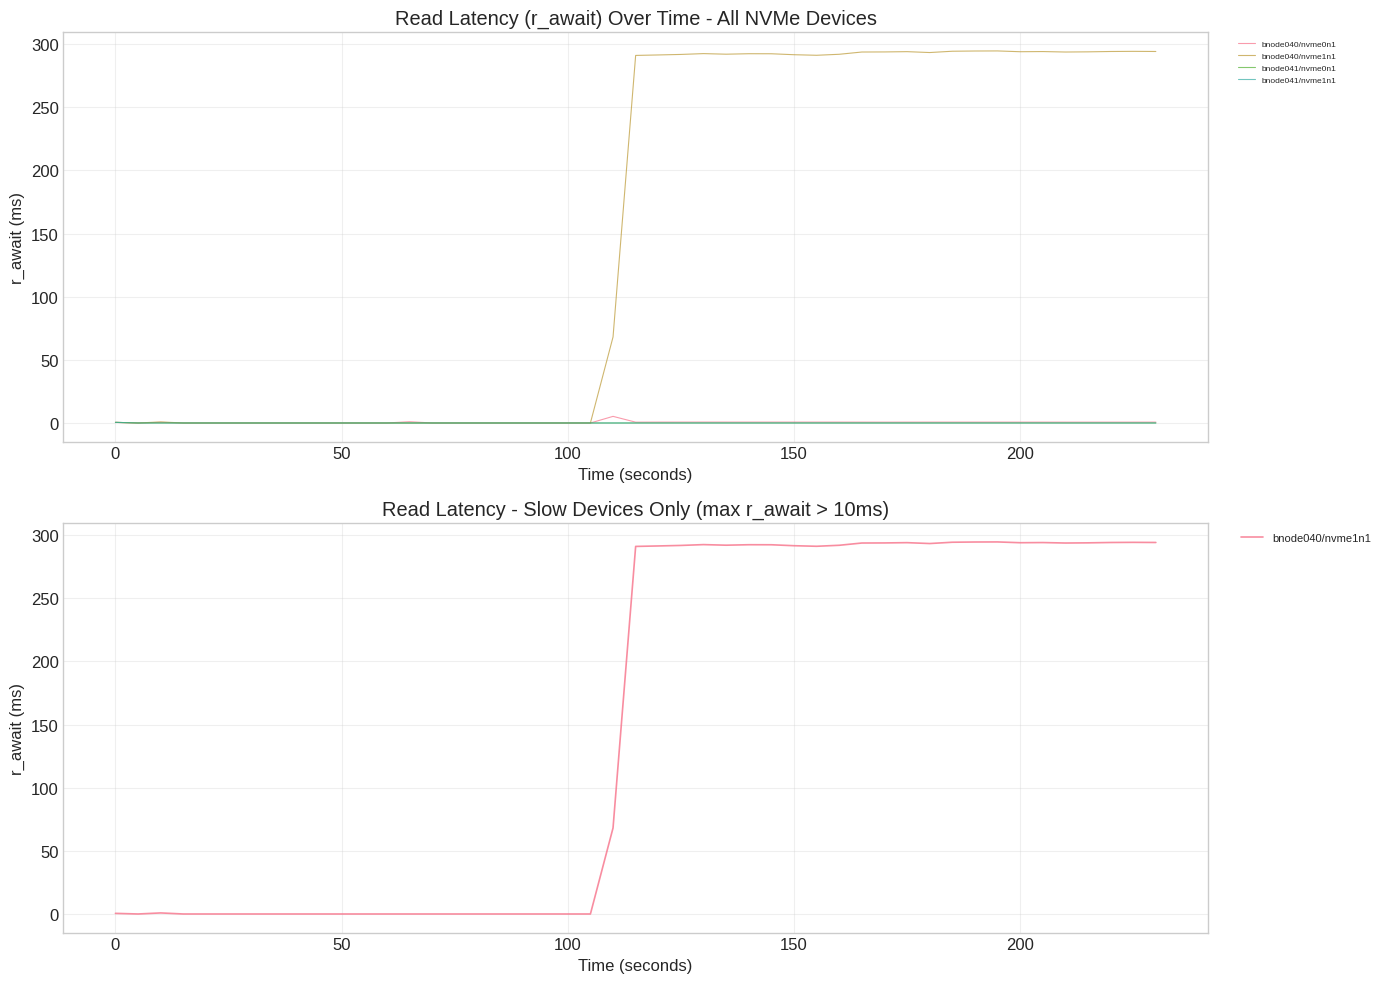


Slow devices (max r_await > 10ms): 1


In [33]:
if iostat_df is not None:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Filter to nvme devices only
    nvme_df = iostat_df[iostat_df['device'].str.startswith('nvme')].copy()
    
    # Plot 1: r_await for all nodes
    ax = axes[0]
    for (node, device), group in nvme_df.groupby(['node', 'device']):
        label = f"{node}/{device}"
        ax.plot(group['relative_time'], group['r_await'], alpha=0.7, linewidth=0.8, label=label)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('r_await (ms)')
    ax.set_title('Read Latency (r_await) Over Time - All NVMe Devices')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=6)
    
    # Plot 2: Highlight slow devices only (r_await > 10ms at any point)
    ax = axes[1]
    slow_devices = nvme_df.groupby(['node', 'device'])['r_await'].max()
    slow_devices = slow_devices[slow_devices > 10].index.tolist()
    
    for (node, device) in slow_devices:
        group = nvme_df[(nvme_df['node'] == node) & (nvme_df['device'] == device)]
        label = f"{node}/{device}"
        ax.plot(group['relative_time'], group['r_await'], alpha=0.8, linewidth=1.2, label=label)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('r_await (ms)')
    ax.set_title('Read Latency - Slow Devices Only (max r_await > 10ms)')
    ax.grid(True, alpha=0.3)
    if slow_devices:
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'iostat_r_await_over_time.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nSlow devices (max r_await > 10ms): {len(slow_devices)}")

## 4.2 Queue Depth (aqu-sz) Over Time

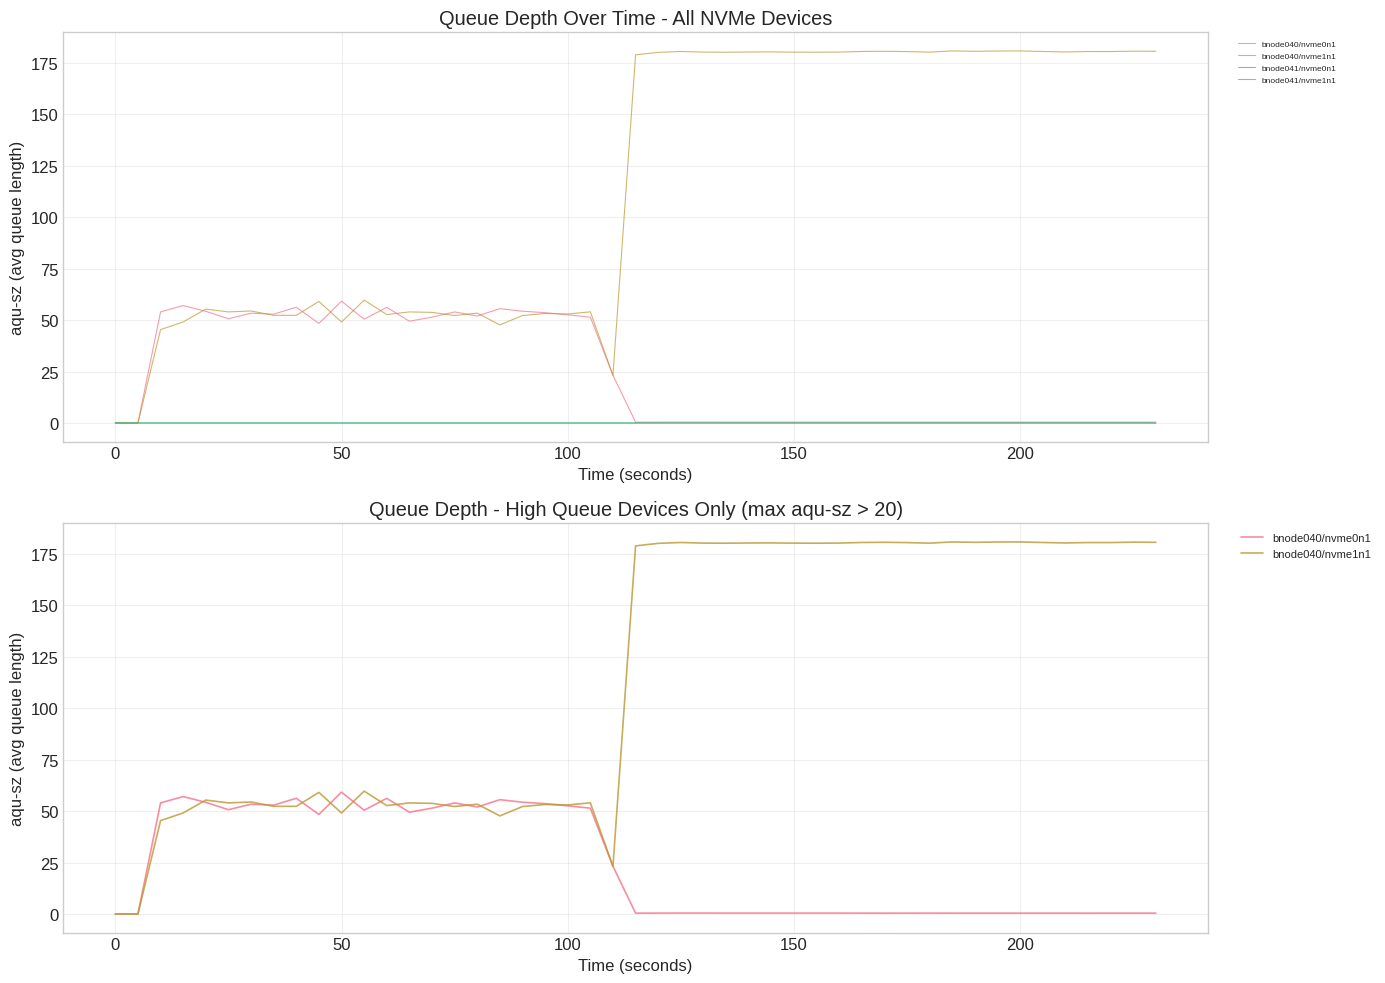


High queue devices (max aqu-sz > 20): 2


In [34]:
if iostat_df is not None:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    nvme_df = iostat_df[iostat_df['device'].str.startswith('nvme')].copy()
    
    # Plot 1: aqu_sz for all nodes
    ax = axes[0]
    for (node, device), group in nvme_df.groupby(['node', 'device']):
        label = f"{node}/{device}"
        ax.plot(group['relative_time'], group['aqu_sz'], alpha=0.7, linewidth=0.8, label=label)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('aqu-sz (avg queue length)')
    ax.set_title('Queue Depth Over Time - All NVMe Devices')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=6)
    
    # Plot 2: High queue depth devices only (aqu_sz > 20 at any point)
    ax = axes[1]
    high_queue = nvme_df.groupby(['node', 'device'])['aqu_sz'].max()
    high_queue = high_queue[high_queue > 20].index.tolist()
    
    for (node, device) in high_queue:
        group = nvme_df[(nvme_df['node'] == node) & (nvme_df['device'] == device)]
        label = f"{node}/{device}"
        ax.plot(group['relative_time'], group['aqu_sz'], alpha=0.8, linewidth=1.2, label=label)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('aqu-sz (avg queue length)')
    ax.set_title('Queue Depth - High Queue Devices Only (max aqu-sz > 20)')
    ax.grid(True, alpha=0.3)
    if high_queue:
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'iostat_aqu_sz_over_time.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nHigh queue devices (max aqu-sz > 20): {len(high_queue)}")

## 4.3 Read vs Write Latency Comparison

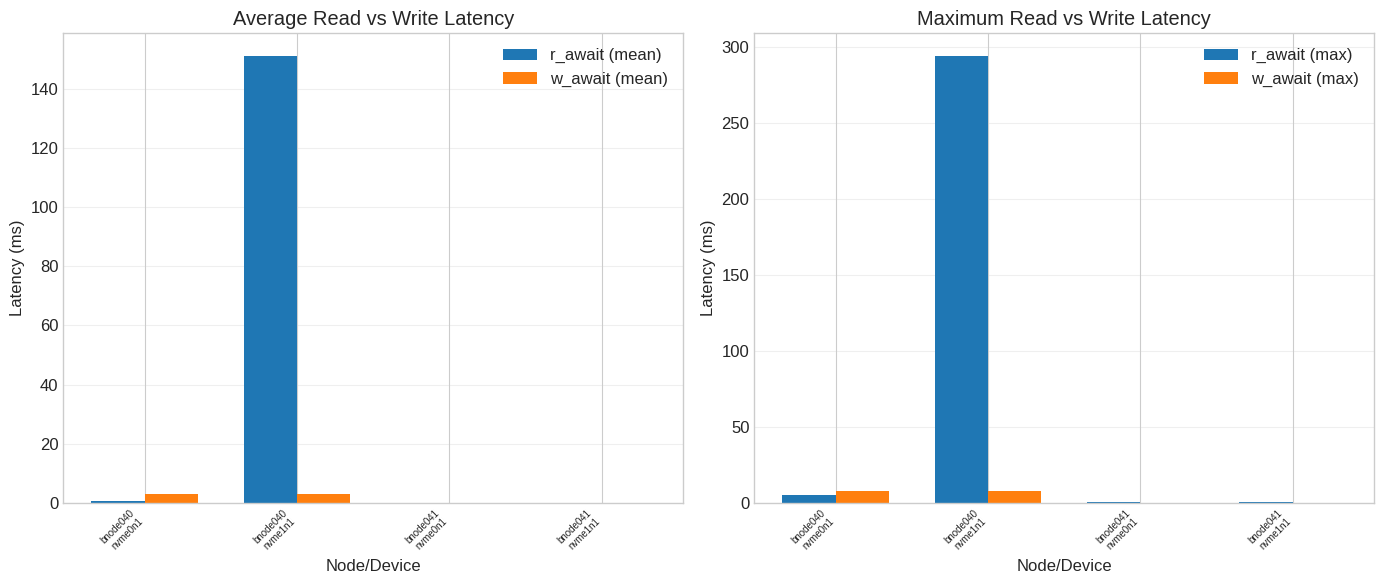

In [35]:
if iostat_df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    nvme_df = iostat_df[iostat_df['device'].str.startswith('nvme')].copy()
    
    # Aggregate by node and device
    stats = nvme_df.groupby(['node', 'device']).agg({
        'r_await': ['mean', 'max'],
        'w_await': ['mean', 'max'],
        'aqu_sz': ['mean', 'max']
    }).reset_index()
    stats.columns = ['node', 'device', 'r_await_mean', 'r_await_max', 'w_await_mean', 'w_await_max', 'aqu_sz_mean', 'aqu_sz_max']
    
    # Plot 1: Average latency comparison
    ax = axes[0]
    x = range(len(stats))
    width = 0.35
    ax.bar([i - width/2 for i in x], stats['r_await_mean'], width, label='r_await (mean)', color='tab:blue')
    ax.bar([i + width/2 for i in x], stats['w_await_mean'], width, label='w_await (mean)', color='tab:orange')
    ax.set_xlabel('Node/Device')
    ax.set_ylabel('Latency (ms)')
    ax.set_title('Average Read vs Write Latency')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{r['node']}\n{r['device']}" for _, r in stats.iterrows()], rotation=45, ha='right', fontsize=7)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Max latency comparison
    ax = axes[1]
    ax.bar([i - width/2 for i in x], stats['r_await_max'], width, label='r_await (max)', color='tab:blue')
    ax.bar([i + width/2 for i in x], stats['w_await_max'], width, label='w_await (max)', color='tab:orange')
    ax.set_xlabel('Node/Device')
    ax.set_ylabel('Latency (ms)')
    ax.set_title('Maximum Read vs Write Latency')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{r['node']}\n{r['device']}" for _, r in stats.iterrows()], rotation=45, ha='right', fontsize=7)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'iostat_latency_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

## 4.4 Throughput Over Time

Loaded fio baselines: 2 read, 2 write


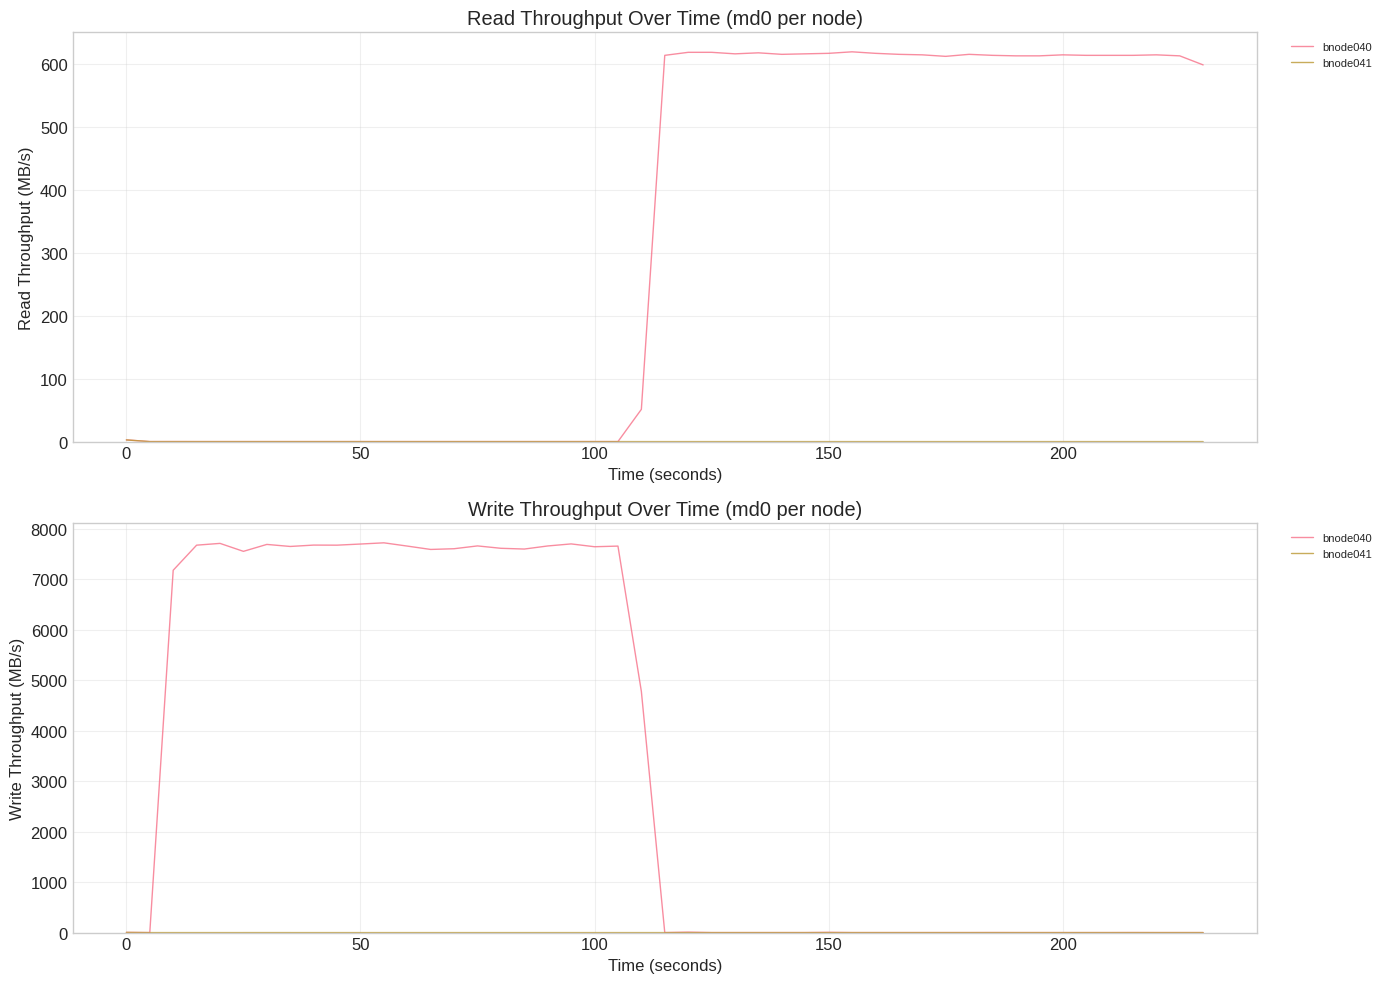

Saved: iostat_throughput_over_time.png


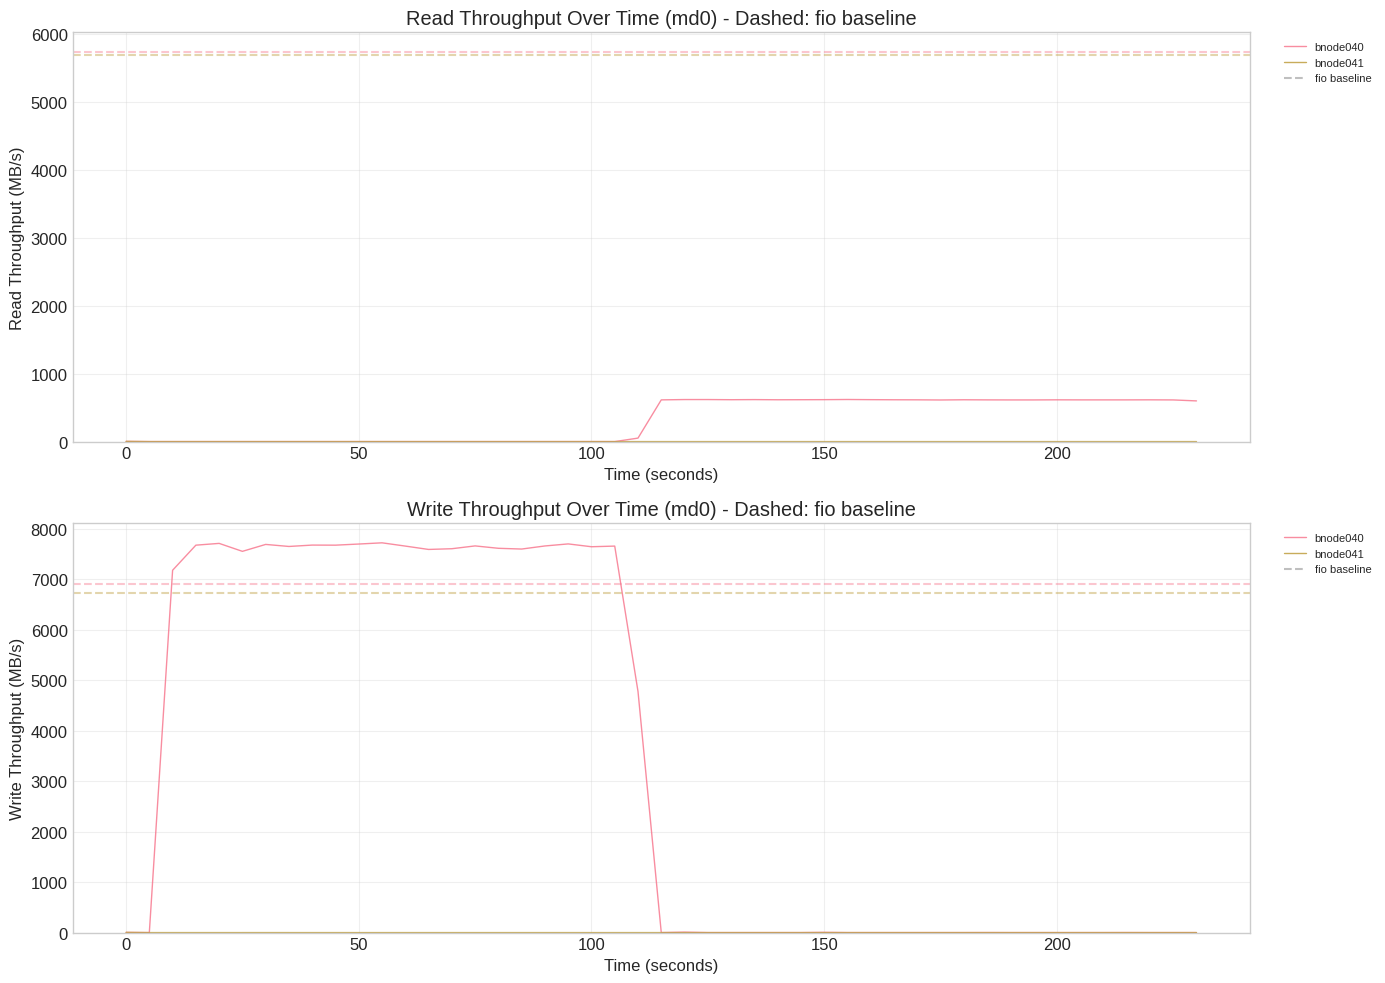

Saved: iostat_throughput_with_fio_baseline.png

fio READ baseline (MB/s):
  bnode040: 5734
  bnode041: 5680

fio WRITE baseline (MB/s):
  bnode040: 6903
  bnode041: 6727


In [36]:
if iostat_df is not None:
    import json
    from pathlib import Path
    
    # Load fio baseline results from diagnostics
    fio_read_bw = {}  # node -> MB/s
    fio_write_bw = {}  # node -> MB/s
    
    diag_dir = RESULTS_DIR / 'diagnostics'
    if diag_dir.exists():
        for node_dir in diag_dir.iterdir():
            if node_dir.is_dir():
                node_name = node_dir.name
                fio_read_file = node_dir / 'fio_read.json'
                fio_write_file = node_dir / 'fio_write.json'
                
                if fio_read_file.exists():
                    try:
                        with open(fio_read_file) as f:
                            data = json.load(f)
                            bw_kb = data['jobs'][0]['read'].get('bw', 0)
                            fio_read_bw[node_name] = bw_kb / 1024  # KB/s -> MB/s
                    except: pass
                
                if fio_write_file.exists():
                    try:
                        with open(fio_write_file) as f:
                            data = json.load(f)
                            bw_kb = data['jobs'][0]['write'].get('bw', 0)
                            fio_write_bw[node_name] = bw_kb / 1024  # KB/s -> MB/s
                    except: pass
    
    print(f"Loaded fio baselines: {len(fio_read_bw)} read, {len(fio_write_bw)} write")
    
    md0_df = iostat_df[iostat_df['device'] == 'md0'].copy()
    
    # ========================================
    # Graph 1: Without fio baseline
    # ========================================
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    ax = axes[0]
    for node, group in md0_df.groupby('node'):
        ax.plot(group['relative_time'], group['rkb_s'] / 1024, alpha=0.8, linewidth=1, label=node)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Read Throughput (MB/s)')
    ax.set_title('Read Throughput Over Time (md0 per node)')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
    ax.set_ylim(bottom=0)
    
    ax = axes[1]
    for node, group in md0_df.groupby('node'):
        ax.plot(group['relative_time'], group['wkb_s'] / 1024, alpha=0.8, linewidth=1, label=node)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Write Throughput (MB/s)')
    ax.set_title('Write Throughput Over Time (md0 per node)')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
    ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'iostat_throughput_over_time.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: iostat_throughput_over_time.png")
    
    # ========================================
    # Graph 2: With fio baseline (dashed lines)
    # ========================================
    if fio_read_bw or fio_write_bw:
        fig, axes = plt.subplots(2, 1, figsize=(14, 10))
        
        ax = axes[0]
        for node, group in md0_df.groupby('node'):
            line, = ax.plot(group['relative_time'], group['rkb_s'] / 1024, alpha=0.8, linewidth=1, label=f'{node}')
            if node in fio_read_bw:
                ax.axhline(y=fio_read_bw[node], color=line.get_color(), linestyle='--', alpha=0.4, linewidth=1.5)
        ax.plot([], [], color='gray', linestyle='--', alpha=0.5, label='fio baseline')
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Read Throughput (MB/s)')
        ax.set_title('Read Throughput Over Time (md0) - Dashed: fio baseline')
        ax.grid(True, alpha=0.3)
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
        ax.set_ylim(bottom=0)
        
        ax = axes[1]
        for node, group in md0_df.groupby('node'):
            line, = ax.plot(group['relative_time'], group['wkb_s'] / 1024, alpha=0.8, linewidth=1, label=f'{node}')
            if node in fio_write_bw:
                ax.axhline(y=fio_write_bw[node], color=line.get_color(), linestyle='--', alpha=0.4, linewidth=1.5)
        ax.plot([], [], color='gray', linestyle='--', alpha=0.5, label='fio baseline')
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Write Throughput (MB/s)')
        ax.set_title('Write Throughput Over Time (md0) - Dashed: fio baseline')
        ax.grid(True, alpha=0.3)
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
        ax.set_ylim(bottom=0)
        
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / 'iostat_throughput_with_fio_baseline.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("Saved: iostat_throughput_with_fio_baseline.png")
        
        # Print fio baseline summary
        print(f"\nfio READ baseline (MB/s):")
        for node in sorted(fio_read_bw.keys()):
            print(f"  {node}: {fio_read_bw[node]:.0f}")
        print(f"\nfio WRITE baseline (MB/s):")
        for node in sorted(fio_write_bw.keys()):
            print(f"  {node}: {fio_write_bw[node]:.0f}")
    else:
        print("No fio baseline data found in diagnostics/*/fio_*.json")

## 4.5 Heatmap: r_await by Node/Device Over Time

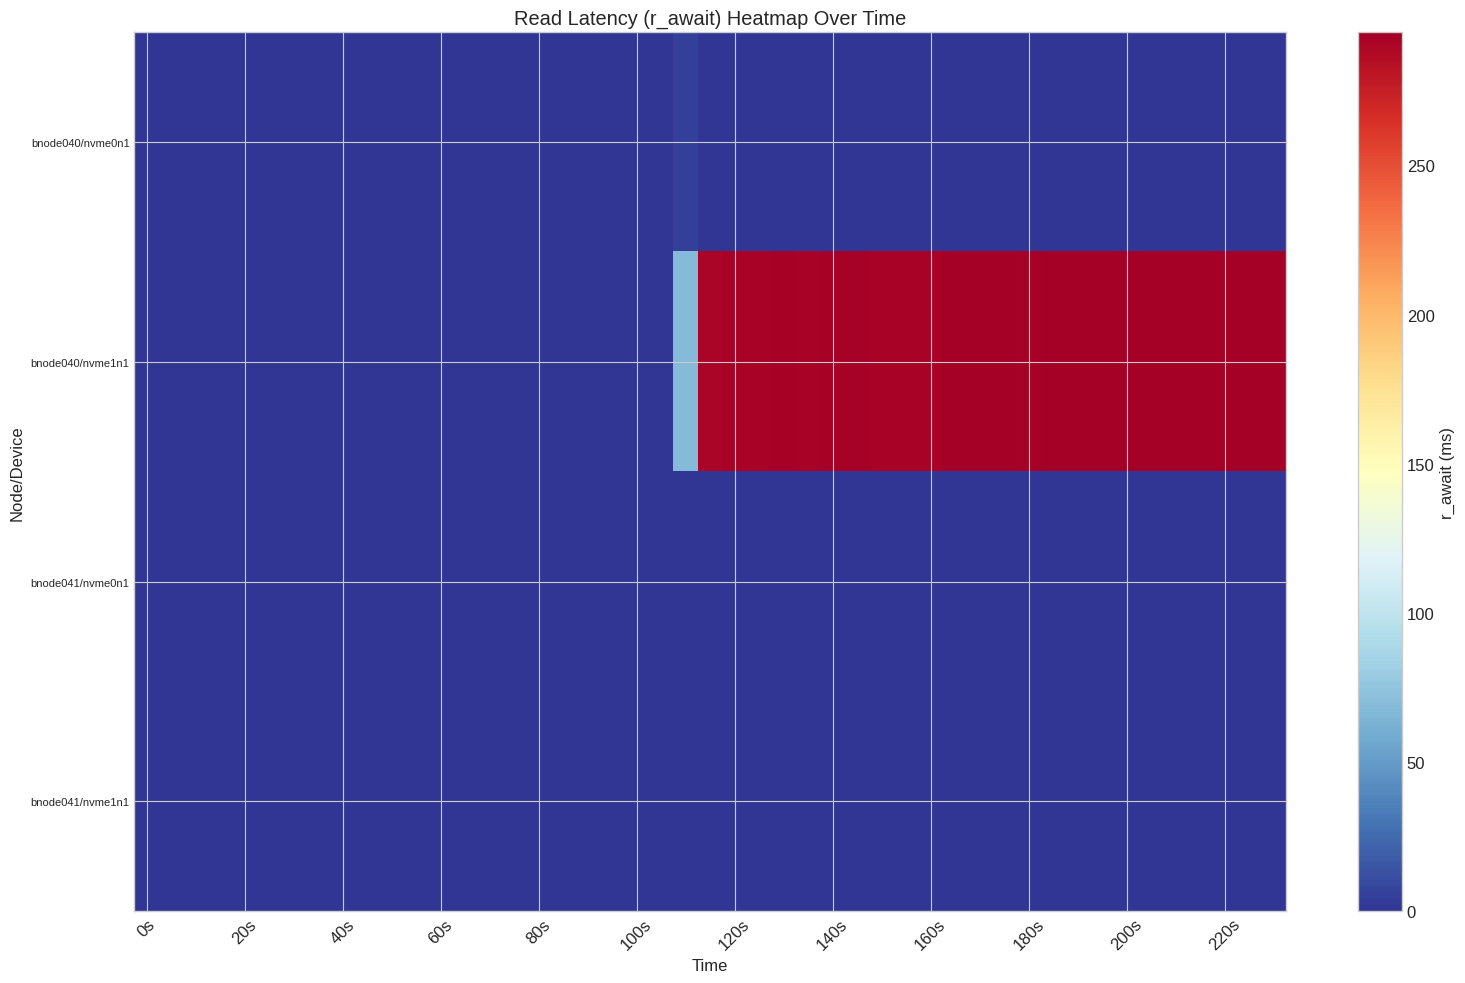

In [37]:
if iostat_df is not None:
    import numpy as np
    
    nvme_df = iostat_df[iostat_df['device'].str.startswith('nvme')].copy()
    
    # Create time bins (5 second intervals)
    nvme_df['time_bin'] = (nvme_df['relative_time'] // 5) * 5
    nvme_df['node_device'] = nvme_df['node'] + '/' + nvme_df['device']
    
    # Pivot for heatmap
    pivot = nvme_df.pivot_table(
        index='node_device', 
        columns='time_bin', 
        values='r_await',
        aggfunc='mean'
    )
    
    fig, ax = plt.subplots(figsize=(16, 10))
    im = ax.imshow(pivot.values, aspect='auto', cmap='RdYlBu_r', interpolation='nearest')
    
    # Set labels
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index, fontsize=8)
    
    # Set x-axis labels (every 10th time bin)
    x_ticks = range(0, len(pivot.columns), max(1, len(pivot.columns)//10))
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f"{int(pivot.columns[i])}s" for i in x_ticks], rotation=45)
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Node/Device')
    ax.set_title('Read Latency (r_await) Heatmap Over Time')
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('r_await (ms)')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'iostat_r_await_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()

## 4.6 Summary Statistics

In [38]:
if iostat_df is not None:
    nvme_df = iostat_df[iostat_df['device'].str.startswith('nvme')].copy()
    
    # Calculate statistics per node/device
    summary = nvme_df.groupby(['node', 'device']).agg({
        'r_await': ['mean', 'max'],
        'w_await': ['mean', 'max'],
        'aqu_sz': ['mean', 'max'],
        'rkb_s': 'mean',
        'wkb_s': 'mean',
        'util': 'mean'
    }).round(2)
    
    summary.columns = ['r_await_avg', 'r_await_max', 'w_await_avg', 'w_await_max', 
                       'aqu_sz_avg', 'aqu_sz_max', 'rkb_s_avg', 'wkb_s_avg', 'util_avg']
    
    print("=== iostat Summary Statistics (NVMe devices) ===")
    print(summary.to_string())
    
    # Identify problematic nodes
    print("\n=== Nodes with High Read Latency (r_await_max > 100ms) ===")
    slow_nodes = summary[summary['r_await_max'] > 100].sort_values('r_await_max', ascending=False)
    if len(slow_nodes) > 0:
        print(slow_nodes[['r_await_avg', 'r_await_max', 'aqu_sz_avg', 'aqu_sz_max']].to_string())
    else:
        print("None detected.")
    
    print("\n=== Nodes with High Queue Depth (aqu_sz_max > 50) ===")
    high_queue = summary[summary['aqu_sz_max'] > 50].sort_values('aqu_sz_max', ascending=False)
    if len(high_queue) > 0:
        print(high_queue[['r_await_avg', 'r_await_max', 'aqu_sz_avg', 'aqu_sz_max']].to_string())
    else:
        print("None detected.")

=== iostat Summary Statistics (NVMe devices) ===
                  r_await_avg  r_await_max  w_await_avg  w_await_max  aqu_sz_avg  aqu_sz_max  rkb_s_avg   wkb_s_avg  util_avg
node     device                                                                                                              
bnode040 nvme0n1         0.50         5.24         3.09         7.69       23.39       59.17  161211.56  1713869.82     68.70
         nvme1n1       151.16       294.60         3.05         7.73      115.01      180.68  160982.67  1713848.32     95.13
bnode041 nvme0n1         0.01         0.50         0.01         0.16        0.00        0.01      29.04       92.62      0.05
         nvme1n1         0.01         0.49         0.00         0.22        0.00        0.01      28.90       38.76      0.00

=== Nodes with High Read Latency (r_await_max > 100ms) ===
                  r_await_avg  r_await_max  aqu_sz_avg  aqu_sz_max
node     device                                                   
b

---
# Section 5: Server RPC Timing Analysis

Analyze detailed timing breakdown of READ and WRITE RPC operations on servers.
Data from `server_rpc_timing_raw.csv` and `server_rpc_timing_aggregated.csv`.

## 5.1 Load Server RPC Timing Data

In [39]:
# Load server RPC timing data
rpc_timing_raw_file = RESULTS_DIR / 'server_rpc_timing_raw.csv'
rpc_timing_agg_file = RESULTS_DIR / 'server_rpc_timing_aggregated.csv'
chunk_io_file = RESULTS_DIR / 'chunk_io_timing_raw.csv'

rpc_timing_raw = None
rpc_timing_agg = None
chunk_io_raw = None

if rpc_timing_raw_file.exists():
    rpc_timing_raw = pd.read_csv(rpc_timing_raw_file)
    print(f"Loaded {len(rpc_timing_raw)} RPC timing entries")
    print(f"Columns: {list(rpc_timing_raw.columns)}")
    print(f"\nRPC types: {rpc_timing_raw['rpc_type'].value_counts().to_dict()}")
else:
    print(f"WARNING: {rpc_timing_raw_file} not found")
    print("Run extract_server_rpc_timing.sh to generate this file")

if rpc_timing_agg_file.exists():
    rpc_timing_agg = pd.read_csv(rpc_timing_agg_file)
    print(f"\nLoaded {len(rpc_timing_agg)} aggregated entries")
else:
    print(f"WARNING: {rpc_timing_agg_file} not found")

if chunk_io_file.exists():
    chunk_io_raw = pd.read_csv(chunk_io_file)
    print(f"\nLoaded {len(chunk_io_raw)} chunk IO timing entries")
else:
    print(f"WARNING: {chunk_io_file} not found")

Loaded 215103 RPC timing entries
Columns: ['timestamp', 'node', 'rpc_type', 'chunk_id', 'total_us', 'parse_us', 'buffer_acquire_us', 'io_read_us', 'recv_data_us', 'io_write_us', 'response_construct_us', 'reply_us', 'bytes']

RPC types: {'WRITE': 196608, 'READ': 18495}

Loaded 226 aggregated entries

Loaded 215103 chunk IO timing entries


## 5.2 READ vs WRITE Latency Comparison

/work/NBB/rmaeda/tmp/ipykernel_3250715/128132899.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot([write_data, read_data], labels=['WRITE', 'READ'], patch_artist=True)


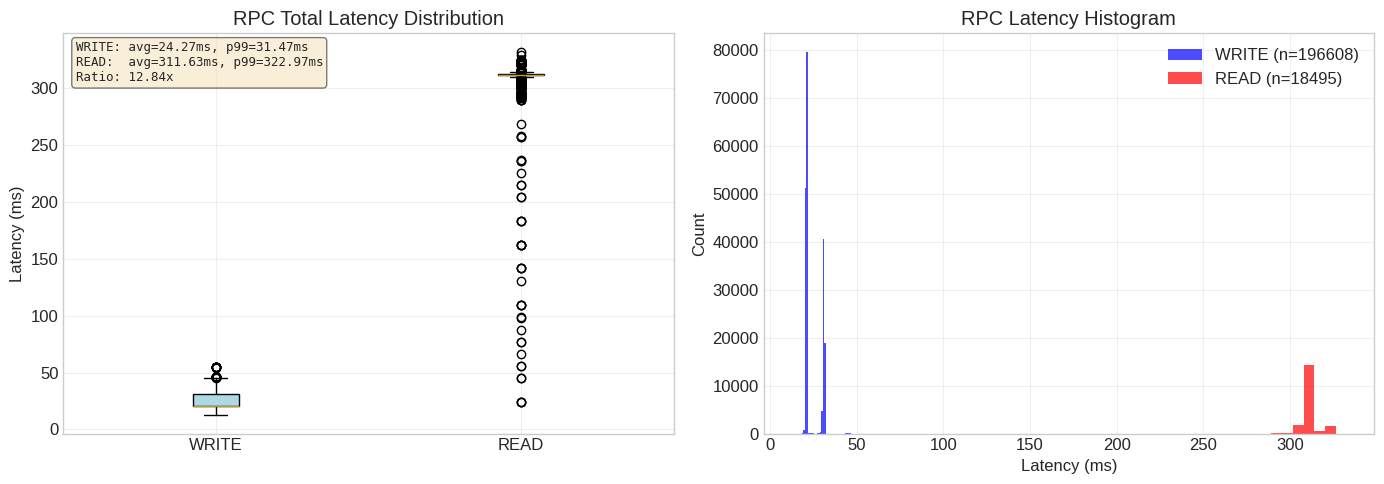

Saved: rpc_latency_comparison.png


In [40]:
if rpc_timing_raw is not None and len(rpc_timing_raw) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Box plot of total latency
    ax1 = axes[0]
    read_data = rpc_timing_raw[rpc_timing_raw['rpc_type'] == 'READ']['total_us'] / 1000  # ms
    write_data = rpc_timing_raw[rpc_timing_raw['rpc_type'] == 'WRITE']['total_us'] / 1000  # ms
    
    bp = ax1.boxplot([write_data, read_data], labels=['WRITE', 'READ'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    ax1.set_ylabel('Latency (ms)')
    ax1.set_title('RPC Total Latency Distribution')
    ax1.grid(True, alpha=0.3)
    
    # Add statistics text
    stats_text = f"WRITE: avg={write_data.mean():.2f}ms, p99={write_data.quantile(0.99):.2f}ms\n"
    stats_text += f"READ:  avg={read_data.mean():.2f}ms, p99={read_data.quantile(0.99):.2f}ms\n"
    stats_text += f"Ratio: {read_data.mean()/write_data.mean():.2f}x"
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=9,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Histogram
    ax2 = axes[1]
    ax2.hist(write_data, bins=50, alpha=0.7, label=f'WRITE (n={len(write_data)})', color='blue')
    ax2.hist(read_data, bins=50, alpha=0.7, label=f'READ (n={len(read_data)})', color='red')
    ax2.set_xlabel('Latency (ms)')
    ax2.set_ylabel('Count')
    ax2.set_title('RPC Latency Histogram')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'rpc_latency_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: rpc_latency_comparison.png")
else:
    print("No RPC timing data available")

## 5.3 RPC Timing Breakdown (Stacked Bar)

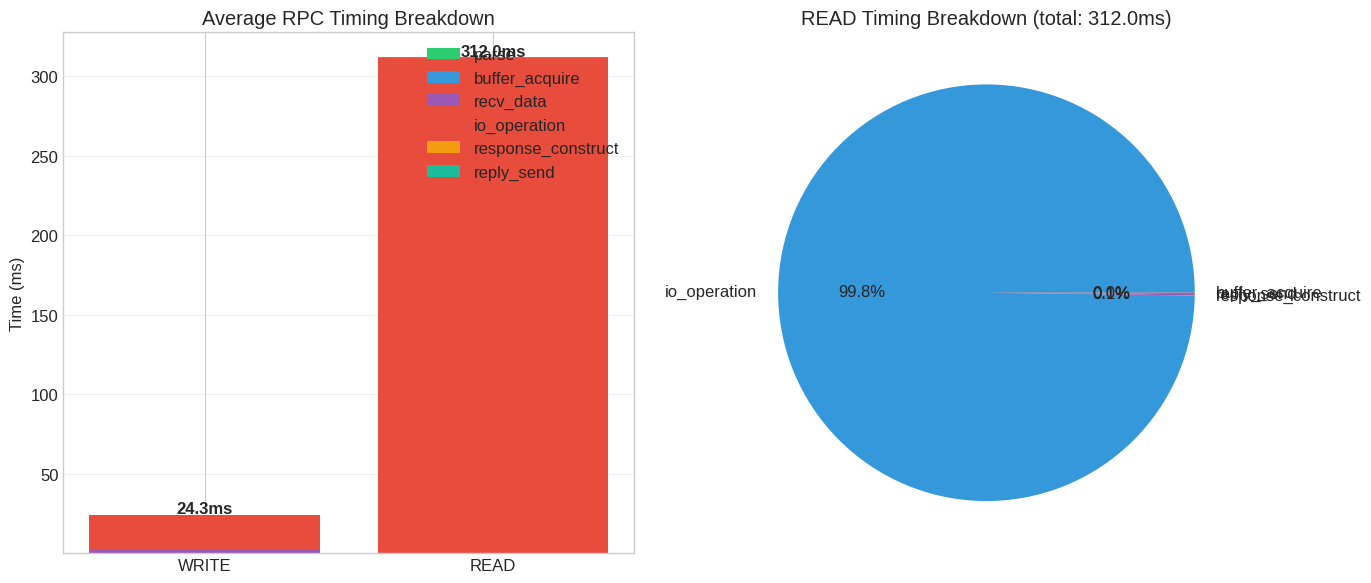

Saved: rpc_timing_breakdown.png

=== Timing Breakdown (ms) ===
Component                 WRITE       READ      Ratio
----------------------------------------------------
parse                     0.000      0.000       0.00x
buffer_acquire            0.000      0.000       0.64x
io_operation             21.642    311.303      14.38x
response_construct        0.000      0.328  508155.01x
reply_send                0.000      0.328  686449.88x
----------------------------------------------------
TOTAL                    24.268    311.959      12.85x


In [41]:
if rpc_timing_raw is not None and len(rpc_timing_raw) > 0:
    # Calculate average timing breakdown for READ and WRITE
    read_df = rpc_timing_raw[rpc_timing_raw['rpc_type'] == 'READ']
    write_df = rpc_timing_raw[rpc_timing_raw['rpc_type'] == 'WRITE']
    
    # Timing components
    read_breakdown = {
        'parse': read_df['parse_us'].mean() / 1000,
        'buffer_acquire': read_df['buffer_acquire_us'].mean() / 1000,
        'io_operation': read_df['io_read_us'].mean() / 1000,
        'response_construct': read_df['response_construct_us'].mean() / 1000,
        'reply_send': read_df['reply_us'].mean() / 1000,
    }
    
    write_breakdown = {
        'parse': write_df['parse_us'].mean() / 1000,
        'buffer_acquire': write_df['buffer_acquire_us'].mean() / 1000,
        'recv_data': write_df['recv_data_us'].mean() / 1000,
        'io_operation': write_df['io_write_us'].mean() / 1000,
        'response_construct': write_df['response_construct_us'].mean() / 1000,
        'reply_send': write_df['reply_us'].mean() / 1000,
    }
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Stacked bar chart
    ax1 = axes[0]
    categories = ['WRITE', 'READ']
    
    # Common components
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12', '#1abc9c']
    
    # WRITE stack
    write_vals = [write_breakdown['parse'], write_breakdown['buffer_acquire'], 
                  write_breakdown['recv_data'], write_breakdown['io_operation'],
                  write_breakdown['response_construct'], write_breakdown['reply_send']]
    write_labels = ['parse', 'buffer_acquire', 'recv_data', 'io_operation', 'response_construct', 'reply_send']
    
    # READ stack
    read_vals = [read_breakdown['parse'], read_breakdown['buffer_acquire'],
                 0, read_breakdown['io_operation'],  # no recv_data for READ
                 read_breakdown['response_construct'], read_breakdown['reply_send']]
    
    x = [0, 1]
    bottom_write = 0
    bottom_read = 0
    
    for i, label in enumerate(write_labels):
        ax1.bar(0, write_vals[i], bottom=bottom_write, color=colors[i], label=label if i < 6 else '')
        ax1.bar(1, read_vals[i], bottom=bottom_read, color=colors[i])
        bottom_write += write_vals[i]
        bottom_read += read_vals[i]
    
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['WRITE', 'READ'])
    ax1.set_ylabel('Time (ms)')
    ax1.set_title('Average RPC Timing Breakdown')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add total values on top
    ax1.text(0, bottom_write + 1, f'{bottom_write:.1f}ms', ha='center', fontweight='bold')
    ax1.text(1, bottom_read + 1, f'{bottom_read:.1f}ms', ha='center', fontweight='bold')
    
    # Pie chart for READ breakdown
    ax2 = axes[1]
    read_pie_vals = [v for v in read_breakdown.values() if v > 0]
    read_pie_labels = [k for k, v in read_breakdown.items() if v > 0]
    
    wedges, texts, autotexts = ax2.pie(read_pie_vals, labels=read_pie_labels, autopct='%1.1f%%',
                                       colors=colors[:len(read_pie_vals)])
    ax2.set_title(f'READ Timing Breakdown (total: {sum(read_pie_vals):.1f}ms)')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'rpc_timing_breakdown.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: rpc_timing_breakdown.png")
    
    # Print detailed breakdown
    print("\n=== Timing Breakdown (ms) ===")
    print(f"{'Component':<20} {'WRITE':>10} {'READ':>10} {'Ratio':>10}")
    print("-" * 52)
    for key in ['parse', 'buffer_acquire', 'io_operation', 'response_construct', 'reply_send']:
        w = write_breakdown.get(key, 0)
        r = read_breakdown.get(key, 0)
        ratio = r / w if w > 0 else 0
        print(f"{key:<20} {w:>10.3f} {r:>10.3f} {ratio:>10.2f}x")
    print("-" * 52)
    print(f"{'TOTAL':<20} {sum(write_breakdown.values()):>10.3f} {sum(read_breakdown.values()):>10.3f} {sum(read_breakdown.values())/sum(write_breakdown.values()):>10.2f}x")
else:
    print("No RPC timing data available")

## 5.4 Per-Node RPC Latency

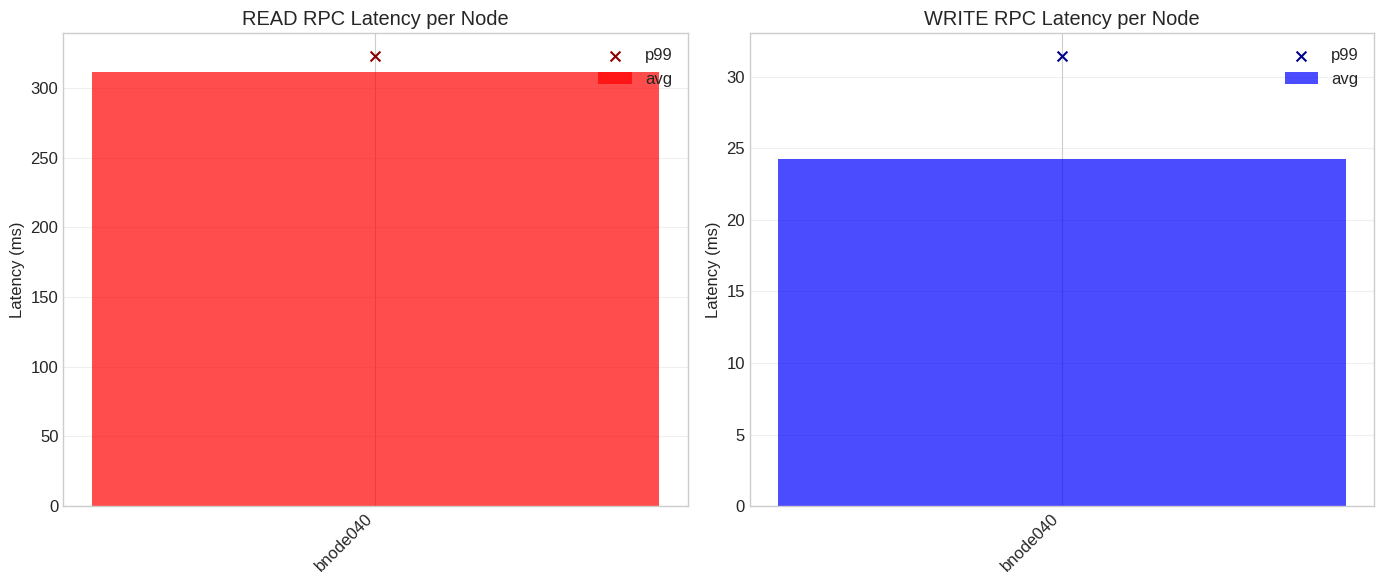

Saved: rpc_latency_per_node.png


In [42]:
if rpc_timing_raw is not None and len(rpc_timing_raw) > 0:
    # Group by node and rpc_type
    node_stats = rpc_timing_raw.groupby(['node', 'rpc_type']).agg({
        'total_us': ['mean', 'std', 'count', lambda x: x.quantile(0.99)],
        'io_read_us': 'mean',
        'io_write_us': 'mean',
    }).reset_index()
    node_stats.columns = ['node', 'rpc_type', 'avg_us', 'std_us', 'count', 'p99_us', 'avg_io_read_us', 'avg_io_write_us']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # READ latency per node
    ax1 = axes[0]
    read_stats = node_stats[node_stats['rpc_type'] == 'READ'].sort_values('node')
    if len(read_stats) > 0:
        x = range(len(read_stats))
        ax1.bar(x, read_stats['avg_us'] / 1000, color='red', alpha=0.7, label='avg')
        ax1.scatter(x, read_stats['p99_us'] / 1000, color='darkred', marker='x', s=50, label='p99', zorder=5)
        ax1.set_xticks(x)
        ax1.set_xticklabels(read_stats['node'], rotation=45, ha='right')
        ax1.set_ylabel('Latency (ms)')
        ax1.set_title('READ RPC Latency per Node')
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')
    
    # WRITE latency per node
    ax2 = axes[1]
    write_stats = node_stats[node_stats['rpc_type'] == 'WRITE'].sort_values('node')
    if len(write_stats) > 0:
        x = range(len(write_stats))
        ax2.bar(x, write_stats['avg_us'] / 1000, color='blue', alpha=0.7, label='avg')
        ax2.scatter(x, write_stats['p99_us'] / 1000, color='darkblue', marker='x', s=50, label='p99', zorder=5)
        ax2.set_xticks(x)
        ax2.set_xticklabels(write_stats['node'], rotation=45, ha='right')
        ax2.set_ylabel('Latency (ms)')
        ax2.set_title('WRITE RPC Latency per Node')
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'rpc_latency_per_node.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: rpc_latency_per_node.png")
else:
    print("No RPC timing data available")

## 5.5 Chunk IO Timing (Open/Read/Write/Close Breakdown)

Filtered chunk_io: 215103 / 215103 entries


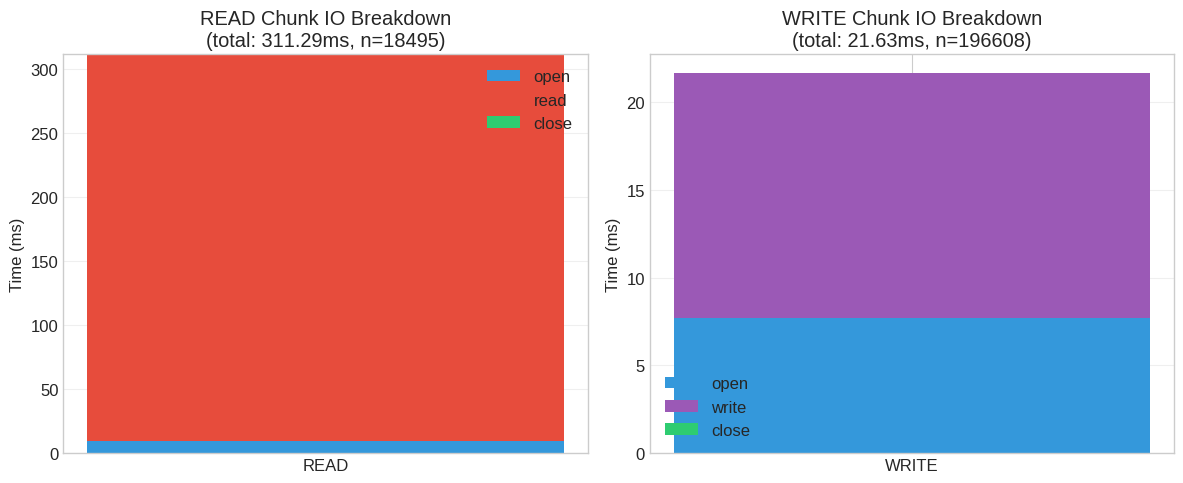

Saved: chunk_io_breakdown.png

=== Chunk IO Timing Comparison (ms) ===
Component            WRITE       READ      Ratio
-----------------------------------------------
open                 7.668      9.096       1.19x
close                0.003      0.003       0.94x
io_operation        13.960    302.194      21.65x


In [43]:
if chunk_io_raw is not None and len(chunk_io_raw) > 0:
    # Filter to valid op_types only
    valid_ops = ['READ_CHUNK_FIXED', 'WRITE_CHUNK_FIXED']
    chunk_io_filtered = chunk_io_raw[chunk_io_raw['op_type'].isin(valid_ops)]
    print(f"Filtered chunk_io: {len(chunk_io_filtered)} / {len(chunk_io_raw)} entries")
    
    # Separate READ and WRITE
    read_io = chunk_io_filtered[chunk_io_filtered['op_type'] == 'READ_CHUNK_FIXED']
    write_io = chunk_io_filtered[chunk_io_filtered['op_type'] == 'WRITE_CHUNK_FIXED']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Stacked bar for READ
    if len(read_io) > 0:
        ax1 = axes[0]
        read_avg = {
            'open': read_io['open_us'].mean() / 1000,
            'read': read_io['read_us'].mean() / 1000,
            'close': read_io['close_us'].mean() / 1000,
        }
        colors = ['#3498db', '#e74c3c', '#2ecc71']
        bottom = 0
        for j, (k, v) in enumerate(read_avg.items()):
            ax1.bar('READ', v, bottom=bottom, color=colors[j], label=k)
            bottom += v
        ax1.set_ylabel('Time (ms)')
        ax1.set_title(f'READ Chunk IO Breakdown\n(total: {bottom:.2f}ms, n={len(read_io)})')
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')
    
    # Stacked bar for WRITE
    if len(write_io) > 0:
        ax2 = axes[1]
        write_avg = {
            'open': write_io['open_us'].mean() / 1000,
            'write': write_io['write_us'].mean() / 1000,
            'close': write_io['close_us'].mean() / 1000,
        }
        colors = ['#3498db', '#9b59b6', '#2ecc71']
        bottom = 0
        for j, (k, v) in enumerate(write_avg.items()):
            ax2.bar('WRITE', v, bottom=bottom, color=colors[j], label=k)
            bottom += v
        ax2.set_ylabel('Time (ms)')
        ax2.set_title(f'WRITE Chunk IO Breakdown\n(total: {bottom:.2f}ms, n={len(write_io)})')
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'chunk_io_breakdown.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: chunk_io_breakdown.png")
    
    # Print comparison
    print("\n=== Chunk IO Timing Comparison (ms) ===")
    print(f"{'Component':<15} {'WRITE':>10} {'READ':>10} {'Ratio':>10}")
    print("-" * 47)
    for comp in ['open', 'close']:
        w = write_io[f'{comp}_us'].mean() / 1000 if len(write_io) > 0 else 0
        r = read_io[f'{comp}_us'].mean() / 1000 if len(read_io) > 0 else 0
        ratio = r / w if w > 0 else 0
        print(f"{comp:<15} {w:>10.3f} {r:>10.3f} {ratio:>10.2f}x")
    # IO operation
    w_io = write_io['write_us'].mean() / 1000 if len(write_io) > 0 else 0
    r_io = read_io['read_us'].mean() / 1000 if len(read_io) > 0 else 0
    print(f"{'io_operation':<15} {w_io:>10.3f} {r_io:>10.3f} {r_io/w_io if w_io > 0 else 0:>10.2f}x")
else:
    print("No chunk IO timing data available")

## 5.6 RPC Throughput Over Time

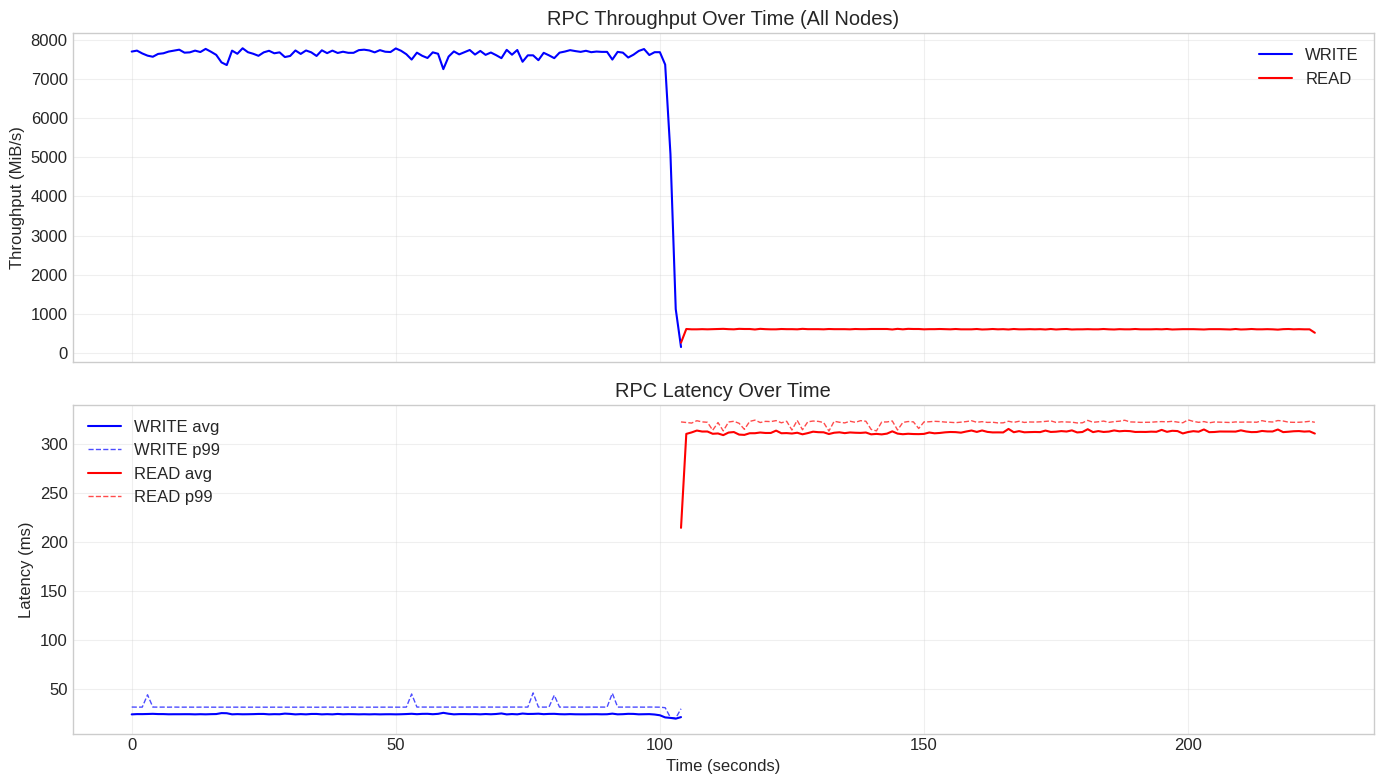

Saved: rpc_timing_over_time.png


In [44]:
if rpc_timing_agg is not None and len(rpc_timing_agg) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    # Throughput over time
    ax1 = axes[0]
    for rpc_type in ['WRITE', 'READ']:
        data = rpc_timing_agg[rpc_timing_agg['rpc_type'] == rpc_type]
        if len(data) > 0:
            # Sum across all nodes for each time bucket
            by_time = data.groupby('time_bucket')['throughput_mib_s'].sum().reset_index()
            color = 'blue' if rpc_type == 'WRITE' else 'red'
            ax1.plot(by_time['time_bucket'], by_time['throughput_mib_s'], 
                     label=rpc_type, color=color, linewidth=1.5)
    ax1.set_ylabel('Throughput (MiB/s)')
    ax1.set_title('RPC Throughput Over Time (All Nodes)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Latency over time
    ax2 = axes[1]
    for rpc_type in ['WRITE', 'READ']:
        data = rpc_timing_agg[rpc_timing_agg['rpc_type'] == rpc_type]
        if len(data) > 0:
            # Average latency across all nodes for each time bucket
            by_time = data.groupby('time_bucket').agg({
                'avg_total_us': 'mean',
                'p99_total_us': 'mean'
            }).reset_index()
            color = 'blue' if rpc_type == 'WRITE' else 'red'
            ax2.plot(by_time['time_bucket'], by_time['avg_total_us'] / 1000, 
                     label=f'{rpc_type} avg', color=color, linewidth=1.5)
            ax2.plot(by_time['time_bucket'], by_time['p99_total_us'] / 1000, 
                     label=f'{rpc_type} p99', color=color, linestyle='--', linewidth=1, alpha=0.7)
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Latency (ms)')
    ax2.set_title('RPC Latency Over Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'rpc_timing_over_time.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: rpc_timing_over_time.png")
else:
    print("No aggregated RPC timing data available")

## 5.7 Summary Statistics

In [45]:
if rpc_timing_raw is not None and len(rpc_timing_raw) > 0:
    print("=" * 70)
    print("Server RPC Timing Summary")
    print("=" * 70)
    
    for rpc_type in ['WRITE', 'READ']:
        data = rpc_timing_raw[rpc_timing_raw['rpc_type'] == rpc_type]
        if len(data) == 0:
            continue
        
        print(f"\n--- {rpc_type} ({len(data)} samples) ---")
        
        # Total latency stats
        total = data['total_us'] / 1000  # ms
        print(f"Total Latency:  avg={total.mean():.2f}ms, p50={total.median():.2f}ms, "
              f"p95={total.quantile(0.95):.2f}ms, p99={total.quantile(0.99):.2f}ms, max={total.max():.2f}ms")
        
        # IO operation stats
        if rpc_type == 'READ':
            io_col = 'io_read_us'
        else:
            io_col = 'io_write_us'
        io = data[io_col] / 1000
        print(f"IO Operation:   avg={io.mean():.2f}ms, p50={io.median():.2f}ms, "
              f"p95={io.quantile(0.95):.2f}ms, p99={io.quantile(0.99):.2f}ms, max={io.max():.2f}ms")
        
        # Buffer acquire stats
        buf = data['buffer_acquire_us'] / 1000
        print(f"Buffer Acquire: avg={buf.mean():.2f}ms, p50={buf.median():.2f}ms, "
              f"p95={buf.quantile(0.95):.2f}ms, p99={buf.quantile(0.99):.2f}ms, max={buf.max():.2f}ms")
        
        # Reply stats
        reply = data['reply_us'] / 1000
        print(f"Reply Send:     avg={reply.mean():.2f}ms, p50={reply.median():.2f}ms, "
              f"p95={reply.quantile(0.95):.2f}ms, p99={reply.quantile(0.99):.2f}ms, max={reply.max():.2f}ms")
    
    # Comparison
    read_data = rpc_timing_raw[rpc_timing_raw['rpc_type'] == 'READ']
    write_data = rpc_timing_raw[rpc_timing_raw['rpc_type'] == 'WRITE']
    
    if len(read_data) > 0 and len(write_data) > 0:
        print("\n" + "=" * 70)
        print("READ vs WRITE Ratio (READ/WRITE)")
        print("=" * 70)
        
        r_total = read_data['total_us'].mean()
        w_total = write_data['total_us'].mean()
        print(f"Total Latency:  {r_total/w_total:.2f}x")
        
        r_io = read_data['io_read_us'].mean()
        w_io = write_data['io_write_us'].mean()
        print(f"IO Operation:   {r_io/w_io:.2f}x")
        
        r_buf = read_data['buffer_acquire_us'].mean()
        w_buf = write_data['buffer_acquire_us'].mean()
        if w_buf > 0:
            print(f"Buffer Acquire: {r_buf/w_buf:.2f}x")
        
        r_reply = read_data['reply_us'].mean()
        w_reply = write_data['reply_us'].mean()
        if w_reply > 0:
            print(f"Reply Send:     {r_reply/w_reply:.2f}x")
else:
    print("No RPC timing data available")

Server RPC Timing Summary

--- WRITE (196608 samples) ---
Total Latency:  avg=24.27ms, p50=21.03ms, p95=31.32ms, p99=31.47ms, max=55.24ms
IO Operation:   avg=21.64ms, p50=18.61ms, p95=28.70ms, p99=28.94ms, max=52.50ms
Buffer Acquire: avg=0.00ms, p50=0.00ms, p95=0.00ms, p99=0.00ms, max=0.00ms
Reply Send:     avg=0.00ms, p50=0.00ms, p95=0.00ms, p99=0.00ms, max=0.01ms

--- READ (18495 samples) ---
Total Latency:  avg=311.63ms, p50=311.90ms, p95=321.89ms, p99=322.97ms, max=332.33ms
IO Operation:   avg=311.30ms, p50=311.59ms, p95=321.50ms, p99=322.57ms, max=331.95ms
Buffer Acquire: avg=0.00ms, p50=0.00ms, p95=0.00ms, p99=0.00ms, max=0.00ms
Reply Send:     avg=0.33ms, p50=0.29ms, p95=0.50ms, p99=0.62ms, max=18.38ms

READ vs WRITE Ratio (READ/WRITE)
Total Latency:  12.84x
IO Operation:   14.38x
Buffer Acquire: 0.64x
Reply Send:     686449.88x


---
# 6. AM (Active Message) Timing Analysis

Analysis of UCX Active Message send/receive latencies to understand RPC communication overhead.

## 6.1 Load AM Timing Data

In [46]:
# Load AM timing data
am_send_file = RESULTS_DIR / 'am_send_timing_raw.csv'
am_wait_file = RESULTS_DIR / 'am_wait_timing_raw.csv'

am_send_df = None
am_wait_df = None

if am_send_file.exists():
    am_send_df = pd.read_csv(am_send_file)
    am_send_df['timestamp'] = pd.to_datetime(am_send_df['timestamp'])
    print(f'Loaded {len(am_send_df)} AM_SEND_TIMING records')
    display(am_send_df.head())
else:
    print(f'AM send timing file not found: {am_send_file}')
    print('Run extract_am_timing.sh to generate this file')

if am_wait_file.exists():
    am_wait_df = pd.read_csv(am_wait_file)
    am_wait_df['timestamp'] = pd.to_datetime(am_wait_df['timestamp'])
    print(f'Loaded {len(am_wait_df)} AM_WAIT_MSG_TIMING records')
    display(am_wait_df.head())
else:
    print(f'AM wait timing file not found: {am_wait_file}')
    print('Run extract_am_timing.sh to generate this file')

AM send timing file not found: /work/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2026.02.26-07.48.19-debug_large/2026.02.26-07.49.16-572120.nqsv-2/am_send_timing_raw.csv
Run extract_am_timing.sh to generate this file
AM wait timing file not found: /work/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2026.02.26-07.48.19-debug_large/2026.02.26-07.49.16-572120.nqsv-2/am_wait_timing_raw.csv
Run extract_am_timing.sh to generate this file


## 6.2 AM Send Latency Distribution

In [47]:
if am_send_df is not None and len(am_send_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Total latency histogram
    ax1 = axes[0]
    am_send_df['total_us'].hist(bins=50, ax=ax1, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Total Latency (us)')
    ax1.set_ylabel('Count')
    ax1.set_title('AM Send Total Latency Distribution')
    ax1.axvline(am_send_df['total_us'].mean(), color='red', linestyle='--', label=f"Mean: {am_send_df['total_us'].mean():.0f} us")
    ax1.axvline(am_send_df['total_us'].median(), color='orange', linestyle='--', label=f"Median: {am_send_df['total_us'].median():.0f} us")
    ax1.legend()
    
    # Send vs Activate breakdown (box plot)
    ax2 = axes[1]
    bp_data = [am_send_df['send_us'], am_send_df['activate_us']]
    bp = ax2.boxplot(bp_data, labels=['send_us', 'activate_us'], patch_artist=True)
    bp['boxes'][0].set_facecolor('steelblue')
    bp['boxes'][1].set_facecolor('coral')
    ax2.set_ylabel('Latency (us)')
    ax2.set_title('AM Send Timing Breakdown')
    
    plt.tight_layout()
    plt.savefig(str(RESULTS_DIR / 'am_send_latency_distribution.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('No AM send timing data available')

No AM send timing data available


## 6.3 AM Send Latency Over Time

In [48]:
if am_send_df is not None and len(am_send_df) > 0:
    # Resample to 1-second intervals
    am_send_ts = am_send_df.set_index('timestamp').resample('1s').agg({
        'total_us': ['mean', 'std', 'count'],
        'send_us': 'mean',
        'activate_us': 'mean',
        'data_bytes': 'sum'
    })
    am_send_ts.columns = ['total_us_mean', 'total_us_std', 'count', 'send_us_mean', 'activate_us_mean', 'data_bytes_sum']
    am_send_ts = am_send_ts.dropna()
    
    if len(am_send_ts) > 0:
        fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
        
        # Latency over time
        ax1 = axes[0]
        ax1.plot(am_send_ts.index, am_send_ts['total_us_mean'] / 1000, label='Total (ms)', color='blue', alpha=0.8)
        ax1.fill_between(am_send_ts.index, 
                         (am_send_ts['total_us_mean'] - am_send_ts['total_us_std']) / 1000,
                         (am_send_ts['total_us_mean'] + am_send_ts['total_us_std']) / 1000,
                         alpha=0.2, color='blue')
        ax1.plot(am_send_ts.index, am_send_ts['send_us_mean'] / 1000, label='Send (ms)', color='green', alpha=0.8)
        ax1.set_ylabel('Latency (ms)')
        ax1.set_title('AM Send Latency Over Time')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Request rate and throughput
        ax2 = axes[1]
        ax2.bar(am_send_ts.index, am_send_ts['count'], width=0.8/86400, alpha=0.7, label='Request Count')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Requests/sec')
        ax2.set_title('AM Send Request Rate Over Time')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(str(RESULTS_DIR / 'am_send_latency_over_time.png'), dpi=150, bbox_inches='tight')
        plt.show()
else:
    print('No AM send timing data available')

No AM send timing data available


## 6.4 Per-Node AM Send Latency

In [49]:
if am_send_df is not None and len(am_send_df) > 0:
    nodes = sorted(am_send_df['node'].unique())
    
    if len(nodes) > 0 and nodes[0] != 'unknown':
        fig, ax = plt.subplots(figsize=(14, 6))
        
        # Box plot per node
        node_data = [am_send_df[am_send_df['node'] == n]['total_us'] / 1000 for n in nodes]
        bp = ax.boxplot(node_data, labels=nodes, patch_artist=True)
        
        colors = plt.cm.tab20(range(len(nodes)))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        ax.set_xlabel('Node')
        ax.set_ylabel('Total Latency (ms)')
        ax.set_title('AM Send Latency by Node')
        plt.xticks(rotation=45)
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig(str(RESULTS_DIR / 'am_send_latency_by_node.png'), dpi=150, bbox_inches='tight')
        plt.show()
        
        # Summary table
        summary = am_send_df.groupby('node')['total_us'].agg(['count', 'mean', 'std', 'min', 'max']).round(0)
        summary.columns = ['Count', 'Mean (us)', 'Std (us)', 'Min (us)', 'Max (us)']
        display(summary)
    else:
        print('No per-node data available (node names not extracted)')
else:
    print('No AM send timing data available')

No AM send timing data available


## 6.5 AM Wait (Message Receive) Timing

In [50]:
if am_wait_df is not None and len(am_wait_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Total latency histogram
    ax1 = axes[0]
    am_wait_df['total_us'].hist(bins=50, ax=ax1, alpha=0.7, edgecolor='black', color='coral')
    ax1.set_xlabel('Total Latency (us)')
    ax1.set_ylabel('Count')
    ax1.set_title('AM Wait Total Latency Distribution')
    ax1.axvline(am_wait_df['total_us'].mean(), color='red', linestyle='--', label=f"Mean: {am_wait_df['total_us'].mean():.0f} us")
    ax1.axvline(am_wait_df['total_us'].median(), color='orange', linestyle='--', label=f"Median: {am_wait_df['total_us'].median():.0f} us")
    ax1.legend()
    
    # Wait vs wait_connect breakdown
    ax2 = axes[1]
    bp_data = [am_wait_df['wait_us'], am_wait_df['wait_connect_us']]
    bp = ax2.boxplot(bp_data, labels=['wait_us', 'wait_connect_us'], patch_artist=True)
    bp['boxes'][0].set_facecolor('coral')
    bp['boxes'][1].set_facecolor('lightgreen')
    ax2.set_ylabel('Latency (us)')
    ax2.set_title('AM Wait Timing Breakdown')
    
    plt.tight_layout()
    plt.savefig(str(RESULTS_DIR / 'am_wait_latency_distribution.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('No AM wait timing data available')

No AM wait timing data available


## 6.6 AM Send/Wait Latency Correlation with RPC Timing

In [51]:
# Compare AM timing with RPC timing if both available
if am_send_df is not None and len(am_send_df) > 0:
    # Check if we have server RPC timing data
    rpc_file = RESULTS_DIR / 'server_rpc_timing_raw.csv'
    
    if rpc_file.exists():
        rpc_df = pd.read_csv(rpc_file)
        rpc_df['timestamp'] = pd.to_datetime(rpc_df['timestamp'])
        
        # Resample both to 1-second intervals
        am_ts = am_send_df.set_index('timestamp').resample('1s')['total_us'].mean()
        rpc_ts = rpc_df.set_index('timestamp').resample('1s')['total_us'].mean()
        
        # Align the time series
        combined = pd.DataFrame({'am_send_us': am_ts, 'rpc_total_us': rpc_ts}).dropna()
        
        if len(combined) > 10:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # Time series comparison
            ax1 = axes[0]
            ax1.plot(combined.index, combined['am_send_us'] / 1000, label='AM Send (ms)', alpha=0.8)
            ax1.plot(combined.index, combined['rpc_total_us'] / 1000, label='RPC Total (ms)', alpha=0.8)
            ax1.set_xlabel('Time')
            ax1.set_ylabel('Latency (ms)')
            ax1.set_title('AM Send vs RPC Total Latency Over Time')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Scatter plot correlation
            ax2 = axes[1]
            ax2.scatter(combined['am_send_us'] / 1000, combined['rpc_total_us'] / 1000, alpha=0.5)
            ax2.set_xlabel('AM Send Latency (ms)')
            ax2.set_ylabel('RPC Total Latency (ms)')
            ax2.set_title('AM Send vs RPC Total Correlation')
            
            # Add correlation coefficient
            corr = combined['am_send_us'].corr(combined['rpc_total_us'])
            ax2.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax2.transAxes, 
                     verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat'))
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(str(RESULTS_DIR / 'am_rpc_correlation.png'), dpi=150, bbox_inches='tight')
            plt.show()
        else:
            print('Not enough overlapping data points for correlation analysis')
    else:
        print('No RPC timing data available for correlation analysis')
else:
    print('No AM send timing data available')

No AM send timing data available


## 6.7 AM Timing Summary

In [52]:
print('=' * 60)
print('AM (Active Message) Timing Summary')
print('=' * 60)

if am_send_df is not None and len(am_send_df) > 0:
    print(f'\nAM_SEND_TIMING:')
    print(f'  Total records: {len(am_send_df):,}')
    print(f'  Avg total_us: {am_send_df["total_us"].mean():,.0f} us ({am_send_df["total_us"].mean()/1000:.2f} ms)')
    print(f'  Avg send_us: {am_send_df["send_us"].mean():,.0f} us ({am_send_df["send_us"].mean()/1000:.2f} ms)')
    print(f'  Avg activate_us: {am_send_df["activate_us"].mean():,.0f} us')
    print(f'  Min/Max total_us: {am_send_df["total_us"].min():,} / {am_send_df["total_us"].max():,} us')
    print(f'  P50/P95/P99 total_us: {am_send_df["total_us"].quantile(0.5):,.0f} / {am_send_df["total_us"].quantile(0.95):,.0f} / {am_send_df["total_us"].quantile(0.99):,.0f} us')
else:
    print('\nNo AM_SEND_TIMING data')

if am_wait_df is not None and len(am_wait_df) > 0:
    print(f'\nAM_WAIT_MSG_TIMING:')
    print(f'  Total records: {len(am_wait_df):,}')
    print(f'  Avg total_us: {am_wait_df["total_us"].mean():,.0f} us ({am_wait_df["total_us"].mean()/1000:.2f} ms)')
    print(f'  Avg wait_us: {am_wait_df["wait_us"].mean():,.0f} us ({am_wait_df["wait_us"].mean()/1000:.2f} ms)')
    print(f'  Avg wait_connect_us: {am_wait_df["wait_connect_us"].mean():,.0f} us')
    print(f'  Min/Max total_us: {am_wait_df["total_us"].min():,} / {am_wait_df["total_us"].max():,} us')
    print(f'  P50/P95/P99 total_us: {am_wait_df["total_us"].quantile(0.5):,.0f} / {am_wait_df["total_us"].quantile(0.95):,.0f} / {am_wait_df["total_us"].quantile(0.99):,.0f} us')
else:
    print('\nNo AM_WAIT_MSG_TIMING data')

print('\n' + '=' * 60)

AM (Active Message) Timing Summary

No AM_SEND_TIMING data

No AM_WAIT_MSG_TIMING data



---
# Part 7: RPC Concurrency Analysis

Analyzes RPC request concurrency on servers. This helps identify if:
- Client requests are arriving concurrently
- Server-side request handling is keeping up with demand

**Metrics:**
- **ongoing**: Number of RPC requests currently being processed
- **peak**: Maximum concurrent requests observed
- **received/completed**: Cumulative counters for request tracking

In [53]:
# Load RPC concurrency data
df_rpc_concurrency = load_csv_if_exists(RESULTS_DIR / 'rpc_concurrency_raw.csv', 'rpc_concurrency_raw.csv')

if df_rpc_concurrency is not None:
    # Parse timestamp and create time bucket
    df_rpc_concurrency['timestamp'] = pd.to_datetime(df_rpc_concurrency['timestamp'])
    min_time = df_rpc_concurrency['timestamp'].min()
    df_rpc_concurrency['time_seconds'] = (df_rpc_concurrency['timestamp'] - min_time).dt.total_seconds()
    df_rpc_concurrency['time_bucket'] = df_rpc_concurrency['time_seconds'].astype(int)
    
    print(f"\nRPC Concurrency statistics:")
    print(f"  Mean ongoing: {df_rpc_concurrency['ongoing'].mean():.2f}")
    print(f"  Max ongoing: {df_rpc_concurrency['ongoing'].max()}")
    print(f"  Max peak: {df_rpc_concurrency['peak'].max()}")
    print(f"  Total samples: {len(df_rpc_concurrency):,}")

Loaded rpc_concurrency_raw.csv: 2,479 records

RPC Concurrency statistics:
  Mean ongoing: 42.15
  Max ongoing: 48
  Max peak: 48
  Total samples: 2,479


## 7.1 RPC Concurrency Over Time

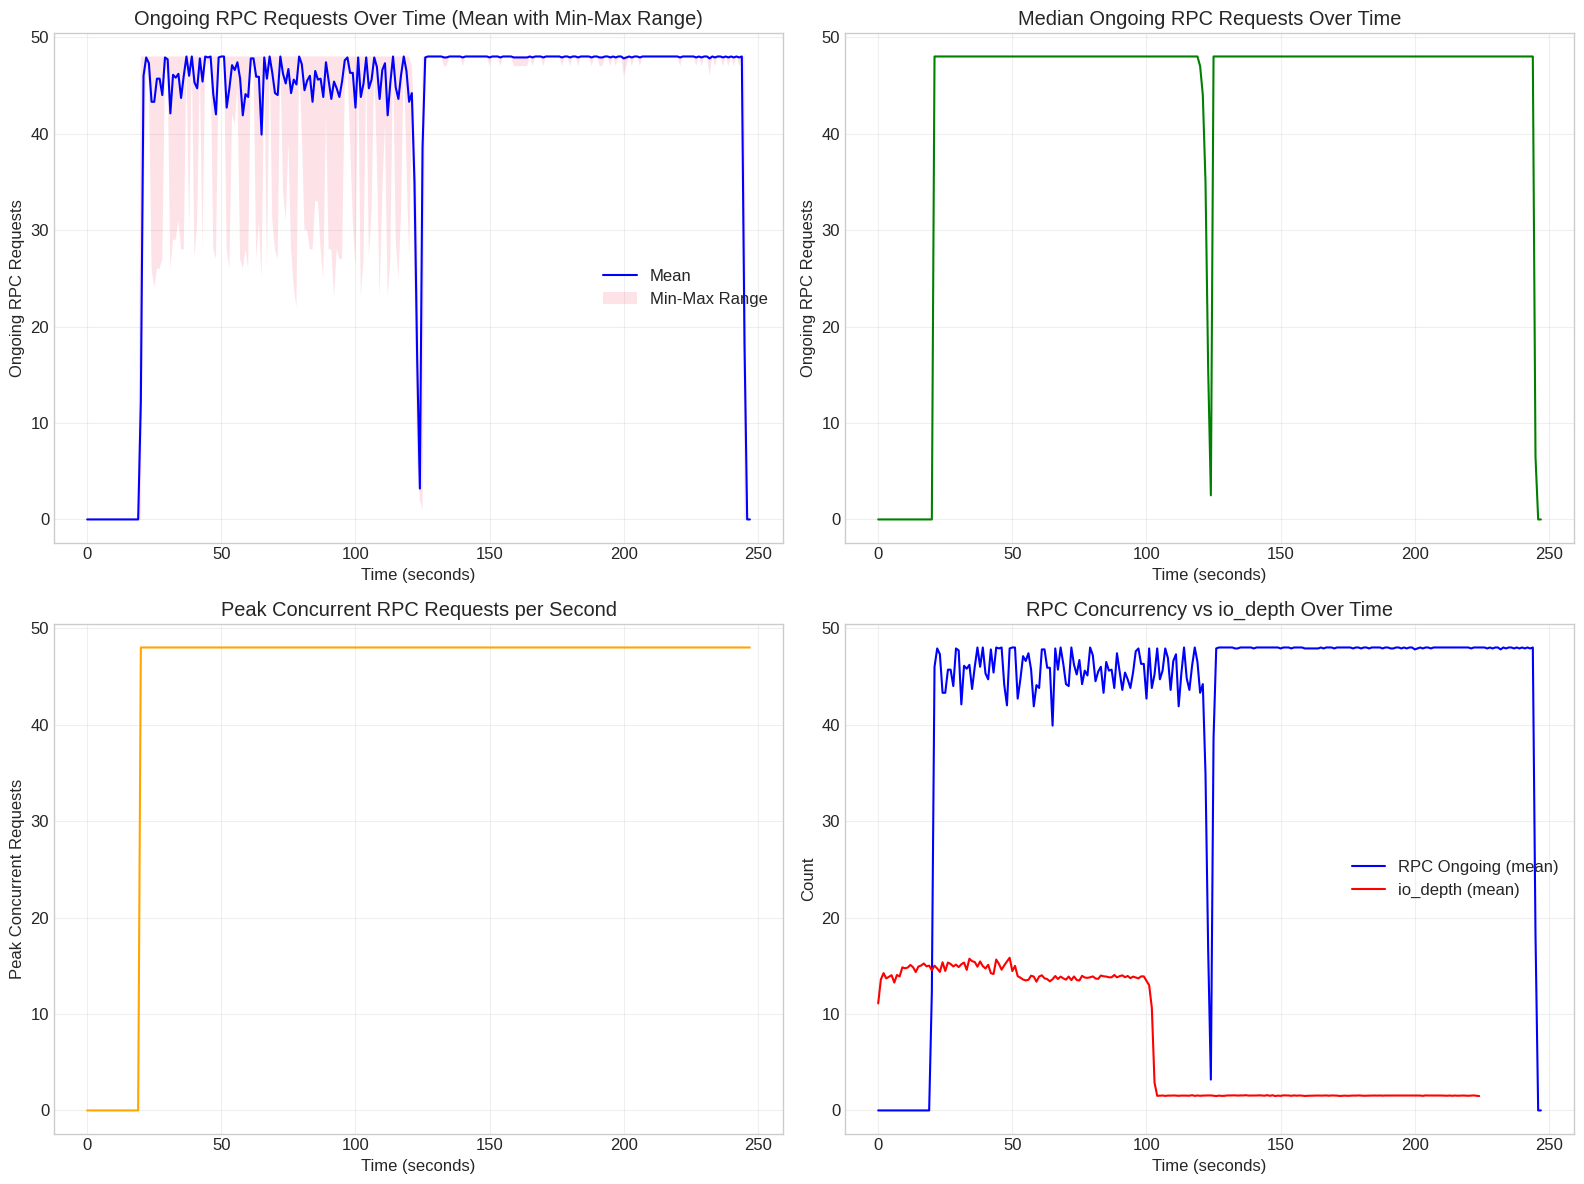

In [54]:
# RPC concurrency over time
if df_rpc_concurrency is not None:
    time_stats = df_rpc_concurrency.groupby('time_bucket').agg({
        'ongoing': ['mean', 'median', 'min', 'max', 'std'],
        'peak': 'max'
    }).reset_index()
    time_stats.columns = ['time', 'ongoing_mean', 'ongoing_median', 'ongoing_min', 'ongoing_max', 'ongoing_std', 'peak_max']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Ongoing mean with min-max range
    ax = axes[0, 0]
    ax.plot(time_stats['time'], time_stats['ongoing_mean'], linewidth=1.5, label='Mean', color='blue')
    ax.fill_between(time_stats['time'], time_stats['ongoing_min'], time_stats['ongoing_max'], alpha=0.2, label='Min-Max Range')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Ongoing RPC Requests')
    ax.set_title('Ongoing RPC Requests Over Time (Mean with Min-Max Range)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Median ongoing
    ax = axes[0, 1]
    ax.plot(time_stats['time'], time_stats['ongoing_median'], linewidth=1.5, color='green')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Ongoing RPC Requests')
    ax.set_title('Median Ongoing RPC Requests Over Time')
    ax.grid(True, alpha=0.3)

    # Plot 3: Peak concurrent
    ax = axes[1, 0]
    ax.plot(time_stats['time'], time_stats['peak_max'], linewidth=1.5, color='orange')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Peak Concurrent Requests')
    ax.set_title('Peak Concurrent RPC Requests per Second')
    ax.grid(True, alpha=0.3)

    # Plot 4: Ongoing vs io_depth comparison (if io_depth available)
    ax = axes[1, 1]
    ax.plot(time_stats['time'], time_stats['ongoing_mean'], linewidth=1.5, color='blue', label='RPC Ongoing (mean)')
    if df_iodepth is not None:
        iodepth_time_stats = df_iodepth.groupby('time_bucket').agg({'io_depth': 'mean'}).reset_index()
        ax.plot(iodepth_time_stats['time_bucket'], iodepth_time_stats['io_depth'], linewidth=1.5, color='red', label='io_depth (mean)')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Count')
    ax.set_title('RPC Concurrency vs io_depth Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'rpc_concurrency_over_time.png', dpi=150)
    plt.show()

## 7.2 RPC Concurrency Distribution

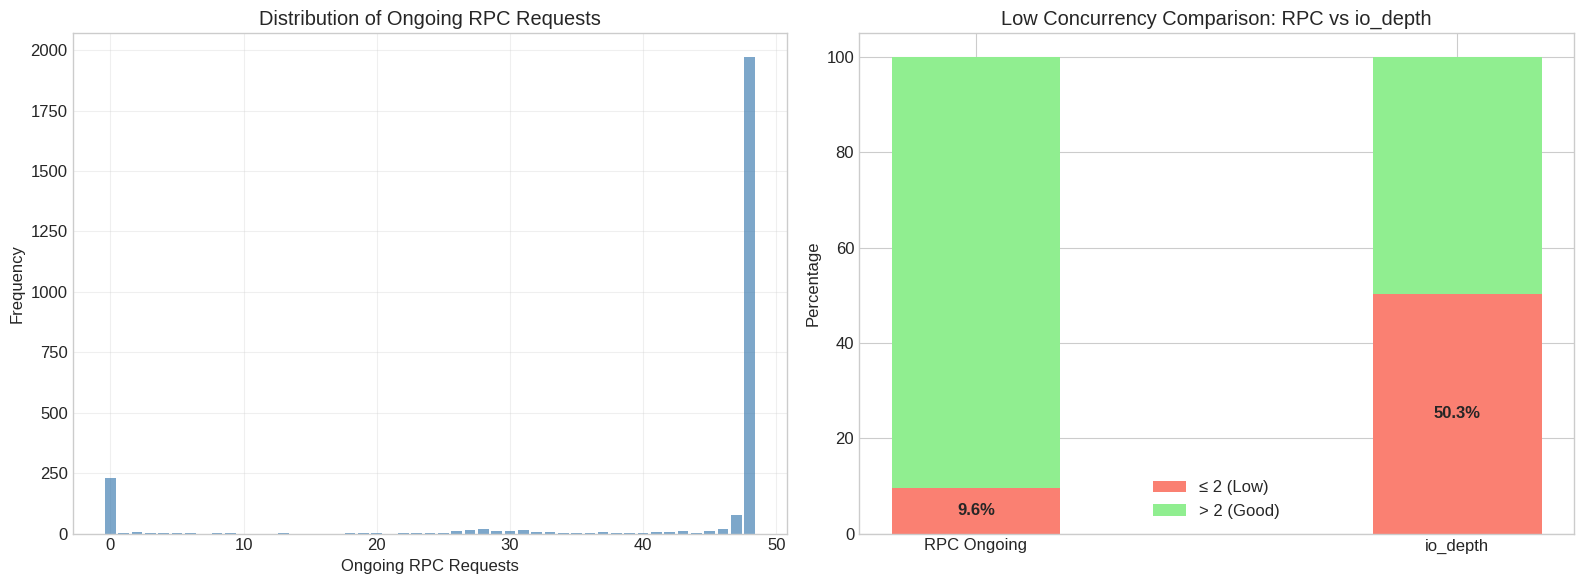


RPC Concurrency Analysis
Percentage with ongoing ≤ 2: 9.6%
Percentage with io_depth ≤ 2: 50.3%



In [55]:
# RPC concurrency distribution
if df_rpc_concurrency is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Distribution of ongoing requests
    ax = axes[0]
    ongoing_counts = df_rpc_concurrency['ongoing'].value_counts().sort_index()
    # Bucket if too many unique values
    if len(ongoing_counts) > 50:
        max_val = df_rpc_concurrency['ongoing'].max()
        bins = list(range(0, min(51, max_val+1))) + [max_val+1]
        df_rpc_concurrency['ongoing_bucket'] = pd.cut(df_rpc_concurrency['ongoing'], bins=bins, labels=bins[:-1], right=False)
        ongoing_counts = df_rpc_concurrency['ongoing_bucket'].value_counts().sort_index()
        ax.bar(range(len(ongoing_counts)), ongoing_counts.values, color='steelblue', alpha=0.7)
        ax.set_xticks(range(0, len(ongoing_counts), 5))
        ax.set_xticklabels([str(i) for i in range(0, len(ongoing_counts), 5)])
    else:
        ax.bar(ongoing_counts.index, ongoing_counts.values, color='steelblue', alpha=0.7)
    ax.set_xlabel('Ongoing RPC Requests')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Ongoing RPC Requests')
    ax.grid(True, alpha=0.3)

    # Compare with io_depth if available
    ax = axes[1]
    if df_iodepth is not None:
        # Side-by-side comparison of low values
        ongoing_low = len(df_rpc_concurrency[df_rpc_concurrency['ongoing'] <= 2]) / len(df_rpc_concurrency) * 100
        iodepth_low = len(df_iodepth[df_iodepth['io_depth'] <= 2]) / len(df_iodepth) * 100
        
        categories = ['RPC Ongoing', 'io_depth']
        low_pcts = [ongoing_low, iodepth_low]
        high_pcts = [100 - ongoing_low, 100 - iodepth_low]
        
        x = np.arange(len(categories))
        width = 0.35
        
        bars1 = ax.bar(x, low_pcts, width, label='≤ 2 (Low)', color='salmon')
        bars2 = ax.bar(x, high_pcts, width, bottom=low_pcts, label='> 2 (Good)', color='lightgreen')
        
        ax.set_ylabel('Percentage')
        ax.set_title('Low Concurrency Comparison: RPC vs io_depth')
        ax.set_xticks(x)
        ax.set_xticklabels(categories)
        ax.legend()
        
        # Add percentage labels
        for bar, pct in zip(bars1, low_pcts):
            ax.annotate(f'{pct:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()/2),
                       ha='center', va='center', fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'io_depth data not available for comparison', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title('RPC vs io_depth Comparison (N/A)')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'rpc_concurrency_distribution.png', dpi=150)
    plt.show()

    # Print analysis
    print('\n' + '=' * 60)
    print('RPC Concurrency Analysis')
    print('=' * 60)
    ongoing_low_pct = len(df_rpc_concurrency[df_rpc_concurrency['ongoing'] <= 2]) / len(df_rpc_concurrency) * 100
    print(f"Percentage with ongoing ≤ 2: {ongoing_low_pct:.1f}%")
    
    if df_iodepth is not None:
        iodepth_low_pct = len(df_iodepth[df_iodepth['io_depth'] <= 2]) / len(df_iodepth) * 100
        print(f"Percentage with io_depth ≤ 2: {iodepth_low_pct:.1f}%")
        print()
        if ongoing_low_pct < 30 and iodepth_low_pct > 70:
            print("*** INSIGHT: RPC concurrency is healthy but io_depth is low ***")
            print("This suggests the bottleneck is NOT in RPC request arrival,")
            print("but in io_uring SQE batching (handlers not accumulating SQEs).")
        elif ongoing_low_pct > 70:
            print("*** INSIGHT: RPC concurrency is low ***")
            print("This suggests requests are not arriving concurrently from clients.")

## 7.3 Per-Node RPC Concurrency

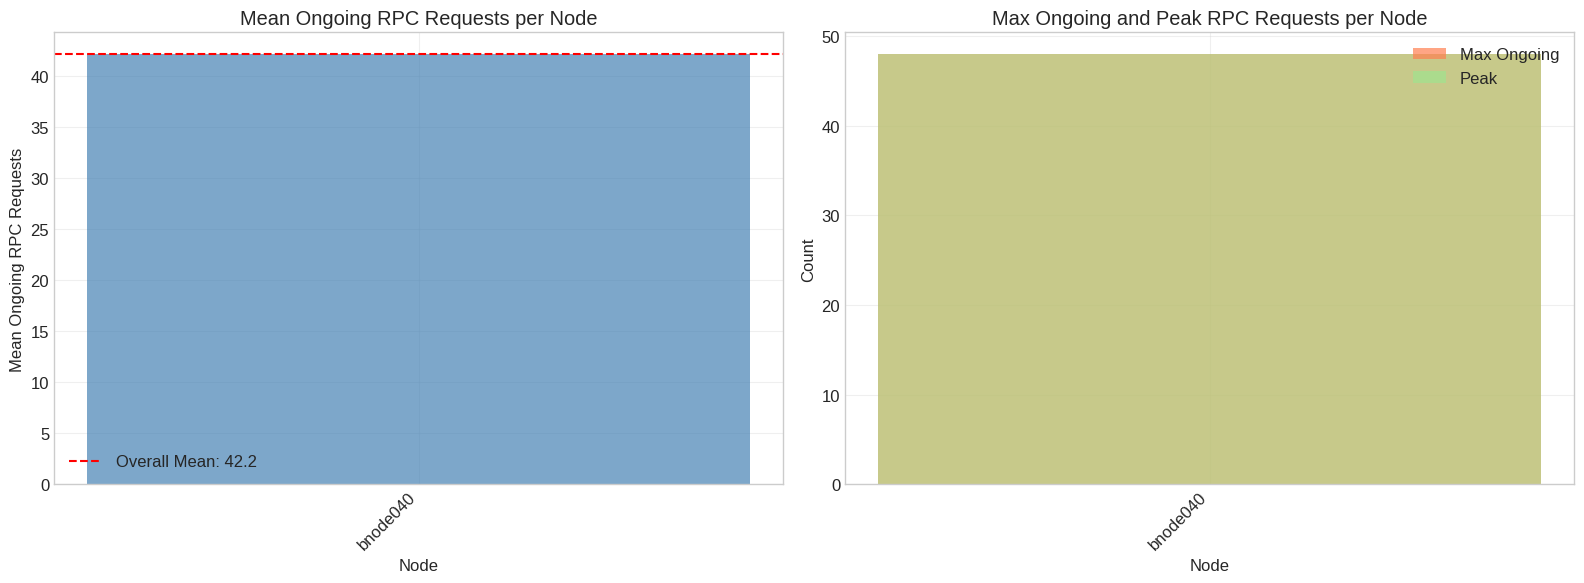

In [56]:
# Per-node RPC concurrency analysis
if df_rpc_concurrency is not None:
    # Get unique nodes (filter out malformed entries, system-dependent)
    valid_nodes = df_rpc_concurrency[df_rpc_concurrency['node'].str.match(valid_node_regex(), na=False)]
    
    if len(valid_nodes) > 0:
        node_stats = valid_nodes.groupby('node').agg({
            'ongoing': ['mean', 'max'],
            'peak': 'max'
        }).reset_index()
        node_stats.columns = ['node', 'ongoing_mean', 'ongoing_max', 'peak_max']
        node_stats = node_stats.sort_values('node')
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Mean ongoing per node
        ax = axes[0]
        x = range(len(node_stats))
        ax.bar(x, node_stats['ongoing_mean'], color='steelblue', alpha=0.7)
        ax.set_xlabel('Node')
        ax.set_ylabel('Mean Ongoing RPC Requests')
        ax.set_title('Mean Ongoing RPC Requests per Node')
        ax.set_xticks(x)
        ax.set_xticklabels(node_stats['node'], rotation=45, ha='right')
        ax.axhline(y=node_stats['ongoing_mean'].mean(), color='red', linestyle='--', label=f'Overall Mean: {node_stats["ongoing_mean"].mean():.1f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Max ongoing per node
        ax = axes[1]
        ax.bar(x, node_stats['ongoing_max'], color='coral', alpha=0.7, label='Max Ongoing')
        ax.bar(x, node_stats['peak_max'], color='lightgreen', alpha=0.5, label='Peak')
        ax.set_xlabel('Node')
        ax.set_ylabel('Count')
        ax.set_title('Max Ongoing and Peak RPC Requests per Node')
        ax.set_xticks(x)
        ax.set_xticklabels(node_stats['node'], rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / 'rpc_concurrency_per_node.png', dpi=150)
        plt.show()

---
# Summary

Analysis completed. Check the generated PNG files in the results directory.

In [57]:
print("=" * 80)
print("Analysis Complete")
print("=" * 80)
print(f"\nResults directory: {RESULTS_DIR}")
print("\nGenerated files:")
for f in sorted(RESULTS_DIR.glob('*.png')):
    print(f"  - {f.name}")

Analysis Complete

Results directory: /work/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2026.02.26-07.48.19-debug_large/2026.02.26-07.49.16-572120.nqsv-2

Generated files:
  - chunk_io_breakdown.png
  - io_depth_distribution.png
  - io_depth_efficiency.png
  - io_depth_heatmap.png
  - io_depth_over_time.png
  - io_depth_per_node.png
  - io_depth_per_node_over_time.png
  - io_timing_bandwidth_distribution.png
  - io_timing_over_time.png
  - io_timing_per_node_summary.png
  - io_timing_read_count_per_node.png
  - io_timing_read_per_node.png
  - io_timing_read_throughput_per_node.png
  - io_timing_write_count_per_node.png
  - io_timing_write_per_node.png
  - io_timing_write_throughput_per_node.png
  - iostat_aqu_sz_over_time.png
  - iostat_latency_comparison.png
  - iostat_r_await_heatmap.png
  - iostat_r_await_over_time.png
  - iostat_throughput_over_time.png
  - iostat_throughput_with_fio_baseline.png
  - read_heatmap.png
  - read_imbalance.png
  - read_load_distribution.png
  - r